In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import BRADY and J-score data

### J-scores

In [3]:
j_2017 = pd.read_csv('hermes_j_2017.csv')
j_2017

,Unnamed: 0,Full Name,0,1,Position,Team
0,0,Mike Evans,0.189278,0.810722,WR,Tampa Bay Buccaneers
1,1,Devonta Freeman,0.234855,0.765145,RB,Atlanta Falcons
2,2,Ezekiel Elliott,0.245903,0.754097,RB,Dallas Cowboys
3,3,Julio Jones,0.280293,0.719707,WR,Atlanta Falcons
4,4,Odell Beckham,0.283363,0.716637,WR,New York Giants
...,...,...,...,...,...,...
470,470,Rex Burkhead,0.993949,0.006051,RB,-
471,471,Fitzgerald Toussaint,0.993949,0.006051,RB,-
472,472,Fozzy Whittaker,0.993949,0.006051,RB,-
473,473,J.D. McKissic,0.993949,0.006051,RB,-


In [4]:
j_2017_fixed = pd.read_csv('j_scores_2017_hermes.csv')
j_2017_fixed

,Unnamed: 0,Full Name,0,1,fpts_2017
0,0,Odell Beckham,0.063878,0.936122,74.0
1,1,Mike Evans,0.081034,0.918966,201.0
2,2,Travis Kelce,0.083741,0.916259,234.0
3,3,Devonta Freeman,0.090445,0.909555,200.2
4,4,Le'Veon Bell,0.092330,0.907670,342.0
...,...,...,...,...,...
468,468,Brandon Williams,0.998852,0.001148,25.0
469,469,Eric Tomlinson,0.998852,0.001148,26.4
470,470,Logan Paulsen,0.998852,0.001148,0.0
471,471,Nick Williams,0.998852,0.001148,6.0


In [5]:
j_2017_df = j_2017_fixed.merge(j_2017[['Full Name','Team','Position']],on='Full Name',how='left')
j_2017_df

,Unnamed: 0,Full Name,0,1,fpts_2017,Team,Position
0,0,Odell Beckham,0.063878,0.936122,74.0,New York Giants,WR
1,1,Mike Evans,0.081034,0.918966,201.0,Tampa Bay Buccaneers,WR
2,2,Travis Kelce,0.083741,0.916259,234.0,Kansas City Chiefs,TE
3,3,Devonta Freeman,0.090445,0.909555,200.2,Atlanta Falcons,RB
4,4,Le'Veon Bell,0.092330,0.907670,342.0,Pittsburgh Steelers,RB
...,...,...,...,...,...,...,...
482,468,Brandon Williams,0.998852,0.001148,25.0,-,TE
483,469,Eric Tomlinson,0.998852,0.001148,26.4,-,TE
484,470,Logan Paulsen,0.998852,0.001148,0.0,-,TE
485,471,Nick Williams,0.998852,0.001148,6.0,-,WR


In [6]:
j_2017_group = j_2017_df.groupby(['Team']).agg({'1':'sum'})
j_2017_group

,1
Team,
-,1.817283
Arizona Cardinals,1.842512
Atlanta Falcons,2.488917
Baltimore Ravens,0.861632
Buffalo Bills,1.629605
Carolina Panthers,1.895664
Chicago Bears,0.969865
Cincinnati Bengals,2.246931
Cleveland Browns,1.521995


In [7]:
j_2017_merge = j_2017_df.merge(j_2017_group, on='Team',how='left')
j_2017_merge

,Unnamed: 0,Full Name,0,1_x,fpts_2017,Team,Position,1_y
0,0,Odell Beckham,0.063878,0.936122,74.0,New York Giants,WR,1.853166
1,1,Mike Evans,0.081034,0.918966,201.0,Tampa Bay Buccaneers,WR,1.244098
2,2,Travis Kelce,0.083741,0.916259,234.0,Kansas City Chiefs,TE,2.112971
3,3,Devonta Freeman,0.090445,0.909555,200.2,Atlanta Falcons,RB,2.488917
4,4,Le'Veon Bell,0.092330,0.907670,342.0,Pittsburgh Steelers,RB,2.309725
...,...,...,...,...,...,...,...,...
482,468,Brandon Williams,0.998852,0.001148,25.0,-,TE,1.817283
483,469,Eric Tomlinson,0.998852,0.001148,26.4,-,TE,1.817283
484,470,Logan Paulsen,0.998852,0.001148,0.0,-,TE,1.817283
485,471,Nick Williams,0.998852,0.001148,6.0,-,WR,1.817283


In [8]:
j_2017_merge['offense_share'] = j_2017_merge['1_x'] / j_2017_merge['1_y']
j_2017_merge

,Unnamed: 0,Full Name,0,1_x,fpts_2017,Team,Position,1_y,offense_share
0,0,Odell Beckham,0.063878,0.936122,74.0,New York Giants,WR,1.853166,0.505148
1,1,Mike Evans,0.081034,0.918966,201.0,Tampa Bay Buccaneers,WR,1.244098,0.738661
2,2,Travis Kelce,0.083741,0.916259,234.0,Kansas City Chiefs,TE,2.112971,0.433635
3,3,Devonta Freeman,0.090445,0.909555,200.2,Atlanta Falcons,RB,2.488917,0.365442
4,4,Le'Veon Bell,0.092330,0.907670,342.0,Pittsburgh Steelers,RB,2.309725,0.392978
...,...,...,...,...,...,...,...,...,...
482,468,Brandon Williams,0.998852,0.001148,25.0,-,TE,1.817283,0.000632
483,469,Eric Tomlinson,0.998852,0.001148,26.4,-,TE,1.817283,0.000632
484,470,Logan Paulsen,0.998852,0.001148,0.0,-,TE,1.817283,0.000632
485,471,Nick Williams,0.998852,0.001148,6.0,-,WR,1.817283,0.000632


In [9]:
j_2017_final = j_2017_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                                          '1_y':'team_score'})
j_2017_final

,Unnamed: 0,Full Name,j-score,fpts_2017,Team,Position,team_score,offense_share
0,0,Odell Beckham,0.936122,74.0,New York Giants,WR,1.853166,0.505148
1,1,Mike Evans,0.918966,201.0,Tampa Bay Buccaneers,WR,1.244098,0.738661
2,2,Travis Kelce,0.916259,234.0,Kansas City Chiefs,TE,2.112971,0.433635
3,3,Devonta Freeman,0.909555,200.2,Atlanta Falcons,RB,2.488917,0.365442
4,4,Le'Veon Bell,0.907670,342.0,Pittsburgh Steelers,RB,2.309725,0.392978
...,...,...,...,...,...,...,...,...
365,351,Derek Carrier,0.004825,15.2,Los Angeles Rams,TE,2.684484,0.001798
366,352,Chris Johnson,0.004765,20.8,Arizona Cardinals,RB,1.842512,0.002586
402,388,Freddie Martino,0.003926,14.5,Tampa Bay Buccaneers,WR,1.244098,0.003155
415,401,Anthony Fasano,0.003369,29.0,Miami Dolphins,TE,1.838224,0.001833


In [10]:
j_2018 = pd.read_csv('hermes_j_2018.csv')

j_2018_fixed = pd.read_csv('j_scores_2018_hermes.csv')

j_2018_df = j_2018_fixed.merge(j_2018[['Full Name','Team','Position']],on='Full Name',how='left')

j_2018_group = j_2018_df.groupby(['Team']).agg({'1':'sum'})

j_2018_merge = j_2018_df.merge(j_2018_group, on='Team',how='left')

j_2018_merge['offense_share'] = j_2018_merge['1_x'] / j_2018_merge['1_y']

j_2018_final = j_2018_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                                 '1_y':'team_score'})
j_2018_final

,Unnamed: 0,Full Name,j-score,fpts_2018,Team,Position,team_score,offense_share
0,0,Alvin Kamara,0.962555,348.0,New Orleans Saints,RB,2.857685,0.336830
1,1,Travis Kelce,0.949621,294.4,Kansas City Chiefs,TE,3.026202,0.313800
2,2,DeAndre Hopkins,0.928826,332.8,Houston Texans,WR,1.625117,0.571544
3,3,Tyreek Hill,0.922172,328.0,Kansas City Chiefs,WR,3.026202,0.304729
4,4,Kareem Hunt,0.917234,229.9,Kansas City Chiefs,RB,3.026202,0.303098
...,...,...,...,...,...,...,...,...
356,349,Brandon Tate,0.005229,0.0,New Orleans Saints,WR,2.857685,0.001830
377,364,Andre Roberts,0.004966,24.0,New York Jets,WR,0.596089,0.008331
426,413,Freddie Martino,0.003926,0.0,Tampa Bay Buccaneers,WR,1.399795,0.002804
463,450,Ryan Switzer,0.002680,68.8,Pittsburgh Steelers,WR,2.669980,0.001004


In [11]:
j_2019 = pd.read_csv('hermes_j_2019.csv')

j_2019_fixed = pd.read_csv('j_scores_2019_hermes.csv')

j_2019_df = j_2019_fixed.merge(j_2019[['Full Name','Team','Position']],on='Full Name',how='left')

j_2019_group = j_2019_df.groupby(['Team']).agg({'1':'sum'})

j_2019_merge = j_2019_df.merge(j_2019_group, on='Team',how='left')

j_2019_merge['offense_share'] = j_2019_merge['1_x'] / j_2019_merge['1_y']

j_2019_final = j_2019_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                               '1_y':'team_score'})
j_2019_final

,Unnamed: 0,Full Name,j-score,fpts_2019,Team,Position,team_score,offense_share
0,0,Alvin Kamara,0.969049,249.2,New Orleans Saints,RB,1.998774,0.484822
1,1,Tyreek Hill,0.954797,188.4,Kansas City Chiefs,WR,2.228966,0.428359
2,2,Stefon Diggs,0.936484,214.5,Buffalo Bills,WR,2.369775,0.395179
3,3,Travis Kelce,0.931323,254.4,Kansas City Chiefs,TE,2.228966,0.417828
4,4,Julio Jones,0.928854,274.5,Atlanta Falcons,WR,1.867080,0.497490
...,...,...,...,...,...,...,...,...
409,396,Marshawn Lynch,0.004023,9.4,Seattle Seahawks,RB,2.000507,0.002011
419,406,Delanie Walker,0.003784,54.6,Tennessee Titans,TE,2.100158,0.001802
432,419,Auden Tate,0.003254,102.0,Cincinnati Bengals,WR,1.830413,0.001778
443,430,Justin Watson,0.002970,42.7,Tampa Bay Buccaneers,WR,2.034715,0.001460


In [12]:
j_2020 = pd.read_csv('hermes_j_2020.csv')

j_2020_fixed = pd.read_csv('j_scores_2020_hermes.csv')

j_2020_df = j_2020_fixed.merge(j_2020[['Full Name','Team','Position']],on='Full Name',how='left')

j_2020_group = j_2020_df.groupby(['Team']).agg({'1':'sum'})

j_2020_merge = j_2020_df.merge(j_2020_group, on='Team',how='left')

j_2020_merge['offense_share'] = j_2020_merge['1_x'] / j_2020_merge['1_y']

j_2020_final = j_2020_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                              '1_y':'team_score'})
j_2020_final

,Unnamed: 0,Full Name,j-score,fpts_2020,Team,Position,team_score,offense_share
0,0,Alvin Kamara,0.944568,377.8005,New Orleans Saints,RB,1.915608,0.493091
1,1,Keenan Allen,0.942988,245.0994,Los Angeles Chargers,WR,1.571155,0.600188
2,2,Tyler Lockett,0.914172,265.4000,Seattle Seahawks,WR,2.242142,0.407722
3,3,Cooper Kupp,0.906825,208.6995,Los Angeles Rams,WR,2.244853,0.403957
4,4,D.J. Moore,0.901559,211.5000,Carolina Panthers,WR,3.705123,0.243328
...,...,...,...,...,...,...,...,...
347,334,Taywan Taylor,0.007200,0.0000,Cleveland Browns,WR,3.858640,0.001866
448,423,Antonio Callaway,0.004311,4.0000,Miami Dolphins,WR,0.985301,0.004375
471,446,Andre Roberts,0.003674,3.1005,Buffalo Bills,WR,1.664896,0.002207
476,451,Ashton Dulin,0.003550,9.4003,Indianapolis Colts,WR,1.301474,0.002728


In [13]:
j_2021 = pd.read_csv('hermes_j_2021.csv')

j_2021_fixed = pd.read_csv('j_scores_2021_hermes.csv')

j_2021_df = j_2021_fixed.merge(j_2021[['Full Name','Team','Position']],on='Full Name',how='left')

j_2021_group = j_2021_df.groupby(['Team']).agg({'1':'sum'})

j_2021_merge = j_2021_df.merge(j_2021_group, on='Team',how='left')

j_2021_merge['offense_share'] = j_2021_merge['1_x'] / j_2021_merge['1_y']

j_2021_final = j_2021_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                             '1_y':'team_score'})
j_2021_final

,Unnamed: 0,Full Name,j-score,fpts_2021,Team,Position,team_score,offense_share
0,0,Alvin Kamara,0.964549,234.6994,New Orleans Saints,RB,1.143686,0.843369
1,1,Tyreek Hill,0.954797,296.5004,Kansas City Chiefs,WR,2.393712,0.398877
2,2,Tyler Lockett,0.953681,241.4000,Seattle Seahawks,WR,2.391899,0.398713
3,3,D.K. Metcalf,0.939311,244.3002,Seattle Seahawks,WR,2.391899,0.392705
4,4,Dalvin Cook,0.928772,206.2996,Minnesota Vikings,RB,2.103923,0.441448
...,...,...,...,...,...,...,...,...
355,343,Randall Cobb,0.007228,93.6000,Green Bay Packers,WR,2.246761,0.003217
423,387,Justin Watson,0.005264,0.0000,Tampa Bay Buccaneers,WR,3.130573,0.001681
435,399,Rob Gronkowski,0.004572,171.2004,Tampa Bay Buccaneers,TE,3.130573,0.001460
474,438,Derek Carrier,0.003570,3.3000,Las Vegas Raiders,TE,1.975811,0.001807


In [14]:
j_2022 = pd.read_csv('hermes_j_2022.csv')

j_2022_fixed = pd.read_csv('j_scores_2022_hermes.csv')

j_2022_df = j_2022_fixed.merge(j_2022[['id','Team','Position']],left_on='id',right_on='id',how='left')

j_2022_group = j_2022_df.groupby(['Team']).agg({'1':'sum'})

j_2022_merge = j_2022_df.merge(j_2022_group, on='Team',how='left')

j_2022_merge['offense_share'] = j_2022_merge['1_x'] / j_2022_merge['1_y']

j_2022_final = j_2022_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                            '1_y':'team_score'})
j_2022_final

,id,j-score,Team,Position,team_score,offense_share
0,Tyreek Hill,0.954797,Miami Dolphins,WR,3.132552,0.304798
1,Jonathan Taylor,0.938106,Indianapolis Colts,RB,2.053216,0.456896
2,Tyler Lockett,0.936909,Seattle Seahawks,WR,3.318998,0.282287
3,Davante Adams,0.936902,Las Vegas Raiders,WR,3.056865,0.306491
4,Alvin Kamara,0.934412,New Orleans Saints,RB,2.005514,0.465921
...,...,...,...,...,...,...
1457,Kendall Blanton,0.001148,Los Angeles Rams,TE,1.483369,0.000774
1458,Miller Forristall,0.001148,Cleveland Browns,TE,1.970110,0.000583
1459,Eric Tomlinson,0.001148,Baltimore Ravens,TE,1.687319,0.000681
1461,Greg Dortch,0.001080,Arizona Cardinals,WR,2.596313,0.000416


### BRADY scores

In [15]:
brady_2022 = pd.read_csv('hermes_brady_2022.csv')
brady_2022_final = brady_2022[brady_2022['starter'] == 1]
brady_2022_final

,Unnamed: 0,id,0,1,Full Name,Team,starter
0,0,Josh Allen,0.110633,0.889367,Josh Allen,Buffalo Bills,1
1,1,Lamar Jackson,0.125197,0.874803,Lamar Jackson,Baltimore Ravens,1
2,2,Deshaun Watson,0.133238,0.866762,Deshaun Watson,Cleveland Browns,1
3,3,Kyler Murray,0.158847,0.841153,Kyler Murray,Arizona Cardinals,1
4,4,Justin Herbert,0.170236,0.829764,Justin Herbert,Los Angeles Chargers,1
5,5,Patrick Mahomes,0.224655,0.775345,Patrick Mahomes,Kansas City Chiefs,1
6,6,Aaron Rodgers,0.298543,0.701457,Aaron Rodgers,Green Bay Packers,1
7,7,Jalen Hurts,0.375722,0.624278,Jalen Hurts,Philadelphia Eagles,1
8,8,Russell Wilson,0.413420,0.586580,Russell Wilson,Denver Broncos,1
9,9,Joe Burrow,0.453745,0.546255,Joe Burrow,Cincinnati Bengals,1


In [16]:
brady_2021 = pd.read_csv('hermes_brady_2021.csv')
brady_2021_final = brady_2021[brady_2021['starter'] == 1]
brady_2021_final

,Unnamed: 0,id,0,1,Full Name,Team,starter
0,0,Lamar Jackson,0.097843,0.902157,Lamar Jackson,Baltimore Ravens,1
1,1,Josh Allen,0.132782,0.867218,Josh Allen,Buffalo Bills,1
2,2,Justin Herbert,0.149144,0.850856,Justin Herbert,Los Angeles Chargers,1
3,3,Kyler Murray,0.183713,0.816287,Kyler Murray,Arizona Cardinals,1
4,4,Patrick Mahomes,0.187818,0.812182,Patrick Mahomes,Kansas City Chiefs,1
5,5,Aaron Rodgers,0.321498,0.678502,Aaron Rodgers,Green Bay Packers,1
6,6,Dak Prescott,0.325346,0.674654,Dak Prescott,Dallas Cowboys,1
7,7,Matthew Stafford,0.332571,0.667429,Matthew Stafford,Los Angeles Rams,1
8,8,Kirk Cousins,0.362175,0.637825,Kirk Cousins,Minnesota Vikings,1
9,9,Joe Burrow,0.385277,0.614723,Joe Burrow,Cincinnati Bengals,1


In [17]:
brady_2020 = pd.read_csv('hermes_brady_2020.csv')
brady_2020_final = brady_2020[brady_2020['starter'] == 1]
brady_2020_final

,Unnamed: 0,id,0,1,Full Name,Team,starter
0,0,Deshaun Watson,0.100767,0.899233,Deshaun Watson,Houston Texans,1
1,1,Lamar Jackson,0.169175,0.830825,Lamar Jackson,Baltimore Ravens,1
2,2,Tom Brady,0.217104,0.782896,Tom Brady,Tampa Bay Buccaneers,1
3,3,Aaron Rodgers,0.225609,0.774391,Aaron Rodgers,Green Bay Packers,1
4,4,Patrick Mahomes,0.282072,0.717928,Patrick Mahomes,Kansas City Chiefs,1
5,5,Josh Allen,0.440541,0.559459,Josh Allen,Buffalo Bills,1
6,6,Russell Wilson,0.605468,0.394532,Russell Wilson,Seattle Seahawks,1
7,7,Drew Brees,0.651937,0.348062,Drew Brees,New Orleans Saints,1
8,8,Ryan Tannehill,0.730401,0.269599,Ryan Tannehill,Tennessee Titans,1
9,9,Kyler Murray,0.780333,0.219667,Kyler Murray,Arizona Cardinals,1


In [18]:
brady_2019 = pd.read_csv('hermes_brady_2019.csv')
brady_2019_final = brady_2019[brady_2019['starter'] == 1]
brady_2019_final

,Unnamed: 0,id,0,1,Full Name,Team,starter
0,0,Deshaun Watson,0.092073,0.907927,Deshaun Watson,Houston Texans,1
1,1,Russell Wilson,0.350477,0.649523,Russell Wilson,Seattle Seahawks,1
2,2,Dak Prescott,0.395355,0.604645,Dak Prescott,Dallas Cowboys,1
3,3,Patrick Mahomes,0.580801,0.419199,Patrick Mahomes,Kansas City Chiefs,1
4,4,Aaron Rodgers,0.619371,0.380629,Aaron Rodgers,Green Bay Packers,1
5,5,Josh Allen,0.710938,0.289062,Josh Allen,Buffalo Bills,1
6,6,Baker Mayfield,0.721676,0.278324,Baker Mayfield,Cleveland Browns,1
7,7,Cam Newton,0.747739,0.252261,Cam Newton,Carolina Panthers,1
8,8,Jared Goff,0.757433,0.242567,Jared Goff,Los Angeles Rams,1
9,9,Drew Brees,0.769690,0.230310,Drew Brees,New Orleans Saints,1


In [19]:
brady_2018 = pd.read_csv('hermes_brady_2018.csv')
brady_2018_final = brady_2018[brady_2018['starter'] == 1]
brady_2018_final

,Unnamed: 0,id,0,1,Full Name,Team,starter
0,0,Russell Wilson,0.179035,0.820965,Russell Wilson,Seattle Seahawks,1
1,1,Andrew Luck,0.182778,0.817222,Andrew Luck,Indianapolis Colts,1
2,2,Cam Newton,0.189427,0.810573,Cam Newton,Carolina Panthers,1
3,3,Deshaun Watson,0.324782,0.675218,Deshaun Watson,Houston Texans,1
4,4,Drew Brees,0.357812,0.642188,Drew Brees,New Orleans Saints,1
5,5,Aaron Rodgers,0.463860,0.536140,Aaron Rodgers,Green Bay Packers,1
6,6,Matt Ryan,0.495727,0.504273,Matt Ryan,Atlanta Falcons,1
7,7,Ben Roethlisberger,0.510363,0.489637,Ben Roethlisberger,Pittsburgh Steelers,1
8,8,Patrick Mahomes,0.591959,0.408041,Patrick Mahomes,Kansas City Chiefs,1
9,9,Jared Goff,0.699012,0.300988,Jared Goff,Los Angeles Rams,1


In [20]:
brady_2017 = pd.read_csv('hermes_brady_2017.csv')
brady_2017_final = brady_2017[brady_2017['starter'] == 1]
brady_2017_final

,Unnamed: 0,id,0,1,Full Name,Team,starter
0,0,Russell Wilson,0.134331,0.865669,Russell Wilson,Seattle Seahawks,1
1,1,Cam Newton,0.489592,0.510408,Cam Newton,Carolina Panthers,1
2,2,Aaron Rodgers,0.525968,0.474032,Aaron Rodgers,Green Bay Packers,1
3,3,Dak Prescott,0.656544,0.343456,Dak Prescott,Dallas Cowboys,1
4,4,Drew Brees,0.687734,0.312266,Drew Brees,New Orleans Saints,1
5,5,Ben Roethlisberger,0.729019,0.270981,Ben Roethlisberger,Pittsburgh Steelers,1
6,6,Tom Brady,0.778178,0.221822,Tom Brady,New England Patriots,1
7,7,Matt Ryan,0.800606,0.199394,Matt Ryan,Atlanta Falcons,1
8,8,Marcus Mariota,0.903385,0.096615,Marcus Mariota,Tennessee Titans,1
9,9,Kirk Cousins,0.921787,0.078213,Kirk Cousins,Washington Commanders,1


## Merge Brady and J

In [21]:
df_2022 = j_2022_final.merge(brady_2022_final[['1','Team']], on='Team',how='left').rename(columns={'1':'brady_score',
                                                                                                  })
df_2022

,id,j-score,Team,Position,team_score,offense_share,brady_score
0,Tyreek Hill,0.954797,Miami Dolphins,WR,3.132552,0.304798,0.160556
1,Jonathan Taylor,0.938106,Indianapolis Colts,RB,2.053216,0.456896,0.231495
2,Tyler Lockett,0.936909,Seattle Seahawks,WR,3.318998,0.282287,0.081036
3,Davante Adams,0.936902,Las Vegas Raiders,WR,3.056865,0.306491,0.167599
4,Alvin Kamara,0.934412,New Orleans Saints,RB,2.005514,0.465921,0.016002
...,...,...,...,...,...,...,...
614,Kendall Blanton,0.001148,Los Angeles Rams,TE,1.483369,0.000774,0.102849
615,Miller Forristall,0.001148,Cleveland Browns,TE,1.970110,0.000583,0.866762
616,Eric Tomlinson,0.001148,Baltimore Ravens,TE,1.687319,0.000681,0.874803
617,Greg Dortch,0.001080,Arizona Cardinals,WR,2.596313,0.000416,0.841153


In [28]:
df_2021 = j_2021_final.merge(brady_2021_final[['1','Team']], on='Team',how='left').rename(columns={'1':'brady_score',
                                                                                                  'fpts_2021':'y'})
df_2021

,Unnamed: 0,Full Name,j-score,y,Team,Position,team_score,offense_share,brady_score
0,0,Alvin Kamara,0.964549,234.6994,New Orleans Saints,RB,1.143686,0.843369,0.014095
1,1,Tyreek Hill,0.954797,296.5004,Kansas City Chiefs,WR,2.393712,0.398877,0.812182
2,2,Tyler Lockett,0.953681,241.4000,Seattle Seahawks,WR,2.391899,0.398713,0.369529
3,3,D.K. Metcalf,0.939311,244.3002,Seattle Seahawks,WR,2.391899,0.392705,0.369529
4,4,Dalvin Cook,0.928772,206.2996,Minnesota Vikings,RB,2.103923,0.441448,0.637825
...,...,...,...,...,...,...,...,...,...
245,343,Randall Cobb,0.007228,93.6000,Green Bay Packers,WR,2.246761,0.003217,0.678502
246,387,Justin Watson,0.005264,0.0000,Tampa Bay Buccaneers,WR,3.130573,0.001681,0.500734
247,399,Rob Gronkowski,0.004572,171.2004,Tampa Bay Buccaneers,TE,3.130573,0.001460,0.500734
248,438,Derek Carrier,0.003570,3.3000,Las Vegas Raiders,TE,1.975811,0.001807,0.038124


In [29]:
df_2020 = j_2020_final.merge(brady_2020_final[['1','Team']], on='Team',how='left').rename(columns={'1':'brady_score',
                                                                                                  'fpts_2020':'y'})
df_2020

,Unnamed: 0,Full Name,j-score,y,Team,Position,team_score,offense_share,brady_score
0,0,Alvin Kamara,0.944568,377.8005,New Orleans Saints,RB,1.915608,0.493091,0.348062
1,1,Keenan Allen,0.942988,245.0994,Los Angeles Chargers,WR,1.571155,0.600188,0.014685
2,2,Tyler Lockett,0.914172,265.4000,Seattle Seahawks,WR,2.242142,0.407722,0.394532
3,3,Cooper Kupp,0.906825,208.6995,Los Angeles Rams,WR,2.244853,0.403957,0.072813
4,4,D.J. Moore,0.901559,211.5000,Carolina Panthers,WR,3.705123,0.243328,0.039024
...,...,...,...,...,...,...,...,...,...
245,334,Taywan Taylor,0.007200,0.0000,Cleveland Browns,WR,3.858640,0.001866,0.145344
246,423,Antonio Callaway,0.004311,4.0000,Miami Dolphins,WR,0.985301,0.004375,0.013901
247,446,Andre Roberts,0.003674,3.1005,Buffalo Bills,WR,1.664896,0.002207,0.559459
248,451,Ashton Dulin,0.003550,9.4003,Indianapolis Colts,WR,1.301474,0.002728,0.056067


In [30]:
df_2019 = j_2019_final.merge(brady_2019_final[['1','Team']], on='Team',how='left').rename(columns={'1':'brady_score',
                                                                                                  'fpts_2019':'y'})
df_2019

,Unnamed: 0,Full Name,j-score,y,Team,Position,team_score,offense_share,brady_score
0,0,Alvin Kamara,0.969049,249.2,New Orleans Saints,RB,1.998774,0.484822,0.230310
1,1,Tyreek Hill,0.954797,188.4,Kansas City Chiefs,WR,2.228966,0.428359,0.419199
2,2,Stefon Diggs,0.936484,214.5,Buffalo Bills,WR,2.369775,0.395179,0.289062
3,3,Travis Kelce,0.931323,254.4,Kansas City Chiefs,TE,2.228966,0.417828,0.419199
4,4,Julio Jones,0.928854,274.5,Atlanta Falcons,WR,1.867080,0.497490,0.127318
...,...,...,...,...,...,...,...,...,...
245,396,Marshawn Lynch,0.004023,9.4,Seattle Seahawks,RB,2.000507,0.002011,0.649523
246,406,Delanie Walker,0.003784,54.6,Tennessee Titans,TE,2.100158,0.001802,0.014573
247,419,Auden Tate,0.003254,102.0,Cincinnati Bengals,WR,1.830413,0.001778,0.013769
248,430,Justin Watson,0.002970,42.7,Tampa Bay Buccaneers,WR,2.034715,0.001460,0.048117


In [31]:
df_2018 = j_2018_final.merge(brady_2018_final[['1','Team']], on='Team',how='left').rename(columns={'1':'brady_score',
                                                                                                  'fpts_2018':'y'})
df_2018

,Unnamed: 0,Full Name,j-score,y,Team,Position,team_score,offense_share,brady_score
0,0,Alvin Kamara,0.962555,348.0,New Orleans Saints,RB,2.857685,0.336830,0.642188
1,1,Travis Kelce,0.949621,294.4,Kansas City Chiefs,TE,3.026202,0.313800,0.408041
2,2,DeAndre Hopkins,0.928826,332.8,Houston Texans,WR,1.625117,0.571544,0.675218
3,3,Tyreek Hill,0.922172,328.0,Kansas City Chiefs,WR,3.026202,0.304729,0.408041
4,4,Kareem Hunt,0.917234,229.9,Kansas City Chiefs,RB,3.026202,0.303098,0.408041
...,...,...,...,...,...,...,...,...,...
245,349,Brandon Tate,0.005229,0.0,New Orleans Saints,WR,2.857685,0.001830,0.642188
246,364,Andre Roberts,0.004966,24.0,New York Jets,WR,0.596089,0.008331,0.012901
247,413,Freddie Martino,0.003926,0.0,Tampa Bay Buccaneers,WR,1.399795,0.002804,0.059188
248,450,Ryan Switzer,0.002680,68.8,Pittsburgh Steelers,WR,2.669980,0.001004,0.489637


In [32]:
df_2017 = j_2017_final.merge(brady_2017_final[['1','Team']], on='Team',how='left').rename(columns={'1':'brady_score',
                                                                                                  'fpts_2017':'y'})
df_2017 

,Unnamed: 0,Full Name,j-score,y,Team,Position,team_score,offense_share,brady_score
0,0,Odell Beckham,0.936122,74.0,New York Giants,WR,1.853166,0.505148,0.064753
1,1,Mike Evans,0.918966,201.0,Tampa Bay Buccaneers,WR,1.244098,0.738661,0.056146
2,2,Travis Kelce,0.916259,234.0,Kansas City Chiefs,TE,2.112971,0.433635,0.014196
3,3,Devonta Freeman,0.909555,200.2,Atlanta Falcons,RB,2.488917,0.365442,0.199394
4,4,Le'Veon Bell,0.907670,342.0,Pittsburgh Steelers,RB,2.309725,0.392978,0.270981
...,...,...,...,...,...,...,...,...,...
251,351,Derek Carrier,0.004825,15.2,Los Angeles Rams,TE,2.684484,0.001798,0.021667
252,352,Chris Johnson,0.004765,20.8,Arizona Cardinals,RB,1.842512,0.002586,0.045724
253,388,Freddie Martino,0.003926,14.5,Tampa Bay Buccaneers,WR,1.244098,0.003155,0.056146
254,401,Anthony Fasano,0.003369,29.0,Miami Dolphins,TE,1.838224,0.001833,0.019126


## Create X and y

In [33]:
df1 = df_2017.append(df_2018.append(df_2019.append(df_2020.append(df_2021))))
df1

,Unnamed: 0,Full Name,j-score,y,Team,Position,team_score,offense_share,brady_score
0,0,Odell Beckham,0.936122,74.0000,New York Giants,WR,1.853166,0.505148,0.064753
1,1,Mike Evans,0.918966,201.0000,Tampa Bay Buccaneers,WR,1.244098,0.738661,0.056146
2,2,Travis Kelce,0.916259,234.0000,Kansas City Chiefs,TE,2.112971,0.433635,0.014196
3,3,Devonta Freeman,0.909555,200.2000,Atlanta Falcons,RB,2.488917,0.365442,0.199394
4,4,Le'Veon Bell,0.907670,342.0000,Pittsburgh Steelers,RB,2.309725,0.392978,0.270981
...,...,...,...,...,...,...,...,...,...
245,343,Randall Cobb,0.007228,93.6000,Green Bay Packers,WR,2.246761,0.003217,0.678502
246,387,Justin Watson,0.005264,0.0000,Tampa Bay Buccaneers,WR,3.130573,0.001681,0.500734
247,399,Rob Gronkowski,0.004572,171.2004,Tampa Bay Buccaneers,TE,3.130573,0.001460,0.500734
248,438,Derek Carrier,0.003570,3.3000,Las Vegas Raiders,TE,1.975811,0.001807,0.038124


In [42]:
df2 = df1.drop(columns=['Unnamed: 0','Full Name','Team'])
df2

,j-score,y,Position,team_score,offense_share,brady_score
0,0.936122,74.0000,WR,1.853166,0.505148,0.064753
1,0.918966,201.0000,WR,1.244098,0.738661,0.056146
2,0.916259,234.0000,TE,2.112971,0.433635,0.014196
3,0.909555,200.2000,RB,2.488917,0.365442,0.199394
4,0.907670,342.0000,RB,2.309725,0.392978,0.270981
...,...,...,...,...,...,...
245,0.007228,93.6000,WR,2.246761,0.003217,0.678502
246,0.005264,0.0000,WR,3.130573,0.001681,0.500734
247,0.004572,171.2004,TE,3.130573,0.001460,0.500734
248,0.003570,3.3000,TE,1.975811,0.001807,0.038124


In [43]:
df2_dummies = pd.get_dummies(df2)
df2_dummies

,j-score,y,team_score,offense_share,brady_score,Position_RB,Position_TE,Position_WR
0,0.936122,74.0000,1.853166,0.505148,0.064753,0,0,1
1,0.918966,201.0000,1.244098,0.738661,0.056146,0,0,1
2,0.916259,234.0000,2.112971,0.433635,0.014196,0,1,0
3,0.909555,200.2000,2.488917,0.365442,0.199394,1,0,0
4,0.907670,342.0000,2.309725,0.392978,0.270981,1,0,0
...,...,...,...,...,...,...,...,...
245,0.007228,93.6000,2.246761,0.003217,0.678502,0,0,1
246,0.005264,0.0000,3.130573,0.001681,0.500734,0,0,1
247,0.004572,171.2004,3.130573,0.001460,0.500734,0,1,0
248,0.003570,3.3000,1.975811,0.001807,0.038124,0,1,0


In [44]:
df2_dummies.columns

Index(['j-score', 'y', 'team_score', 'offense_share', 'brady_score',
       'Position_RB', 'Position_TE', 'Position_WR'],
      dtype='object')

## XGBOOOST

In [45]:
X = df2_dummies.drop(columns=['y'])
y = df2_dummies[['y']]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [47]:
reg_xgb = xgb.XGBRegressor(objective='reg:squarederror',seed=24,early_stopping_rounds=100)
reg_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-rmse:101.72129
[1]	validation_0-rmse:82.96878
[2]	validation_0-rmse:71.57935
[3]	validation_0-rmse:66.29726
[4]	validation_0-rmse:63.75395
[5]	validation_0-rmse:62.86048
[6]	validation_0-rmse:63.08607
[7]	validation_0-rmse:62.83173
[8]	validation_0-rmse:63.54632
[9]	validation_0-rmse:63.67753
[10]	validation_0-rmse:64.03865
[11]	validation_0-rmse:64.30066
[12]	validation_0-rmse:64.52294
[13]	validation_0-rmse:64.61058
[14]	validation_0-rmse:64.70019
[15]	validation_0-rmse:64.84128
[16]	validation_0-rmse:65.10403
[17]	validation_0-rmse:65.14789
[18]	validation_0-rmse:65.38632
[19]	validation_0-rmse:65.47276
[20]	validation_0-rmse:65.79704
[21]	validation_0-rmse:66.08041
[22]	validation_0-rmse:65.96009
[23]	validation_0-rmse:66.03450
[24]	validation_0-rmse:66.06932
[25]	validation_0-rmse:66.25107
[26]	validation_0-rmse:66.17558
[27]	validation_0-rmse:66.24112
[28]	validation_0-rmse:66.44527
[29]	validation_0-rmse:66.49402
[30]	validation_0-rmse:66.64454
[31]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=24,
             reg_alpha=0, reg_lambda=1, ...)

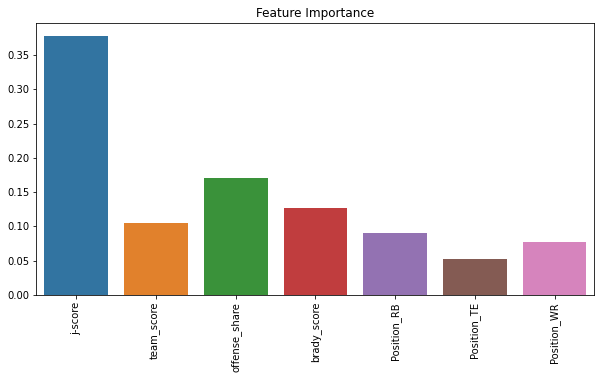

In [49]:
features = ['j-score', 'team_score', 'offense_share', 'brady_score',
       'Position_RB', 'Position_TE', 'Position_WR']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=reg_xgb.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [50]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [51]:
eval_set = [(X_test, y_test)]

In [52]:
gsearch1 = GridSearchCV(estimator = reg_xgb, param_grid = param_grid
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-rmse:121.58753
[1]	validation_0-rmse:112.04164
[2]	validation_0-rmse:103.50666
[3]	validation_0-rmse:96.20299
[4]	validation_0-rmse:90.01901
[5]	validation_0-rmse:84.64793
[6]	validation_0-rmse:80.10737
[7]	validation_0-rmse:76.44827
[8]	validation_0-rmse:73.45160
[9]	validation_0-rmse:70.71898
[10]	validation_0-rmse:68.60266
[11]	validation_0-rmse:66.91052
[12]	validation_0-rmse:65.53164
[13]	validation_0-rmse:64.32991
[14]	validation_0-rmse:63.44018
[15]	validation_0-rmse:62.72995
[16]	validation_0-rmse:62.21022
[17]	validation_0-rmse:61.79254
[18]	validation_0-rmse:61.46069
[19]	validation_0-rmse:61.21692
[20]	validation_0-rmse:61.10006
[21]	validation_0-rmse:60.99729
[22]	validation_0-rmse:60.95878
[23]	validation_0-rmse:60.88215
[0]	validation_0-rmse:121.37792
[1]	validation_0-rmse:111.70142
[2]	validation_0-rmse:103.14389
[3]	validation_0-rmse:95.84941
[4]	validation_0-rmse:89.35683
[24]	validation_0-

[31]	validation_0-rmse:61.34778
[95]	validation_0-rmse:63.66074
[32]	validation_0-rmse:61.40777
[96]	validation_0-rmse:63.66805
[33]	validation_0-rmse:61.52150
[31]	validation_0-rmse:59.48307
[97]	validation_0-rmse:63.60644
[34]	validation_0-rmse:61.70133
[98]	validation_0-rmse:63.67325
[32]	validation_0-rmse:59.46039
[16]	validation_0-rmse:62.44600
[35]	validation_0-rmse:61.68732
[99]	validation_0-rmse:63.69292
[33]	validation_0-rmse:59.53081
[17]	validation_0-rmse:61.99670
[36]	validation_0-rmse:61.81265
[18]	validation_0-rmse:61.77307
[37]	validation_0-rmse:61.80305
[19]	validation_0-rmse:61.63786
[20]	validation_0-rmse:61.48367
[38]	validation_0-rmse:61.96387
[21]	validation_0-rmse:61.28826
[22]	validation_0-rmse:61.26399
[34]	validation_0-rmse:59.56535
[23]	validation_0-rmse:61.21725
[35]	validation_0-rmse:59.57334
[36]	validation_0-rmse:59.66608
[37]	validation_0-rmse:59.67652
[67]	validation_0-rmse:62.94379
[68]	validation_0-rmse:62.94051
[69]	validation_0-rmse:62.95254
[70]	val

[84]	validation_0-rmse:60.82673
[85]	validation_0-rmse:60.86289
[85]	validation_0-rmse:60.86289
[86]	validation_0-rmse:60.87887
[86]	validation_0-rmse:60.87887
[87]	validation_0-rmse:60.91768
[87]	validation_0-rmse:60.91768
[88]	validation_0-rmse:60.90413
[88]	validation_0-rmse:60.90413
[89]	validation_0-rmse:60.91819
[89]	validation_0-rmse:60.91819
[90]	validation_0-rmse:60.96904
[91]	validation_0-rmse:60.99863
[92]	validation_0-rmse:61.06105
[93]	validation_0-rmse:61.11264
[43]	validation_0-rmse:62.08986
[94]	validation_0-rmse:61.17021
[44]	validation_0-rmse:62.12936
[45]	validation_0-rmse:62.17063
[46]	validation_0-rmse:62.20789
[47]	validation_0-rmse:62.23695
[99]	validation_0-rmse:63.69292
[48]	validation_0-rmse:62.25102
[95]	validation_0-rmse:63.49343
[49]	validation_0-rmse:62.31369
[50]	validation_0-rmse:62.38179
[51]	validation_0-rmse:62.43147
[96]	validation_0-rmse:63.50427
[78]	validation_0-rmse:63.19253
[52]	validation_0-rmse:62.45095
[79]	validation_0-rmse:63.19529
[53]	val

[10]	validation_0-rmse:68.18309
[68]	validation_0-rmse:60.71063
[69]	validation_0-rmse:60.73018
[27]	validation_0-rmse:60.92141
[28]	validation_0-rmse:60.98200
[70]	validation_0-rmse:60.77812
[29]	validation_0-rmse:60.93073
[71]	validation_0-rmse:60.80658
[30]	validation_0-rmse:60.94488
[72]	validation_0-rmse:60.86836
[73]	validation_0-rmse:60.88616
[74]	validation_0-rmse:60.92976
[31]	validation_0-rmse:60.88078
[32]	validation_0-rmse:60.94525
[41]	validation_0-rmse:61.35790
[42]	validation_0-rmse:61.39322
[43]	validation_0-rmse:61.40957
[3]	validation_0-rmse:96.57961
[44]	validation_0-rmse:61.44424
[4]	validation_0-rmse:90.35411
[45]	validation_0-rmse:61.42335
[5]	validation_0-rmse:84.95373
[11]	validation_0-rmse:66.33105
[6]	validation_0-rmse:80.39983
[46]	validation_0-rmse:61.47646
[7]	validation_0-rmse:76.60453
[47]	validation_0-rmse:61.46241
[48]	validation_0-rmse:61.49097
[8]	validation_0-rmse:73.42430
[9]	validation_0-rmse:70.79367
[12]	validation_0-rmse:64.86591
[13]	validation

[95]	validation_0-rmse:62.25536
[96]	validation_0-rmse:62.30767
[97]	validation_0-rmse:62.37491
[38]	validation_0-rmse:61.31411
[49]	validation_0-rmse:61.49447
[98]	validation_0-rmse:62.44837
[39]	validation_0-rmse:61.31229
[40]	validation_0-rmse:61.33315
[41]	validation_0-rmse:61.35790
[50]	validation_0-rmse:61.56797
[51]	validation_0-rmse:61.58969
[52]	validation_0-rmse:61.61566
[57]	validation_0-rmse:60.46058
[53]	validation_0-rmse:61.64580
[58]	validation_0-rmse:60.53787
[54]	validation_0-rmse:61.66127
[59]	validation_0-rmse:60.58853
[55]	validation_0-rmse:61.68532
[60]	validation_0-rmse:60.62754
[56]	validation_0-rmse:61.68713
[61]	validation_0-rmse:60.61712
[62]	validation_0-rmse:60.62528
[42]	validation_0-rmse:60.09637
[4]	validation_0-rmse:93.91036
[63]	validation_0-rmse:60.67639
[43]	validation_0-rmse:60.20032
[5]	validation_0-rmse:88.74940
[64]	validation_0-rmse:60.67174
[44]	validation_0-rmse:60.18267
[6]	validation_0-rmse:84.39196
[45]	validation_0-rmse:60.20059
[43]	valida

[86]	validation_0-rmse:61.12436
[25]	validation_0-rmse:59.44675
[85]	validation_0-rmse:62.04906
[26]	validation_0-rmse:59.35308
[74]	validation_0-rmse:60.92976
[86]	validation_0-rmse:62.04743
[87]	validation_0-rmse:62.14466
[75]	validation_0-rmse:60.95183
[27]	validation_0-rmse:59.32831
[88]	validation_0-rmse:62.12784
[76]	validation_0-rmse:60.95200
[89]	validation_0-rmse:62.13128
[90]	validation_0-rmse:62.20360
[77]	validation_0-rmse:61.03525
[28]	validation_0-rmse:59.30130
[91]	validation_0-rmse:62.24613
[92]	validation_0-rmse:62.15475
[87]	validation_0-rmse:61.16647
[93]	validation_0-rmse:62.25829
[88]	validation_0-rmse:61.22115
[94]	validation_0-rmse:62.27873
[89]	validation_0-rmse:61.25980
[95]	validation_0-rmse:62.25536
[96]	validation_0-rmse:62.30767
[90]	validation_0-rmse:61.31788
[97]	validation_0-rmse:62.37491
[91]	validation_0-rmse:61.34013
[74]	validation_0-rmse:62.77891
[29]	validation_0-rmse:59.32064
[92]	validation_0-rmse:61.35205
[75]	validation_0-rmse:62.79579
[30]	val

[11]	validation_0-rmse:68.95411
[54]	validation_0-rmse:61.49813
[12]	validation_0-rmse:67.26116
[55]	validation_0-rmse:61.58499
[69]	validation_0-rmse:61.70378
[13]	validation_0-rmse:65.79113
[70]	validation_0-rmse:61.69754
[14]	validation_0-rmse:64.63737
[56]	validation_0-rmse:61.65204
[28]	validation_0-rmse:60.47929
[57]	validation_0-rmse:61.70398
[26]	validation_0-rmse:59.35308
[27]	validation_0-rmse:59.32831
[29]	validation_0-rmse:60.45290
[28]	validation_0-rmse:59.30130
[58]	validation_0-rmse:61.74968
[30]	validation_0-rmse:60.49175
[15]	validation_0-rmse:63.67103
[29]	validation_0-rmse:59.32064
[30]	validation_0-rmse:59.31938
[31]	validation_0-rmse:59.31766
[20]	validation_0-rmse:60.26866
[21]	validation_0-rmse:59.95772
[22]	validation_0-rmse:59.73514
[23]	validation_0-rmse:59.60375
[24]	validation_0-rmse:59.50683
[25]	validation_0-rmse:59.44675
[33]	validation_0-rmse:60.57914
[71]	validation_0-rmse:61.69213
[59]	validation_0-rmse:61.80561
[34]	validation_0-rmse:60.65036
[35]	val

[31]	validation_0-rmse:61.53265
[84]	validation_0-rmse:60.85029
[81]	validation_0-rmse:62.37902
[82]	validation_0-rmse:62.40713
[71]	validation_0-rmse:60.68932
[72]	validation_0-rmse:60.72150
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-rmse:121.50423
[73]	validation_0-rmse:60.77948
[1]	validation_0-rmse:111.80197
[2]	validation_0-rmse:103.27576
[74]	validation_0-rmse:60.79663
[75]	validation_0-rmse:60.77369
[67]	validation_0-rmse:61.71682
[68]	validation_0-rmse:61.71254
[69]	validation_0-rmse:61.70378
[70]	validation_0-rmse:61.69754
[71]	validation_0-rmse:61.69213
[72]	validation_0-rmse:61.70049
[73]	validation_0-rmse:61.72400
[74]	validation_0-rmse:61.72263
[85]	validation_0-rmse:60.84854
[86]	validation_0-rmse:60.86452
[83]	validation_0-rmse:62.41099
[87]	validation_0-rmse:60.89993
[84]	validation_0-rmse:62.45342
[32]	validation_0-rmse:61.58131
[85]	validation_0-rmse:62.44406
[88]	validation_0-rmse:60.8844

[52]	validation_0-rmse:61.02392
[53]	validation_0-rmse:61.14490
[85]	validation_0-rmse:64.16436
[2]	validation_0-rmse:103.27576
[86]	validation_0-rmse:64.14113
[3]	validation_0-rmse:95.57622
[4]	validation_0-rmse:89.46778
[87]	validation_0-rmse:64.24442
[5]	validation_0-rmse:84.08079
[6]	validation_0-rmse:79.72521
[88]	validation_0-rmse:64.37922
[23]	validation_0-rmse:61.28717
[89]	validation_0-rmse:64.37449
[7]	validation_0-rmse:75.91481
[90]	validation_0-rmse:64.42604
[8]	validation_0-rmse:72.66871
[9]	validation_0-rmse:69.98000
[24]	validation_0-rmse:61.24498
[25]	validation_0-rmse:61.35436
[26]	validation_0-rmse:61.33955
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-rmse:121.42718
[31]	validation_0-rmse:62.82389
[27]	validation_0-rmse:61.33167
[32]	validation_0-rmse:62.96934
[1]	validation_0-rmse:111.44480
[28]	validation_0-rmse:61.38355
[33]	validation_0-rmse:63.09109
[54]	validation_0-rmse:61.12604
[34]	

[48]	validation_0-rmse:62.65828
[39]	validation_0-rmse:63.39088
[44]	validation_0-rmse:60.55859
[40]	validation_0-rmse:63.42696
[51]	validation_0-rmse:60.86555
[45]	validation_0-rmse:60.54879
[41]	validation_0-rmse:63.48092
[72]	validation_0-rmse:63.52155
[42]	validation_0-rmse:63.51305
[43]	validation_0-rmse:63.56661
[46]	validation_0-rmse:60.55891
[47]	validation_0-rmse:60.62611
[48]	validation_0-rmse:60.67170
[82]	validation_0-rmse:64.63338
[52]	validation_0-rmse:61.02392
[41]	validation_0-rmse:63.48092
[83]	validation_0-rmse:64.62670
[42]	validation_0-rmse:63.51305
[53]	validation_0-rmse:61.14490
[84]	validation_0-rmse:64.66494
[43]	validation_0-rmse:63.56661
[44]	validation_0-rmse:63.58896
[54]	validation_0-rmse:61.12604
[85]	validation_0-rmse:64.72985
[73]	validation_0-rmse:63.53876
[45]	validation_0-rmse:63.54389
[55]	validation_0-rmse:61.19751
[86]	validation_0-rmse:64.75207
[74]	validation_0-rmse:63.65496
[46]	validation_0-rmse:63.69964
[56]	validation_0-rmse:61.20730
[87]	val

[50]	validation_0-rmse:62.07893
[51]	validation_0-rmse:62.16792
[52]	validation_0-rmse:62.23452
[53]	validation_0-rmse:62.26024
[54]	validation_0-rmse:62.35179
[55]	validation_0-rmse:62.37985
[9]	validation_0-rmse:72.17585
[14]	validation_0-rmse:63.83404
[15]	validation_0-rmse:63.23984
[10]	validation_0-rmse:69.98560
[11]	validation_0-rmse:68.23872
[12]	validation_0-rmse:66.65436
[16]	validation_0-rmse:62.72683
[13]	validation_0-rmse:65.52713
[17]	validation_0-rmse:62.49206
[96]	validation_0-rmse:65.00294
[14]	validation_0-rmse:64.67664
[18]	validation_0-rmse:62.14738
[24]	validation_0-rmse:59.93534
[97]	validation_0-rmse:65.03891
[25]	validation_0-rmse:59.86401
[15]	validation_0-rmse:63.91453
[98]	validation_0-rmse:65.11797
[26]	validation_0-rmse:59.71292
[99]	validation_0-rmse:65.11674
[27]	validation_0-rmse:59.70122
[28]	validation_0-rmse:59.70073
[29]	validation_0-rmse:59.70405
[30]	validation_0-rmse:59.82158
[31]	validation_0-rmse:59.88954
[32]	validation_0-rmse:59.89776
[33]	vali

[43]	validation_0-rmse:62.31368
[43]	validation_0-rmse:60.17166
[44]	validation_0-rmse:62.35875
[44]	validation_0-rmse:60.20375
[86]	validation_0-rmse:61.27889
[45]	validation_0-rmse:62.39749
[45]	validation_0-rmse:60.28434
[46]	validation_0-rmse:60.32536
[47]	validation_0-rmse:60.30545
[46]	validation_0-rmse:62.27064
[48]	validation_0-rmse:60.35454
[49]	validation_0-rmse:60.40062
[47]	validation_0-rmse:62.34694
[50]	validation_0-rmse:60.46076
[48]	validation_0-rmse:62.33777
[49]	validation_0-rmse:62.37066
[78]	validation_0-rmse:62.97148
[51]	validation_0-rmse:60.44497
[50]	validation_0-rmse:62.42930
[79]	validation_0-rmse:62.99024
[87]	validation_0-rmse:61.28036
[52]	validation_0-rmse:60.46107
[51]	validation_0-rmse:62.50946
[80]	validation_0-rmse:62.93328
[72]	validation_0-rmse:62.90103
[88]	validation_0-rmse:61.29960
[53]	validation_0-rmse:60.44820
[73]	validation_0-rmse:62.91755
[54]	validation_0-rmse:60.45107
[89]	validation_0-rmse:61.31556
[74]	validation_0-rmse:62.94679
[55]	val

[97]	validation_0-rmse:62.94010
[98]	validation_0-rmse:62.94886
[99]	validation_0-rmse:62.90100
[53]	validation_0-rmse:62.47629
[97]	validation_0-rmse:61.55830
[54]	validation_0-rmse:62.47285
[55]	validation_0-rmse:62.55720
[56]	validation_0-rmse:62.62790
[89]	validation_0-rmse:63.02732
[98]	validation_0-rmse:61.57035
[99]	validation_0-rmse:61.59055
[90]	validation_0-rmse:63.07640
[57]	validation_0-rmse:62.63953
[91]	validation_0-rmse:63.09325
[94]	validation_0-rmse:63.32169
[58]	validation_0-rmse:62.61584
[92]	validation_0-rmse:63.26224
[95]	validation_0-rmse:63.38589
[59]	validation_0-rmse:62.58983
[93]	validation_0-rmse:63.26975
[60]	validation_0-rmse:62.63156
[96]	validation_0-rmse:63.41582
[94]	validation_0-rmse:63.32169
[61]	validation_0-rmse:62.61058
[97]	validation_0-rmse:63.45219
[98]	validation_0-rmse:63.45288
[62]	validation_0-rmse:62.68442
[99]	validation_0-rmse:63.45603
[11]	validation_0-rmse:68.50975
[12]	validation_0-rmse:66.81931
[13]	validation_0-rmse:65.45040
[14]	val

[12]	validation_0-rmse:68.25599
[18]	validation_0-rmse:61.12046
[2]	validation_0-rmse:106.14767
[13]	validation_0-rmse:66.85677
[3]	validation_0-rmse:99.42474
[4]	validation_0-rmse:93.42053
[14]	validation_0-rmse:65.56864
[15]	validation_0-rmse:64.47173
[5]	validation_0-rmse:88.21110
[6]	validation_0-rmse:83.80568
[16]	validation_0-rmse:63.71278
[7]	validation_0-rmse:79.99689
[8]	validation_0-rmse:76.53869
[9]	validation_0-rmse:73.61492
[36]	validation_0-rmse:61.41402
[10]	validation_0-rmse:71.12354
[65]	validation_0-rmse:60.70811
[8]	validation_0-rmse:76.53869
[37]	validation_0-rmse:61.38266
[11]	validation_0-rmse:69.18225
[66]	validation_0-rmse:60.74448
[38]	validation_0-rmse:61.50483
[9]	validation_0-rmse:73.61492
[12]	validation_0-rmse:67.53419
[67]	validation_0-rmse:60.75036
[10]	validation_0-rmse:71.12354
[68]	validation_0-rmse:60.74240
[13]	validation_0-rmse:66.14443
[11]	validation_0-rmse:69.18225
[39]	validation_0-rmse:61.49628
[12]	validation_0-rmse:67.53419
[69]	validation_0

[71]	validation_0-rmse:62.84553
[71]	validation_0-rmse:63.39898
[72]	validation_0-rmse:63.36405
[73]	validation_0-rmse:63.34999
[79]	validation_0-rmse:60.90444
[74]	validation_0-rmse:63.32124
[72]	validation_0-rmse:62.88697
[80]	validation_0-rmse:60.90128
[22]	validation_0-rmse:62.18157
[81]	validation_0-rmse:60.92880
[63]	validation_0-rmse:63.25944
[23]	validation_0-rmse:62.28766
[82]	validation_0-rmse:60.91714
[64]	validation_0-rmse:63.33671
[24]	validation_0-rmse:62.22580
[65]	validation_0-rmse:63.42252
[83]	validation_0-rmse:60.94088
[84]	validation_0-rmse:60.95141
[66]	validation_0-rmse:63.35695
[25]	validation_0-rmse:62.18969
[26]	validation_0-rmse:62.13584
[67]	validation_0-rmse:63.37672
[70]	validation_0-rmse:60.78930
[68]	validation_0-rmse:63.36834
[71]	validation_0-rmse:60.81222
[98]	validation_0-rmse:63.19618
[72]	validation_0-rmse:60.81794
[99]	validation_0-rmse:63.16217
[73]	validation_0-rmse:60.80555
[74]	validation_0-rmse:60.79877
[75]	validation_0-rmse:60.81145
[69]	val

[40]	validation_0-rmse:64.43441
[38]	validation_0-rmse:62.73123
[10]	validation_0-rmse:68.39984
[18]	validation_0-rmse:61.34063
[41]	validation_0-rmse:64.52140
[39]	validation_0-rmse:62.77342
[11]	validation_0-rmse:66.95820
[19]	validation_0-rmse:61.10661
[42]	validation_0-rmse:64.39521
[40]	validation_0-rmse:62.85927
[20]	validation_0-rmse:60.86665
[80]	validation_0-rmse:64.33042
[21]	validation_0-rmse:60.69966
[40]	validation_0-rmse:60.68736
[22]	validation_0-rmse:60.39054
[8]	validation_0-rmse:74.22088
[41]	validation_0-rmse:60.84356
[23]	validation_0-rmse:60.20696
[14]	validation_0-rmse:64.27241
[24]	validation_0-rmse:60.18723
[15]	validation_0-rmse:63.67089
[25]	validation_0-rmse:60.08510
[16]	validation_0-rmse:63.30376
[26]	validation_0-rmse:60.12169
[17]	validation_0-rmse:62.98011
[27]	validation_0-rmse:60.20248
[18]	validation_0-rmse:62.63570
[9]	validation_0-rmse:71.85675
[42]	validation_0-rmse:60.82847
[10]	validation_0-rmse:69.85786
[11]	validation_0-rmse:68.02765
[43]	valid

[70]	validation_0-rmse:62.95469
[60]	validation_0-rmse:63.98085
[82]	validation_0-rmse:64.34815
[88]	validation_0-rmse:65.36610
[71]	validation_0-rmse:62.92471
[83]	validation_0-rmse:64.38246
[89]	validation_0-rmse:65.34045
[72]	validation_0-rmse:63.03254
[73]	validation_0-rmse:62.99187
[84]	validation_0-rmse:64.46462
[61]	validation_0-rmse:63.98839
[74]	validation_0-rmse:63.08729
[75]	validation_0-rmse:63.06359
[85]	validation_0-rmse:64.39542
[76]	validation_0-rmse:63.15087
[77]	validation_0-rmse:63.22148
[78]	validation_0-rmse:63.17802
[62]	validation_0-rmse:64.05768
[53]	validation_0-rmse:64.58355
[63]	validation_0-rmse:64.04513
[54]	validation_0-rmse:64.61799
[86]	validation_0-rmse:64.43226
[64]	validation_0-rmse:64.16170
[55]	validation_0-rmse:64.65891
[87]	validation_0-rmse:64.41979
[59]	validation_0-rmse:64.84095
[65]	validation_0-rmse:64.23382
[88]	validation_0-rmse:64.44549
[56]	validation_0-rmse:64.75006
[66]	validation_0-rmse:64.21598
[60]	validation_0-rmse:64.65686
[89]	val

[62]	validation_0-rmse:64.49866
[3]	validation_0-rmse:97.04009
[63]	validation_0-rmse:64.51845
[4]	validation_0-rmse:91.27380
[5]	validation_0-rmse:85.94670
[6]	validation_0-rmse:81.49833
[25]	validation_0-rmse:60.31823
[26]	validation_0-rmse:60.26001
[27]	validation_0-rmse:60.30139
[28]	validation_0-rmse:60.21138
[64]	validation_0-rmse:64.47809
[7]	validation_0-rmse:78.06805
[65]	validation_0-rmse:64.52758
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-rmse:121.95718
[66]	validation_0-rmse:64.58660
[8]	validation_0-rmse:74.99585
[1]	validation_0-rmse:112.95481
[2]	validation_0-rmse:105.05275
[3]	validation_0-rmse:98.08870
[9]	validation_0-rmse:72.52672
[10]	validation_0-rmse:70.38455
[11]	validation_0-rmse:68.67580
[29]	validation_0-rmse:60.17085
[67]	validation_0-rmse:64.66143
[30]	validation_0-rmse:60.19883
[68]	validation_0-rmse:64.72873
[12]	validation_0-rmse:67.19002
[31]	validation_0-rmse:60.11923
[13]	vali

[30]	validation_0-rmse:63.36647
[20]	validation_0-rmse:63.29447
[21]	validation_0-rmse:63.07715
[28]	validation_0-rmse:60.21138
[22]	validation_0-rmse:62.92344
[32]	validation_0-rmse:60.20337
[75]	validation_0-rmse:61.58974
[33]	validation_0-rmse:60.28881
[76]	validation_0-rmse:61.59572
[34]	validation_0-rmse:60.24612
[77]	validation_0-rmse:61.64060
[35]	validation_0-rmse:60.28966
[78]	validation_0-rmse:61.60726
[79]	validation_0-rmse:61.59066
[36]	validation_0-rmse:60.28401
[63]	validation_0-rmse:65.02436
[37]	validation_0-rmse:60.35485
[64]	validation_0-rmse:65.04001
[38]	validation_0-rmse:60.37546
[65]	validation_0-rmse:65.11829
[39]	validation_0-rmse:60.41951
[66]	validation_0-rmse:65.16904
[40]	validation_0-rmse:60.45602
[28]	validation_0-rmse:62.87222
[67]	validation_0-rmse:65.18265
[49]	validation_0-rmse:64.19491
[29]	validation_0-rmse:62.97525
[30]	validation_0-rmse:62.98298
[50]	validation_0-rmse:64.19461
[51]	validation_0-rmse:64.24684
[31]	validation_0-rmse:62.99889
[23]	val

[82]	validation_0-rmse:61.72249
[87]	validation_0-rmse:61.76980
[83]	validation_0-rmse:61.70126
[87]	validation_0-rmse:65.47936
[88]	validation_0-rmse:65.48499
[84]	validation_0-rmse:61.77831
[85]	validation_0-rmse:61.80901
[86]	validation_0-rmse:61.78982
[2]	validation_0-rmse:105.54288
[89]	validation_0-rmse:65.50009
[3]	validation_0-rmse:98.74794
[4]	validation_0-rmse:92.72876
[5]	validation_0-rmse:87.64195
[82]	validation_0-rmse:64.94334
[83]	validation_0-rmse:64.95464
[84]	validation_0-rmse:64.98581
[6]	validation_0-rmse:81.09507
[7]	validation_0-rmse:77.32334
[85]	validation_0-rmse:64.91296
[8]	validation_0-rmse:74.16460
[86]	validation_0-rmse:64.91939
[79]	validation_0-rmse:65.44247
[9]	validation_0-rmse:71.56798
[10]	validation_0-rmse:69.36970
[88]	validation_0-rmse:61.89261
[34]	validation_0-rmse:61.42759
[11]	validation_0-rmse:67.51864
[12]	validation_0-rmse:66.09679
[89]	validation_0-rmse:61.94795
[13]	validation_0-rmse:64.87840
[90]	validation_0-rmse:61.90534
[35]	validation

[24]	validation_0-rmse:61.52465
[18]	validation_0-rmse:62.85618
[35]	validation_0-rmse:59.91185
[25]	validation_0-rmse:61.44171
[36]	validation_0-rmse:59.96899
[19]	validation_0-rmse:62.51637
[20]	validation_0-rmse:62.26254
[21]	validation_0-rmse:61.92534
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.8s
[0]	validation_0-rmse:122.77473
[22]	validation_0-rmse:61.71469
[1]	validation_0-rmse:114.11926
[4]	validation_0-rmse:92.72876
[2]	validation_0-rmse:106.54837
[5]	validation_0-rmse:87.64195
[6]	validation_0-rmse:83.22443
[4]	validation_0-rmse:93.41808
[3]	validation_0-rmse:99.89857
[68]	validation_0-rmse:63.29915
[5]	validation_0-rmse:88.27824
[7]	validation_0-rmse:79.21217
[6]	validation_0-rmse:83.81083
[8]	validation_0-rmse:75.93226
[69]	validation_0-rmse:63.35038
[7]	validation_0-rmse:79.86624
[70]	validation_0-rmse:63.32820
[8]	validation_0-rmse:76.50456
[71]	validation_0-rmse:63.37222
[9]	validation_0-rmse:73.59351
[72]	valida

[61]	validation_0-rmse:62.77256
[5]	validation_0-rmse:126.03591
[55]	validation_0-rmse:62.75314
[62]	validation_0-rmse:62.83074
[6]	validation_0-rmse:125.02860
[7]	validation_0-rmse:124.02001
[8]	validation_0-rmse:123.02528
[9]	validation_0-rmse:122.01423
[10]	validation_0-rmse:121.03945
[79]	validation_0-rmse:62.84806
[11]	validation_0-rmse:120.04875
[80]	validation_0-rmse:62.80783
[63]	validation_0-rmse:61.05011
[81]	validation_0-rmse:62.83276
[64]	validation_0-rmse:61.08856
[65]	validation_0-rmse:61.10825
[66]	validation_0-rmse:61.14518
[82]	validation_0-rmse:62.87093
[67]	validation_0-rmse:61.18607
[83]	validation_0-rmse:62.87902
[51]	validation_0-rmse:62.65256
[77]	validation_0-rmse:63.44265
[12]	validation_0-rmse:119.09917
[78]	validation_0-rmse:63.42035
[52]	validation_0-rmse:62.67642
[13]	validation_0-rmse:118.13358
[79]	validation_0-rmse:63.41794
[14]	validation_0-rmse:117.18560
[53]	validation_0-rmse:62.69745
[57]	validation_0-rmse:60.81002
[15]	validation_0-rmse:116.27181
[8

[79]	validation_0-rmse:77.78481
[80]	validation_0-rmse:77.44017
[81]	validation_0-rmse:77.10374
[82]	validation_0-rmse:76.76438
[83]	validation_0-rmse:76.43568
[84]	validation_0-rmse:76.11935
[85]	validation_0-rmse:75.80330
[86]	validation_0-rmse:75.49553
[87]	validation_0-rmse:75.17865
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.9s
[0]	validation_0-rmse:131.33900
[88]	validation_0-rmse:74.88727
[1]	validation_0-rmse:130.25368
[89]	validation_0-rmse:74.59337
[2]	validation_0-rmse:129.18250
[90]	validation_0-rmse:74.30735
[3]	validation_0-rmse:128.12090
[47]	validation_0-rmse:91.93869
[48]	validation_0-rmse:91.34489
[4]	validation_0-rmse:127.07339
[49]	validation_0-rmse:90.75296
[50]	validation_0-rmse:90.16993
[51]	validation_0-rmse:89.59760
[18]	validation_0-rmse:113.47340
[52]	validation_0-rmse:89.03474
[19]	validation_0-rmse:112.59660
[53]	validation_0-rmse:88.48761
[20]	validation_0-rmse:111.71933
[21]	validation_0-rmse:110.

[28]	validation_0-rmse:105.18509
[16]	validation_0-rmse:115.34815
[29]	validation_0-rmse:104.40804
[30]	validation_0-rmse:103.65367
[31]	validation_0-rmse:102.90214
[17]	validation_0-rmse:114.37405
[41]	validation_0-rmse:95.68108
[17]	validation_0-rmse:114.45802
[32]	validation_0-rmse:102.16495
[42]	validation_0-rmse:95.04161
[18]	validation_0-rmse:113.55362
[18]	validation_0-rmse:113.47340
[67]	validation_0-rmse:82.36572
[43]	validation_0-rmse:94.39722
[19]	validation_0-rmse:112.68664
[19]	validation_0-rmse:112.59660
[68]	validation_0-rmse:81.94447
[44]	validation_0-rmse:93.78117
[20]	validation_0-rmse:111.81333
[45]	validation_0-rmse:93.16091
[21]	validation_0-rmse:110.96938
[46]	validation_0-rmse:92.55518
[22]	validation_0-rmse:110.11189
[47]	validation_0-rmse:91.93869
[20]	validation_0-rmse:111.71933
[69]	validation_0-rmse:81.54080
[70]	validation_0-rmse:81.13447
[21]	validation_0-rmse:110.86960
[71]	validation_0-rmse:80.74567
[22]	validation_0-rmse:110.02495
[72]	validation_0-rmse

[20]	validation_0-rmse:112.04098
[51]	validation_0-rmse:90.07415
[52]	validation_0-rmse:89.52497
[21]	validation_0-rmse:111.19257
[22]	validation_0-rmse:110.37523
[23]	validation_0-rmse:109.56050
[95]	validation_0-rmse:72.94232
[96]	validation_0-rmse:72.67926
[52]	validation_0-rmse:89.56556
[97]	validation_0-rmse:72.42261
[98]	validation_0-rmse:72.17313
[99]	validation_0-rmse:71.93595
[53]	validation_0-rmse:89.01808
[46]	validation_0-rmse:93.84187
[54]	validation_0-rmse:88.48912
[24]	validation_0-rmse:108.57566
[47]	validation_0-rmse:93.26059
[55]	validation_0-rmse:87.96458
[25]	validation_0-rmse:107.77506
[56]	validation_0-rmse:87.45184
[26]	validation_0-rmse:106.98110
[57]	validation_0-rmse:86.95873
[27]	validation_0-rmse:106.19582
[48]	validation_0-rmse:92.68347
[28]	validation_0-rmse:105.41845
[29]	validation_0-rmse:104.64113
[49]	validation_0-rmse:92.11981
[77]	validation_0-rmse:77.66252
[66]	validation_0-rmse:82.74007
[30]	validation_0-rmse:103.88416
[50]	validation_0-rmse:91.558

[80]	validation_0-rmse:78.24649
[91]	validation_0-rmse:74.02386
[88]	validation_0-rmse:74.00039
[81]	validation_0-rmse:77.91393
[92]	validation_0-rmse:73.74868
[89]	validation_0-rmse:73.70385
[82]	validation_0-rmse:77.57384
[93]	validation_0-rmse:73.46377
[90]	validation_0-rmse:73.41428
[83]	validation_0-rmse:77.25280
[94]	validation_0-rmse:73.19139
[91]	validation_0-rmse:73.12521
[84]	validation_0-rmse:76.92277
[92]	validation_0-rmse:72.84684
[98]	validation_0-rmse:72.05983
[93]	validation_0-rmse:72.57099
[99]	validation_0-rmse:71.80030
[94]	validation_0-rmse:72.29042
[11]	validation_0-rmse:120.25264
[54]	validation_0-rmse:88.89468
[12]	validation_0-rmse:119.31713
[13]	validation_0-rmse:118.39537
[55]	validation_0-rmse:88.36803
[83]	validation_0-rmse:76.31026
[56]	validation_0-rmse:87.85944
[14]	validation_0-rmse:117.47915
[57]	validation_0-rmse:87.34057
[84]	validation_0-rmse:75.98289
[15]	validation_0-rmse:116.57914
[58]	validation_0-rmse:86.83721
[85]	validation_0-rmse:75.68272
[16

[24]	validation_0-rmse:108.74923
[38]	validation_0-rmse:98.17458
[2]	validation_0-rmse:129.16520
[6]	validation_0-rmse:124.98304
[25]	validation_0-rmse:107.95917
[39]	validation_0-rmse:97.50852
[3]	validation_0-rmse:128.11362
[7]	validation_0-rmse:123.96447
[26]	validation_0-rmse:107.17187
[4]	validation_0-rmse:127.06224
[8]	validation_0-rmse:122.96922
[40]	validation_0-rmse:96.84454
[5]	validation_0-rmse:126.03629
[41]	validation_0-rmse:96.20235
[6]	validation_0-rmse:125.02295
[7]	validation_0-rmse:124.00976
[42]	validation_0-rmse:95.55515
[8]	validation_0-rmse:123.02137
[9]	validation_0-rmse:122.04523
[9]	validation_0-rmse:121.97786
[12]	validation_0-rmse:119.31713
[10]	validation_0-rmse:121.00938
[13]	validation_0-rmse:118.39537
[11]	validation_0-rmse:120.04053
[14]	validation_0-rmse:117.47915
[15]	validation_0-rmse:116.57914
[16]	validation_0-rmse:115.68443
[17]	validation_0-rmse:114.80944
[10]	validation_0-rmse:121.06598
[11]	validation_0-rmse:120.11093
[CV] END gamma=0, learning_

[40]	validation_0-rmse:98.99426
[41]	validation_0-rmse:98.37547
[68]	validation_0-rmse:82.24251
[81]	validation_0-rmse:76.82425
[69]	validation_0-rmse:81.82900
[82]	validation_0-rmse:76.48191
[70]	validation_0-rmse:81.41479
[83]	validation_0-rmse:76.13386
[71]	validation_0-rmse:81.00733
[72]	validation_0-rmse:80.60832
[59]	validation_0-rmse:86.89528
[73]	validation_0-rmse:80.21724
[60]	validation_0-rmse:86.41506
[61]	validation_0-rmse:85.94557
[84]	validation_0-rmse:75.80652
[62]	validation_0-rmse:85.47894
[85]	validation_0-rmse:75.48670
[50]	validation_0-rmse:90.72322
[63]	validation_0-rmse:85.02014
[64]	validation_0-rmse:84.57568
[47]	validation_0-rmse:92.81319
[86]	validation_0-rmse:75.16833
[19]	validation_0-rmse:114.42984
[87]	validation_0-rmse:74.84647
[51]	validation_0-rmse:90.15724
[20]	validation_0-rmse:113.66043
[52]	validation_0-rmse:89.59688
[43]	validation_0-rmse:98.45263
[53]	validation_0-rmse:89.04160
[44]	validation_0-rmse:97.86544
[21]	validation_0-rmse:112.90082
[54]	

[28]	validation_0-rmse:107.11400
[8]	validation_0-rmse:123.74513
[29]	validation_0-rmse:106.38405
[9]	validation_0-rmse:122.83833
[10]	validation_0-rmse:121.93706
[11]	validation_0-rmse:121.05248
[30]	validation_0-rmse:105.67406
[12]	validation_0-rmse:120.17330
[31]	validation_0-rmse:104.96001
[13]	validation_0-rmse:119.31056
[32]	validation_0-rmse:104.26247
[14]	validation_0-rmse:118.48099
[15]	validation_0-rmse:117.66178
[16]	validation_0-rmse:116.82486
[17]	validation_0-rmse:116.02582
[51]	validation_0-rmse:94.00371
[52]	validation_0-rmse:93.49286
[93]	validation_0-rmse:76.31024
[53]	validation_0-rmse:92.97136
[94]	validation_0-rmse:76.00638
[54]	validation_0-rmse:92.45303
[95]	validation_0-rmse:75.71543
[55]	validation_0-rmse:91.94515
[56]	validation_0-rmse:91.46031
[96]	validation_0-rmse:75.42276
[97]	validation_0-rmse:75.12669
[98]	validation_0-rmse:74.85283
[33]	validation_0-rmse:103.57067
[34]	validation_0-rmse:102.89963
[35]	validation_0-rmse:102.22580
[36]	validation_0-rmse:1

[3]	validation_0-rmse:128.04214
[31]	validation_0-rmse:102.80958
[22]	validation_0-rmse:110.26829
[32]	validation_0-rmse:102.05003
[23]	validation_0-rmse:109.44151
[33]	validation_0-rmse:101.30064
[4]	validation_0-rmse:126.97406
[20]	validation_0-rmse:111.57196
[24]	validation_0-rmse:108.63633
[5]	validation_0-rmse:125.91555
[49]	validation_0-rmse:95.06523
[21]	validation_0-rmse:110.71486
[6]	validation_0-rmse:124.87890
[50]	validation_0-rmse:94.54071
[22]	validation_0-rmse:109.84167
[7]	validation_0-rmse:123.84766
[23]	validation_0-rmse:109.02706
[8]	validation_0-rmse:122.83901
[9]	validation_0-rmse:121.83451
[24]	validation_0-rmse:108.20400
[51]	validation_0-rmse:94.00371
[25]	validation_0-rmse:107.35875
[26]	validation_0-rmse:106.56519
[52]	validation_0-rmse:93.49286
[53]	validation_0-rmse:92.97136
[41]	validation_0-rmse:99.23896
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.7s
[0]	validation_0-rmse:131.33039
[42]	validation_

[38]	validation_0-rmse:97.65206
[49]	validation_0-rmse:91.45092
[31]	validation_0-rmse:102.80958
[39]	validation_0-rmse:96.95693
[32]	validation_0-rmse:102.05003
[53]	validation_0-rmse:88.69935
[54]	validation_0-rmse:88.15900
[55]	validation_0-rmse:87.62747
[56]	validation_0-rmse:87.10802
[57]	validation_0-rmse:86.60491
[84]	validation_0-rmse:79.92987
[85]	validation_0-rmse:79.58969
[86]	validation_0-rmse:79.26043
[87]	validation_0-rmse:78.93354
[88]	validation_0-rmse:78.61198
[89]	validation_0-rmse:78.29886
[56]	validation_0-rmse:86.93568
[90]	validation_0-rmse:77.98192
[57]	validation_0-rmse:86.43076
[58]	validation_0-rmse:85.91761
[91]	validation_0-rmse:77.66398
[86]	validation_0-rmse:77.72214
[59]	validation_0-rmse:85.43171
[92]	validation_0-rmse:77.35661
[93]	validation_0-rmse:77.05936
[87]	validation_0-rmse:77.39063
[60]	validation_0-rmse:84.93089
[94]	validation_0-rmse:76.76378
[88]	validation_0-rmse:77.07642
[50]	validation_0-rmse:90.88780
[95]	validation_0-rmse:76.46900
[89]	v

[44]	validation_0-rmse:93.78575
[28]	validation_0-rmse:105.12926
[29]	validation_0-rmse:104.34709
[45]	validation_0-rmse:93.18900
[30]	validation_0-rmse:103.56171
[46]	validation_0-rmse:92.56424
[31]	validation_0-rmse:102.80958
[47]	validation_0-rmse:91.97425
[48]	validation_0-rmse:91.37918
[32]	validation_0-rmse:102.05003
[49]	validation_0-rmse:90.80709
[33]	validation_0-rmse:101.30064
[15]	validation_0-rmse:116.73854
[51]	validation_0-rmse:90.34284
[52]	validation_0-rmse:89.79068
[16]	validation_0-rmse:115.85606
[53]	validation_0-rmse:89.24897
[17]	validation_0-rmse:114.98445
[54]	validation_0-rmse:88.70024
[28]	validation_0-rmse:105.48517
[55]	validation_0-rmse:88.18173
[29]	validation_0-rmse:104.72111
[56]	validation_0-rmse:87.65396
[30]	validation_0-rmse:103.98046
[18]	validation_0-rmse:114.13512
[57]	validation_0-rmse:87.14925
[19]	validation_0-rmse:113.29192
[31]	validation_0-rmse:103.23693
[58]	validation_0-rmse:86.64891
[87]	validation_0-rmse:74.33928
[20]	validation_0-rmse:11

[28]	validation_0-rmse:105.54269
[80]	validation_0-rmse:77.60767
[98]	validation_0-rmse:71.52132
[29]	validation_0-rmse:104.79616
[81]	validation_0-rmse:77.26662
[99]	validation_0-rmse:71.27698
[30]	validation_0-rmse:104.04337
[82]	validation_0-rmse:76.94819
[31]	validation_0-rmse:103.30519
[83]	validation_0-rmse:76.62813
[32]	validation_0-rmse:102.58832
[84]	validation_0-rmse:76.32265
[85]	validation_0-rmse:76.01424
[33]	validation_0-rmse:101.86658
[82]	validation_0-rmse:75.98468
[34]	validation_0-rmse:101.16612
[83]	validation_0-rmse:75.64773
[35]	validation_0-rmse:100.44985
[42]	validation_0-rmse:96.64362
[84]	validation_0-rmse:75.31499
[36]	validation_0-rmse:99.75481
[43]	validation_0-rmse:96.03233
[37]	validation_0-rmse:99.08409
[85]	validation_0-rmse:74.98315
[67]	validation_0-rmse:83.78956
[44]	validation_0-rmse:95.42975
[86]	validation_0-rmse:74.65842
[87]	validation_0-rmse:74.33928
[45]	validation_0-rmse:94.83086
[68]	validation_0-rmse:83.36884
[46]	validation_0-rmse:94.24209


[20]	validation_0-rmse:112.23113
[21]	validation_0-rmse:111.38617
[49]	validation_0-rmse:92.52526
[50]	validation_0-rmse:91.96608
[51]	validation_0-rmse:91.42963
[52]	validation_0-rmse:90.89492
[53]	validation_0-rmse:90.36203
[54]	validation_0-rmse:89.84456
[4]	validation_0-rmse:127.63856
[5]	validation_0-rmse:126.71711
[6]	validation_0-rmse:125.79152
[7]	validation_0-rmse:124.89203
[30]	validation_0-rmse:104.04337
[8]	validation_0-rmse:123.98845
[9]	validation_0-rmse:123.11052
[31]	validation_0-rmse:103.30519
[72]	validation_0-rmse:80.96013
[22]	validation_0-rmse:110.56392
[32]	validation_0-rmse:102.58832
[73]	validation_0-rmse:80.56329
[23]	validation_0-rmse:109.73752
[33]	validation_0-rmse:101.86658
[34]	validation_0-rmse:101.16612
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.9s
[0]	validation_0-rmse:131.42095
[74]	validation_0-rmse:80.17864
[35]	validation_0-rmse:100.44985
[1]	validation_0-rmse:130.41657
[75]	validation_0-rm

[35]	validation_0-rmse:102.30802
[7]	validation_0-rmse:124.89203
[36]	validation_0-rmse:101.64468
[8]	validation_0-rmse:123.98845
[37]	validation_0-rmse:100.98899
[58]	validation_0-rmse:90.60438
[38]	validation_0-rmse:100.34023
[30]	validation_0-rmse:106.76608
[75]	validation_0-rmse:79.80586
[39]	validation_0-rmse:99.70185
[31]	validation_0-rmse:106.08128
[76]	validation_0-rmse:79.43218
[59]	validation_0-rmse:90.11402
[40]	validation_0-rmse:99.07028
[32]	validation_0-rmse:105.40339
[77]	validation_0-rmse:79.07143
[60]	validation_0-rmse:89.64558
[41]	validation_0-rmse:98.44996
[54]	validation_0-rmse:91.12757
[33]	validation_0-rmse:104.73525
[61]	validation_0-rmse:89.18829
[78]	validation_0-rmse:78.72152
[55]	validation_0-rmse:90.62074
[62]	validation_0-rmse:88.73438
[34]	validation_0-rmse:104.08685
[35]	validation_0-rmse:103.43495
[56]	validation_0-rmse:90.11582
[79]	validation_0-rmse:78.37399
[57]	validation_0-rmse:89.60802
[80]	validation_0-rmse:78.02371
[58]	validation_0-rmse:89.1155

[73]	validation_0-rmse:82.47534
[50]	validation_0-rmse:94.05551
[93]	validation_0-rmse:75.57534
[74]	validation_0-rmse:82.08274
[94]	validation_0-rmse:75.29159
[51]	validation_0-rmse:93.51367
[95]	validation_0-rmse:74.99387
[52]	validation_0-rmse:92.99180
[96]	validation_0-rmse:74.71472
[95]	validation_0-rmse:76.69675
[97]	validation_0-rmse:74.42614
[96]	validation_0-rmse:76.41320
[97]	validation_0-rmse:76.13773
[98]	validation_0-rmse:75.85644
[71]	validation_0-rmse:84.89202
[72]	validation_0-rmse:84.49857
[99]	validation_0-rmse:75.58245
[73]	validation_0-rmse:84.10839
[74]	validation_0-rmse:83.72758
[11]	validation_0-rmse:120.97319
[71]	validation_0-rmse:84.19268
[12]	validation_0-rmse:120.09235
[72]	validation_0-rmse:83.78647
[13]	validation_0-rmse:119.20826
[14]	validation_0-rmse:118.32940
[15]	validation_0-rmse:117.46682
[47]	validation_0-rmse:96.21988
[16]	validation_0-rmse:116.62553
[48]	validation_0-rmse:95.67674
[73]	validation_0-rmse:83.39071
[2]	validation_0-rmse:129.44306
[1

[40]	validation_0-rmse:99.84102
[56]	validation_0-rmse:90.11582
[24]	validation_0-rmse:108.26305
[25]	validation_0-rmse:107.45728
[14]	validation_0-rmse:117.41033
[85]	validation_0-rmse:79.78335
[91]	validation_0-rmse:76.95456
[15]	validation_0-rmse:116.51405
[86]	validation_0-rmse:79.45211
[92]	validation_0-rmse:76.64875
[16]	validation_0-rmse:115.59711
[87]	validation_0-rmse:79.12397
[93]	validation_0-rmse:76.34206
[17]	validation_0-rmse:114.72219
[88]	validation_0-rmse:78.79851
[94]	validation_0-rmse:76.04113
[89]	validation_0-rmse:78.48254
[18]	validation_0-rmse:113.84807
[95]	validation_0-rmse:75.74601
[90]	validation_0-rmse:78.16433
[96]	validation_0-rmse:75.45850
[97]	validation_0-rmse:75.17242
[26]	validation_0-rmse:106.68226
[27]	validation_0-rmse:105.91199
[28]	validation_0-rmse:105.15418
[13]	validation_0-rmse:118.05595
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-rmse:131.32345
[29]	validation_0-

[60]	validation_0-rmse:85.65051
[72]	validation_0-rmse:83.78647
[61]	validation_0-rmse:85.19441
[62]	validation_0-rmse:84.74699
[73]	validation_0-rmse:83.39071
[63]	validation_0-rmse:84.29092
[74]	validation_0-rmse:82.98611
[64]	validation_0-rmse:83.82169
[75]	validation_0-rmse:82.59067
[65]	validation_0-rmse:83.36846
[76]	validation_0-rmse:82.20446
[66]	validation_0-rmse:82.92443
[77]	validation_0-rmse:81.81684
[21]	validation_0-rmse:111.01531
[44]	validation_0-rmse:94.30244
[23]	validation_0-rmse:109.07517
[22]	validation_0-rmse:110.17052
[45]	validation_0-rmse:93.70240
[24]	validation_0-rmse:108.26305
[23]	validation_0-rmse:109.34268
[7]	validation_0-rmse:123.81644
[46]	validation_0-rmse:93.10483
[25]	validation_0-rmse:107.45728
[24]	validation_0-rmse:108.52019
[8]	validation_0-rmse:122.78610
[47]	validation_0-rmse:92.49625
[26]	validation_0-rmse:106.68226
[25]	validation_0-rmse:107.72290
[9]	validation_0-rmse:121.80508
[48]	validation_0-rmse:91.91118
[27]	validation_0-rmse:105.9119

[43]	validation_0-rmse:94.93767
[81]	validation_0-rmse:77.01351
[82]	validation_0-rmse:76.65820
[80]	validation_0-rmse:77.15740
[82]	validation_0-rmse:77.50185
[81]	validation_0-rmse:76.79777
[83]	validation_0-rmse:77.19212
[82]	validation_0-rmse:76.49053
[84]	validation_0-rmse:76.87238
[83]	validation_0-rmse:76.14643
[85]	validation_0-rmse:76.58538
[84]	validation_0-rmse:75.84377
[86]	validation_0-rmse:76.30921
[25]	validation_0-rmse:107.72290
[26]	validation_0-rmse:106.94564
[27]	validation_0-rmse:106.16761
[69]	validation_0-rmse:81.65247
[21]	validation_0-rmse:112.02749
[70]	validation_0-rmse:81.22517
[22]	validation_0-rmse:111.22413
[28]	validation_0-rmse:105.40229
[44]	validation_0-rmse:94.30244
[71]	validation_0-rmse:80.83116
[23]	validation_0-rmse:110.46010
[45]	validation_0-rmse:93.70240
[72]	validation_0-rmse:80.40487
[83]	validation_0-rmse:76.32091
[24]	validation_0-rmse:109.68691
[46]	validation_0-rmse:93.10483
[73]	validation_0-rmse:80.00804
[84]	validation_0-rmse:75.98752


[32]	validation_0-rmse:103.05748
[85]	validation_0-rmse:78.17426
[6]	validation_0-rmse:125.32741
[33]	validation_0-rmse:102.35866
[7]	validation_0-rmse:124.35558
[34]	validation_0-rmse:101.63860
[86]	validation_0-rmse:77.84717
[35]	validation_0-rmse:100.95113
[87]	validation_0-rmse:77.55841
[86]	validation_0-rmse:76.30921
[88]	validation_0-rmse:77.24599
[87]	validation_0-rmse:75.98804
[88]	validation_0-rmse:75.69823
[89]	validation_0-rmse:75.43624
[90]	validation_0-rmse:75.18141
[8]	validation_0-rmse:123.07389
[9]	validation_0-rmse:122.10717
[10]	validation_0-rmse:121.15000
[28]	validation_0-rmse:106.70884
[11]	validation_0-rmse:120.20290
[8]	validation_0-rmse:123.18826
[29]	validation_0-rmse:105.98388
[45]	validation_0-rmse:94.26747
[12]	validation_0-rmse:119.25999
[9]	validation_0-rmse:122.22808
[30]	validation_0-rmse:105.26358
[46]	validation_0-rmse:93.66203
[10]	validation_0-rmse:121.26310
[36]	validation_0-rmse:100.28088
[31]	validation_0-rmse:104.55242
[11]	validation_0-rmse:120.

[40]	validation_0-rmse:97.39920
[26]	validation_0-rmse:107.33115
[60]	validation_0-rmse:87.87533
[41]	validation_0-rmse:96.73597
[61]	validation_0-rmse:87.40468
[42]	validation_0-rmse:96.09432
[62]	validation_0-rmse:86.94568
[43]	validation_0-rmse:95.49415
[44]	validation_0-rmse:94.89162
[63]	validation_0-rmse:86.49028
[76]	validation_0-rmse:79.36508
[27]	validation_0-rmse:106.56438
[40]	validation_0-rmse:97.64657
[64]	validation_0-rmse:86.04623
[77]	validation_0-rmse:79.00081
[28]	validation_0-rmse:105.80286
[41]	validation_0-rmse:97.04936
[29]	validation_0-rmse:105.04404
[30]	validation_0-rmse:104.30752
[78]	validation_0-rmse:78.62906
[42]	validation_0-rmse:96.41488
[79]	validation_0-rmse:78.28459
[43]	validation_0-rmse:95.82526
[80]	validation_0-rmse:77.91225
[44]	validation_0-rmse:95.21182
[67]	validation_0-rmse:83.61044
[38]	validation_0-rmse:99.88775
[68]	validation_0-rmse:83.20340
[39]	validation_0-rmse:99.24899
[3]	validation_0-rmse:128.59155
[40]	validation_0-rmse:98.61746
[69

[92]	validation_0-rmse:76.08085
[17]	validation_0-rmse:115.81278
[18]	validation_0-rmse:114.98429
[19]	validation_0-rmse:114.17137
[98]	validation_0-rmse:73.70609
[38]	validation_0-rmse:101.58252
[20]	validation_0-rmse:113.36890
[39]	validation_0-rmse:100.97593
[21]	validation_0-rmse:112.57625
[22]	validation_0-rmse:111.77970
[99]	validation_0-rmse:73.47771
[40]	validation_0-rmse:100.37725
[41]	validation_0-rmse:99.76660
[42]	validation_0-rmse:99.18153
[72]	validation_0-rmse:81.61023
[73]	validation_0-rmse:81.24909
[68]	validation_0-rmse:84.34231
[93]	validation_0-rmse:75.80596
[74]	validation_0-rmse:80.87836
[69]	validation_0-rmse:83.94111
[75]	validation_0-rmse:80.52015
[94]	validation_0-rmse:75.54401
[70]	validation_0-rmse:83.52297
[76]	validation_0-rmse:80.16251
[76]	validation_0-rmse:79.36508
[71]	validation_0-rmse:83.11549
[56]	validation_0-rmse:88.65785
[77]	validation_0-rmse:79.00081
[72]	validation_0-rmse:82.72354
[57]	validation_0-rmse:88.17137
[78]	validation_0-rmse:78.62906

[91]	validation_0-rmse:74.33678
[6]	validation_0-rmse:125.56528
[56]	validation_0-rmse:90.25517
[73]	validation_0-rmse:84.33303
[92]	validation_0-rmse:74.04296
[7]	validation_0-rmse:124.63040
[57]	validation_0-rmse:89.75940
[74]	validation_0-rmse:83.94703
[15]	validation_0-rmse:118.02248
[8]	validation_0-rmse:123.70693
[16]	validation_0-rmse:117.21782
[9]	validation_0-rmse:122.79477
[99]	validation_0-rmse:74.22694
[17]	validation_0-rmse:116.40023
[18]	validation_0-rmse:115.61499
[19]	validation_0-rmse:114.83402
[26]	validation_0-rmse:109.20208
[88]	validation_0-rmse:76.30617
[93]	validation_0-rmse:73.75476
[89]	validation_0-rmse:76.02313
[27]	validation_0-rmse:108.48122
[94]	validation_0-rmse:73.47302
[90]	validation_0-rmse:75.74532
[28]	validation_0-rmse:107.75652
[95]	validation_0-rmse:73.19087
[91]	validation_0-rmse:75.48433
[29]	validation_0-rmse:107.05931
[96]	validation_0-rmse:72.90737
[92]	validation_0-rmse:75.21890
[30]	validation_0-rmse:106.37105
[75]	validation_0-rmse:83.5781

[38]	validation_0-rmse:100.41997
[46]	validation_0-rmse:96.89878
[42]	validation_0-rmse:98.64961
[39]	validation_0-rmse:99.79753
[40]	validation_0-rmse:99.16692
[43]	validation_0-rmse:98.07026
[44]	validation_0-rmse:97.47545
[45]	validation_0-rmse:96.91033
[41]	validation_0-rmse:98.55157
[42]	validation_0-rmse:97.93562
[43]	validation_0-rmse:97.33187
[30]	validation_0-rmse:106.37105
[31]	validation_0-rmse:105.67098
[32]	validation_0-rmse:104.99978
[67]	validation_0-rmse:86.74022
[33]	validation_0-rmse:104.31677
[68]	validation_0-rmse:86.33320
[44]	validation_0-rmse:96.73405
[69]	validation_0-rmse:85.91780
[45]	validation_0-rmse:96.14887
[2]	validation_0-rmse:116.98996
[34]	validation_0-rmse:103.66199
[46]	validation_0-rmse:95.57010
[3]	validation_0-rmse:112.33060
[35]	validation_0-rmse:102.99573
[4]	validation_0-rmse:108.13212
[70]	validation_0-rmse:85.52206
[5]	validation_0-rmse:104.07153
[36]	validation_0-rmse:102.35738
[71]	validation_0-rmse:85.12350
[37]	validation_0-rmse:101.70758

[57]	validation_0-rmse:90.55602
[14]	validation_0-rmse:78.82460
[70]	validation_0-rmse:84.70262
[15]	validation_0-rmse:77.01406
[97]	validation_0-rmse:76.43374
[58]	validation_0-rmse:90.07502
[71]	validation_0-rmse:84.28606
[16]	validation_0-rmse:75.33893
[59]	validation_0-rmse:89.59237
[72]	validation_0-rmse:83.88961
[17]	validation_0-rmse:73.90783
[30]	validation_0-rmse:62.59803
[60]	validation_0-rmse:89.12451
[73]	validation_0-rmse:83.48898
[18]	validation_0-rmse:72.50110
[39]	validation_0-rmse:61.47461
[61]	validation_0-rmse:88.65168
[19]	validation_0-rmse:71.20347
[40]	validation_0-rmse:61.37369
[20]	validation_0-rmse:70.15058
[21]	validation_0-rmse:69.11146
[41]	validation_0-rmse:61.29492
[42]	validation_0-rmse:61.17675
[43]	validation_0-rmse:61.17007
[44]	validation_0-rmse:61.05501
[45]	validation_0-rmse:61.00840
[46]	validation_0-rmse:60.95603
[73]	validation_0-rmse:84.33303
[94]	validation_0-rmse:75.43803
[74]	validation_0-rmse:83.94703
[95]	validation_0-rmse:75.13727
[31]	val

[92]	validation_0-rmse:62.07874
[93]	validation_0-rmse:62.11149
[89]	validation_0-rmse:77.77527
[77]	validation_0-rmse:59.80477
[13]	validation_0-rmse:80.96925
[90]	validation_0-rmse:77.46439
[78]	validation_0-rmse:59.80034
[91]	validation_0-rmse:77.15131
[92]	validation_0-rmse:76.85010
[93]	validation_0-rmse:76.55533
[79]	validation_0-rmse:59.84556
[14]	validation_0-rmse:79.01390
[80]	validation_0-rmse:59.81674
[81]	validation_0-rmse:59.83736
[15]	validation_0-rmse:77.21413
[82]	validation_0-rmse:59.88875
[83]	validation_0-rmse:59.87879
[16]	validation_0-rmse:75.55260
[84]	validation_0-rmse:59.86107
[17]	validation_0-rmse:74.08857
[85]	validation_0-rmse:59.85284
[18]	validation_0-rmse:72.66052
[86]	validation_0-rmse:59.88732
[19]	validation_0-rmse:71.39325
[68]	validation_0-rmse:61.79957
[94]	validation_0-rmse:62.11618
[94]	validation_0-rmse:76.26161
[69]	validation_0-rmse:61.87097
[95]	validation_0-rmse:62.18250
[70]	validation_0-rmse:61.89573
[71]	validation_0-rmse:61.90897
[96]	val

[86]	validation_0-rmse:61.92393
[14]	validation_0-rmse:79.77826
[53]	validation_0-rmse:59.55884
[19]	validation_0-rmse:70.55613
[87]	validation_0-rmse:61.97463
[15]	validation_0-rmse:78.03688
[54]	validation_0-rmse:59.50109
[20]	validation_0-rmse:69.34863
[88]	validation_0-rmse:62.03512
[16]	validation_0-rmse:76.35056
[55]	validation_0-rmse:59.52976
[21]	validation_0-rmse:68.35477
[89]	validation_0-rmse:62.03866
[17]	validation_0-rmse:74.86452
[22]	validation_0-rmse:67.39107
[18]	validation_0-rmse:73.49572
[56]	validation_0-rmse:59.48306
[57]	validation_0-rmse:59.53537
[19]	validation_0-rmse:72.25390
[20]	validation_0-rmse:71.09044
[14]	validation_0-rmse:78.83450
[23]	validation_0-rmse:66.53765
[15]	validation_0-rmse:76.95864
[16]	validation_0-rmse:75.28653
[17]	validation_0-rmse:73.74290
[24]	validation_0-rmse:65.77991
[18]	validation_0-rmse:72.30516
[19]	validation_0-rmse:71.01882
[58]	validation_0-rmse:59.49119
[20]	validation_0-rmse:69.83410
[59]	validation_0-rmse:59.46884
[60]	val

[84]	validation_0-rmse:60.23281
[80]	validation_0-rmse:59.81674
[64]	validation_0-rmse:60.88210
[96]	validation_0-rmse:62.22003
[81]	validation_0-rmse:59.83736
[97]	validation_0-rmse:62.17211
[84]	validation_0-rmse:62.16579
[65]	validation_0-rmse:61.24307
[82]	validation_0-rmse:59.88875
[98]	validation_0-rmse:62.18417
[66]	validation_0-rmse:61.23276
[83]	validation_0-rmse:59.87879
[84]	validation_0-rmse:59.86107
[99]	validation_0-rmse:62.17451
[85]	validation_0-rmse:59.85284
[86]	validation_0-rmse:59.88732
[87]	validation_0-rmse:59.90440
[67]	validation_0-rmse:61.26388
[68]	validation_0-rmse:61.25785
[85]	validation_0-rmse:62.19407
[69]	validation_0-rmse:61.24921
[86]	validation_0-rmse:62.19372
[70]	validation_0-rmse:61.30734
[87]	validation_0-rmse:62.21229
[71]	validation_0-rmse:61.38137
[88]	validation_0-rmse:62.23979
[89]	validation_0-rmse:62.25263
[81]	validation_0-rmse:61.43293
[90]	validation_0-rmse:62.28251
[82]	validation_0-rmse:61.43423
[91]	validation_0-rmse:62.31304
[83]	val

[74]	validation_0-rmse:60.08602
[4]	validation_0-rmse:110.68499
[75]	validation_0-rmse:60.13063
[5]	validation_0-rmse:107.11538
[76]	validation_0-rmse:60.11754
[6]	validation_0-rmse:103.67772
[77]	validation_0-rmse:60.11059
[7]	validation_0-rmse:100.45663
[78]	validation_0-rmse:60.11534
[79]	validation_0-rmse:60.11079
[80]	validation_0-rmse:60.17014
[81]	validation_0-rmse:60.16430
[82]	validation_0-rmse:60.16378
[8]	validation_0-rmse:97.39863
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-rmse:127.40331
[9]	validation_0-rmse:94.56523
[1]	validation_0-rmse:122.64397
[10]	validation_0-rmse:91.99238
[2]	validation_0-rmse:118.20266
[11]	validation_0-rmse:89.47928
[7]	validation_0-rmse:96.95815
[5]	validation_0-rmse:104.39897
[8]	validation_0-rmse:93.73964
[42]	validation_0-rmse:61.18931
[6]	validation_0-rmse:100.72222
[9]	validation_0-rmse:90.71689
[43]	validation_0-rmse:61.13652
[7]	validation_0-rmse:97.27320
[10]

[27]	validation_0-rmse:65.67664
[28]	validation_0-rmse:65.07169
[79]	validation_0-rmse:61.49761
[29]	validation_0-rmse:64.48383
[80]	validation_0-rmse:61.50661
[70]	validation_0-rmse:61.14917
[42]	validation_0-rmse:61.18931
[43]	validation_0-rmse:61.13652
[44]	validation_0-rmse:61.11634
[71]	validation_0-rmse:61.17527
[72]	validation_0-rmse:61.21987
[45]	validation_0-rmse:61.08565
[73]	validation_0-rmse:61.28027
[74]	validation_0-rmse:61.28157
[75]	validation_0-rmse:61.33325
[46]	validation_0-rmse:61.13806
[47]	validation_0-rmse:61.09669
[48]	validation_0-rmse:61.07664
[19]	validation_0-rmse:74.82903
[20]	validation_0-rmse:73.56246
[21]	validation_0-rmse:72.33273
[25]	validation_0-rmse:67.80841
[22]	validation_0-rmse:71.28380
[26]	validation_0-rmse:67.04943
[23]	validation_0-rmse:70.26657
[24]	validation_0-rmse:69.33319
[27]	validation_0-rmse:66.32347
[25]	validation_0-rmse:68.42020
[28]	validation_0-rmse:65.69576
[26]	validation_0-rmse:67.65345
[40]	validation_0-rmse:61.41156
[27]	val

[85]	validation_0-rmse:61.58791
[70]	validation_0-rmse:59.49017
[86]	validation_0-rmse:61.60052
[71]	validation_0-rmse:59.51933
[87]	validation_0-rmse:61.62687
[72]	validation_0-rmse:59.55001
[88]	validation_0-rmse:61.64093
[73]	validation_0-rmse:59.58597
[89]	validation_0-rmse:61.66692
[90]	validation_0-rmse:61.68396
[91]	validation_0-rmse:61.69325
[92]	validation_0-rmse:61.70562
[93]	validation_0-rmse:61.70334
[94]	validation_0-rmse:61.71747
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-rmse:127.40331
[95]	validation_0-rmse:61.73135
[1]	validation_0-rmse:122.64397
[77]	validation_0-rmse:60.57217
[2]	validation_0-rmse:118.20266
[78]	validation_0-rmse:60.60040
[3]	validation_0-rmse:114.14601
[46]	validation_0-rmse:59.76465
[79]	validation_0-rmse:60.64372
[47]	validation_0-rmse:59.68345
[83]	validation_0-rmse:60.19493
[80]	validation_0-rmse:60.65716
[48]	validation_0-rmse:59.61466
[64]	validation_0-rmse:60.5512

[35]	validation_0-rmse:62.78724
[1]	validation_0-rmse:121.69382
[36]	validation_0-rmse:62.49516
[2]	validation_0-rmse:116.78654
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-rmse:126.88891
[1]	validation_0-rmse:121.70247
[2]	validation_0-rmse:116.90309
[69]	validation_0-rmse:60.65731
[70]	validation_0-rmse:60.66588
[71]	validation_0-rmse:60.70051
[72]	validation_0-rmse:60.73594
[73]	validation_0-rmse:60.73446
[74]	validation_0-rmse:60.74568
[4]	validation_0-rmse:107.75991
[32]	validation_0-rmse:62.96253
[33]	validation_0-rmse:62.54219
[5]	validation_0-rmse:103.79633
[34]	validation_0-rmse:62.17949
[37]	validation_0-rmse:62.21455
[6]	validation_0-rmse:99.95682
[35]	validation_0-rmse:61.85937
[38]	validation_0-rmse:61.95269
[36]	validation_0-rmse:61.55092
[7]	validation_0-rmse:96.49491
[39]	validation_0-rmse:61.65586
[37]	validation_0-rmse:61.32370
[8]	validation_0-rmse:93.18861
[38]	validation_0-rmse:61.06989


[66]	validation_0-rmse:59.38720
[19]	validation_0-rmse:70.46443
[67]	validation_0-rmse:59.38028
[20]	validation_0-rmse:69.30353
[22]	validation_0-rmse:67.73738
[68]	validation_0-rmse:59.41797
[66]	validation_0-rmse:60.37565
[21]	validation_0-rmse:68.25997
[69]	validation_0-rmse:59.45811
[23]	validation_0-rmse:66.98206
[67]	validation_0-rmse:60.40284
[70]	validation_0-rmse:59.49017
[27]	validation_0-rmse:65.80441
[24]	validation_0-rmse:66.25002
[68]	validation_0-rmse:60.42409
[28]	validation_0-rmse:65.40183
[25]	validation_0-rmse:65.65369
[69]	validation_0-rmse:60.43679
[29]	validation_0-rmse:65.10627
[26]	validation_0-rmse:65.08963
[30]	validation_0-rmse:64.76179
[31]	validation_0-rmse:64.49706
[32]	validation_0-rmse:64.21937
[70]	validation_0-rmse:60.42947
[71]	validation_0-rmse:60.48105
[27]	validation_0-rmse:64.54858
[72]	validation_0-rmse:60.48515
[33]	validation_0-rmse:64.00307
[22]	validation_0-rmse:68.89669
[28]	validation_0-rmse:64.01651
[34]	validation_0-rmse:63.82479
[34]	val

[95]	validation_0-rmse:60.18657
[56]	validation_0-rmse:60.02913
[46]	validation_0-rmse:62.99894
[96]	validation_0-rmse:60.22217
[54]	validation_0-rmse:61.06190
[55]	validation_0-rmse:61.05043
[57]	validation_0-rmse:60.06405
[97]	validation_0-rmse:60.20601
[56]	validation_0-rmse:61.02564
[58]	validation_0-rmse:60.10270
[98]	validation_0-rmse:60.23020
[57]	validation_0-rmse:61.04131
[99]	validation_0-rmse:60.26762
[87]	validation_0-rmse:61.04447
[58]	validation_0-rmse:61.07092
[44]	validation_0-rmse:60.14876
[88]	validation_0-rmse:61.06294
[59]	validation_0-rmse:61.11330
[89]	validation_0-rmse:61.08183
[60]	validation_0-rmse:61.13854
[90]	validation_0-rmse:61.12622
[91]	validation_0-rmse:61.13937
[92]	validation_0-rmse:61.15861
[93]	validation_0-rmse:61.17010
[94]	validation_0-rmse:61.21342
[45]	validation_0-rmse:60.14029
[95]	validation_0-rmse:61.22899
[46]	validation_0-rmse:60.08822
[96]	validation_0-rmse:61.27414
[47]	validation_0-rmse:60.10401
[97]	validation_0-rmse:61.29960
[48]	val

[80]	validation_0-rmse:60.57101
[10]	validation_0-rmse:88.18392
[89]	validation_0-rmse:63.86299
[78]	validation_0-rmse:63.76579
[11]	validation_0-rmse:85.65780
[79]	validation_0-rmse:63.76398
[80]	validation_0-rmse:63.77909
[81]	validation_0-rmse:63.81495
[82]	validation_0-rmse:63.82640
[83]	validation_0-rmse:63.84109
[84]	validation_0-rmse:63.85177
[12]	validation_0-rmse:83.31050
[13]	validation_0-rmse:81.19329
[90]	validation_0-rmse:63.87173
[91]	validation_0-rmse:63.88738
[14]	validation_0-rmse:79.25629
[15]	validation_0-rmse:77.56209
[16]	validation_0-rmse:75.91647
[17]	validation_0-rmse:74.43846
[18]	validation_0-rmse:73.08029
[91]	validation_0-rmse:62.09870
[92]	validation_0-rmse:63.92088
[19]	validation_0-rmse:71.83562
[92]	validation_0-rmse:62.10767
[20]	validation_0-rmse:70.74767
[93]	validation_0-rmse:63.94667
[91]	validation_0-rmse:60.89601
[93]	validation_0-rmse:62.13775
[47]	validation_0-rmse:61.02483
[94]	validation_0-rmse:63.96786
[92]	validation_0-rmse:60.92451
[93]	val

[83]	validation_0-rmse:63.84109
[39]	validation_0-rmse:62.18418
[78]	validation_0-rmse:60.50713
[43]	validation_0-rmse:62.12316
[84]	validation_0-rmse:63.85177
[40]	validation_0-rmse:62.05204
[79]	validation_0-rmse:60.53066
[44]	validation_0-rmse:62.06779
[80]	validation_0-rmse:60.57101
[39]	validation_0-rmse:60.53812
[29]	validation_0-rmse:63.09579
[81]	validation_0-rmse:60.58569
[40]	validation_0-rmse:60.38438
[30]	validation_0-rmse:62.70071
[82]	validation_0-rmse:60.62026
[41]	validation_0-rmse:60.28105
[31]	validation_0-rmse:62.27981
[32]	validation_0-rmse:61.92241
[33]	validation_0-rmse:61.62999
[42]	validation_0-rmse:60.16443
[83]	validation_0-rmse:60.60068
[43]	validation_0-rmse:60.02592
[84]	validation_0-rmse:60.67263
[44]	validation_0-rmse:59.99216
[49]	validation_0-rmse:61.55723
[28]	validation_0-rmse:64.79437
[50]	validation_0-rmse:61.45699
[29]	validation_0-rmse:64.39734
[51]	validation_0-rmse:61.43974
[30]	validation_0-rmse:64.04488
[52]	validation_0-rmse:61.42997
[31]	val

[59]	validation_0-rmse:61.27434
[15]	validation_0-rmse:77.20362
[16]	validation_0-rmse:75.41995
[17]	validation_0-rmse:73.82637
[18]	validation_0-rmse:72.33684
[68]	validation_0-rmse:62.11209
[19]	validation_0-rmse:71.01839
[69]	validation_0-rmse:62.11544
[70]	validation_0-rmse:62.15415
[20]	validation_0-rmse:69.78359
[21]	validation_0-rmse:68.73078
[66]	validation_0-rmse:59.65328
[67]	validation_0-rmse:59.65968
[68]	validation_0-rmse:59.69360
[77]	validation_0-rmse:59.87920
[69]	validation_0-rmse:59.70880
[77]	validation_0-rmse:62.45238
[78]	validation_0-rmse:59.89312
[70]	validation_0-rmse:59.76918
[78]	validation_0-rmse:62.47998
[79]	validation_0-rmse:59.91053
[79]	validation_0-rmse:62.49651
[71]	validation_0-rmse:59.79044
[80]	validation_0-rmse:59.91628
[80]	validation_0-rmse:62.43169
[81]	validation_0-rmse:59.93911
[81]	validation_0-rmse:62.45949
[87]	validation_0-rmse:62.24057
[82]	validation_0-rmse:62.50040
[82]	validation_0-rmse:60.05705
[88]	validation_0-rmse:62.28303
[83]	val

[74]	validation_0-rmse:59.83413
[30]	validation_0-rmse:63.84471
[75]	validation_0-rmse:59.84973
[76]	validation_0-rmse:59.85798
[31]	validation_0-rmse:63.34825
[77]	validation_0-rmse:59.87920
[32]	validation_0-rmse:62.84422
[33]	validation_0-rmse:62.44989
[34]	validation_0-rmse:62.08570
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-rmse:127.41276
[35]	validation_0-rmse:61.77440
[1]	validation_0-rmse:122.66357
[2]	validation_0-rmse:118.23520
[36]	validation_0-rmse:61.47508
[3]	validation_0-rmse:114.17549
[37]	validation_0-rmse:61.20020
[38]	validation_0-rmse:60.94846
[39]	validation_0-rmse:60.69787
[38]	validation_0-rmse:62.33316
[40]	validation_0-rmse:60.49029
[38]	validation_0-rmse:62.56027
[39]	validation_0-rmse:62.23855
[39]	validation_0-rmse:62.32867
[40]	validation_0-rmse:62.18936
[41]	validation_0-rmse:62.15279
[40]	validation_0-rmse:62.09741
[42]	validation_0-rmse:62.16189
[41]	validation_0-rmse:61.9678

[35]	validation_0-rmse:63.39967
[83]	validation_0-rmse:62.52811
[68]	validation_0-rmse:59.36240
[84]	validation_0-rmse:62.57852
[69]	validation_0-rmse:59.40139
[36]	validation_0-rmse:63.09794
[70]	validation_0-rmse:59.44498
[30]	validation_0-rmse:63.84471
[33]	validation_0-rmse:62.44989
[31]	validation_0-rmse:63.34825
[71]	validation_0-rmse:59.47702
[36]	validation_0-rmse:62.78469
[34]	validation_0-rmse:62.08570
[72]	validation_0-rmse:59.52554
[37]	validation_0-rmse:62.55723
[35]	validation_0-rmse:61.77440
[36]	validation_0-rmse:61.47508
[37]	validation_0-rmse:61.20020
[38]	validation_0-rmse:62.34739
[38]	validation_0-rmse:60.94846
[39]	validation_0-rmse:62.14867
[39]	validation_0-rmse:60.69787
[40]	validation_0-rmse:61.97836
[73]	validation_0-rmse:59.57621
[25]	validation_0-rmse:68.79255
[34]	validation_0-rmse:63.34493
[77]	validation_0-rmse:61.42254
[26]	validation_0-rmse:68.02841
[78]	validation_0-rmse:61.46927
[35]	validation_0-rmse:63.06556
[27]	validation_0-rmse:67.36851
[79]	val

[65]	validation_0-rmse:61.47989
[12]	validation_0-rmse:82.81887
[13]	validation_0-rmse:80.60250
[93]	validation_0-rmse:62.01399
[99]	validation_0-rmse:62.56124
[94]	validation_0-rmse:62.03284
[14]	validation_0-rmse:78.59373
[95]	validation_0-rmse:62.07751
[15]	validation_0-rmse:76.82268
[96]	validation_0-rmse:62.11274
[97]	validation_0-rmse:62.11711
[98]	validation_0-rmse:62.15234
[91]	validation_0-rmse:60.08852
[92]	validation_0-rmse:60.11111
[93]	validation_0-rmse:60.11509
[94]	validation_0-rmse:60.11851
[95]	validation_0-rmse:60.13892
[96]	validation_0-rmse:60.14008
[97]	validation_0-rmse:60.14526
[98]	validation_0-rmse:60.17328
[99]	validation_0-rmse:60.19130
[14]	validation_0-rmse:78.92248
[15]	validation_0-rmse:77.03656
[97]	validation_0-rmse:60.14526
[91]	validation_0-rmse:62.34525
[16]	validation_0-rmse:75.34910
[92]	validation_0-rmse:62.37594
[98]	validation_0-rmse:60.17328
[87]	validation_0-rmse:61.85222
[93]	validation_0-rmse:62.37288
[17]	validation_0-rmse:73.78177
[99]	val

[30]	validation_0-rmse:65.20352
[63]	validation_0-rmse:62.21784
[31]	validation_0-rmse:64.88649
[32]	validation_0-rmse:64.64174
[64]	validation_0-rmse:62.21762
[28]	validation_0-rmse:64.64987
[35]	validation_0-rmse:63.99269
[65]	validation_0-rmse:62.28105
[33]	validation_0-rmse:64.37603
[36]	validation_0-rmse:63.95047
[66]	validation_0-rmse:62.28473
[29]	validation_0-rmse:64.29030
[34]	validation_0-rmse:64.18543
[67]	validation_0-rmse:62.26401
[35]	validation_0-rmse:63.99269
[68]	validation_0-rmse:62.34570
[36]	validation_0-rmse:63.95047
[30]	validation_0-rmse:63.98474
[37]	validation_0-rmse:63.84027
[31]	validation_0-rmse:63.79681
[38]	validation_0-rmse:63.71210
[32]	validation_0-rmse:63.54352
[13]	validation_0-rmse:81.75397
[14]	validation_0-rmse:79.83731
[37]	validation_0-rmse:63.84027
[15]	validation_0-rmse:78.13469
[28]	validation_0-rmse:64.64987
[28]	validation_0-rmse:63.97984
[16]	validation_0-rmse:76.49522
[29]	validation_0-rmse:63.53233
[17]	validation_0-rmse:75.08830
[29]	val

[84]	validation_0-rmse:63.07924
[69]	validation_0-rmse:63.84860
[77]	validation_0-rmse:60.44720
[89]	validation_0-rmse:64.33438
[78]	validation_0-rmse:60.47475
[90]	validation_0-rmse:64.37801
[79]	validation_0-rmse:60.52702
[91]	validation_0-rmse:64.37905
[80]	validation_0-rmse:60.55634
[81]	validation_0-rmse:60.57305
[84]	validation_0-rmse:64.08233
[29]	validation_0-rmse:66.12291
[85]	validation_0-rmse:64.14178
[30]	validation_0-rmse:65.62024
[86]	validation_0-rmse:64.34464
[80]	validation_0-rmse:62.91226
[82]	validation_0-rmse:60.64566
[31]	validation_0-rmse:65.25764
[87]	validation_0-rmse:64.31927
[81]	validation_0-rmse:62.90920
[83]	validation_0-rmse:60.68698
[32]	validation_0-rmse:64.90519
[88]	validation_0-rmse:64.36430
[82]	validation_0-rmse:62.96250
[84]	validation_0-rmse:60.72151
[33]	validation_0-rmse:64.52153
[85]	validation_0-rmse:60.74051
[83]	validation_0-rmse:63.02704
[84]	validation_0-rmse:63.07924
[86]	validation_0-rmse:60.81599
[85]	validation_0-rmse:63.09470
[86]	val

[48]	validation_0-rmse:60.34508
[9]	validation_0-rmse:91.82894
[19]	validation_0-rmse:73.77169
[49]	validation_0-rmse:60.37711
[10]	validation_0-rmse:89.17660
[20]	validation_0-rmse:72.61467
[50]	validation_0-rmse:60.41581
[11]	validation_0-rmse:86.66736
[21]	validation_0-rmse:71.58691
[51]	validation_0-rmse:60.37635
[12]	validation_0-rmse:84.35890
[23]	validation_0-rmse:68.97894
[22]	validation_0-rmse:68.37304
[24]	validation_0-rmse:68.19376
[23]	validation_0-rmse:67.49753
[48]	validation_0-rmse:63.18947
[25]	validation_0-rmse:67.61142
[26]	validation_0-rmse:66.99166
[49]	validation_0-rmse:63.16452
[27]	validation_0-rmse:66.43497
[50]	validation_0-rmse:63.12879
[24]	validation_0-rmse:66.69296
[25]	validation_0-rmse:65.93372
[51]	validation_0-rmse:63.10569
[26]	validation_0-rmse:65.27715
[52]	validation_0-rmse:63.09084
[47]	validation_0-rmse:62.98903
[13]	validation_0-rmse:85.39022
[48]	validation_0-rmse:62.97657
[14]	validation_0-rmse:83.43436
[15]	validation_0-rmse:81.64642
[22]	vali

[76]	validation_0-rmse:60.69864
[77]	validation_0-rmse:60.71646
[78]	validation_0-rmse:60.75288
[79]	validation_0-rmse:60.78426
[42]	validation_0-rmse:60.55818
[96]	validation_0-rmse:64.03391
[97]	validation_0-rmse:64.07592
[43]	validation_0-rmse:60.39354
[98]	validation_0-rmse:64.09026
[44]	validation_0-rmse:60.29589
[99]	validation_0-rmse:64.13995
[45]	validation_0-rmse:60.22350
[46]	validation_0-rmse:60.17910
[58]	validation_0-rmse:63.11939
[59]	validation_0-rmse:63.13170
[60]	validation_0-rmse:63.18758
[61]	validation_0-rmse:63.23882
[62]	validation_0-rmse:63.27191
[71]	validation_0-rmse:63.26909
[72]	validation_0-rmse:63.35431
[81]	validation_0-rmse:64.07099
[66]	validation_0-rmse:61.28653
[73]	validation_0-rmse:63.41858
[82]	validation_0-rmse:64.14170
[75]	validation_0-rmse:60.65406
[67]	validation_0-rmse:61.28333
[83]	validation_0-rmse:64.19948
[74]	validation_0-rmse:63.46812
[76]	validation_0-rmse:60.69864
[68]	validation_0-rmse:61.33467
[84]	validation_0-rmse:64.20206
[75]	val

[11]	validation_0-rmse:88.29232
[37]	validation_0-rmse:63.08216
[12]	validation_0-rmse:85.92975
[13]	validation_0-rmse:83.79274
[38]	validation_0-rmse:62.85701
[14]	validation_0-rmse:81.75197
[4]	validation_0-rmse:110.32421
[39]	validation_0-rmse:62.68401
[5]	validation_0-rmse:106.70276
[40]	validation_0-rmse:62.53933
[6]	validation_0-rmse:103.31080
[7]	validation_0-rmse:100.03300
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-rmse:127.37521
[8]	validation_0-rmse:97.04142
[1]	validation_0-rmse:122.61720
[9]	validation_0-rmse:94.18840
[2]	validation_0-rmse:118.15009
[41]	validation_0-rmse:62.38532
[96]	validation_0-rmse:60.26081
[42]	validation_0-rmse:62.26119
[97]	validation_0-rmse:60.26772
[43]	validation_0-rmse:62.12931
[98]	validation_0-rmse:60.26127
[44]	validation_0-rmse:62.01246
[45]	validation_0-rmse:61.97865
[99]	validation_0-rmse:60.28118
[9]	validation_0-rmse:94.76834
[42]	validation_0-rmse:62.14386


[65]	validation_0-rmse:60.29933
[62]	validation_0-rmse:61.75646
[12]	validation_0-rmse:65.71184
[59]	validation_0-rmse:61.11607
[66]	validation_0-rmse:60.29796
[13]	validation_0-rmse:64.65413
[67]	validation_0-rmse:60.34066
[63]	validation_0-rmse:61.79171
[60]	validation_0-rmse:61.15654
[14]	validation_0-rmse:63.68467
[68]	validation_0-rmse:60.36209
[64]	validation_0-rmse:61.78667
[61]	validation_0-rmse:61.17697
[69]	validation_0-rmse:60.36045
[15]	validation_0-rmse:62.84787
[65]	validation_0-rmse:61.83967
[16]	validation_0-rmse:62.44600
[62]	validation_0-rmse:61.16303
[17]	validation_0-rmse:61.99670
[68]	validation_0-rmse:62.94051
[63]	validation_0-rmse:61.21935
[18]	validation_0-rmse:61.77307
[64]	validation_0-rmse:61.25018
[92]	validation_0-rmse:61.98077
[69]	validation_0-rmse:62.95254
[55]	validation_0-rmse:59.68846
[66]	validation_0-rmse:61.86609
[93]	validation_0-rmse:62.03049
[70]	validation_0-rmse:62.94481
[94]	validation_0-rmse:62.08660
[71]	validation_0-rmse:63.01873
[68]	val

[84]	validation_0-rmse:60.05874
[96]	validation_0-rmse:60.26081
[85]	validation_0-rmse:60.08319
[86]	validation_0-rmse:60.09217
[97]	validation_0-rmse:60.26772
[87]	validation_0-rmse:60.11667
[98]	validation_0-rmse:60.26127
[88]	validation_0-rmse:60.14541
[89]	validation_0-rmse:60.15659
[90]	validation_0-rmse:60.16840
[91]	validation_0-rmse:60.19304
[92]	validation_0-rmse:60.20986
[89]	validation_0-rmse:62.59128
[93]	validation_0-rmse:62.66279
[90]	validation_0-rmse:62.60796
[90]	validation_0-rmse:61.91221
[94]	validation_0-rmse:62.70226
[91]	validation_0-rmse:62.61671
[91]	validation_0-rmse:61.95842
[92]	validation_0-rmse:62.63791
[93]	validation_0-rmse:62.66279
[95]	validation_0-rmse:62.72611
[96]	validation_0-rmse:62.76553
[58]	validation_0-rmse:62.45391
[92]	validation_0-rmse:61.98077
[97]	validation_0-rmse:62.78633
[59]	validation_0-rmse:62.41305
[99]	validation_0-rmse:60.28118
[93]	validation_0-rmse:62.03049
[60]	validation_0-rmse:62.52691
[94]	validation_0-rmse:62.08660
[61]	val

[57]	validation_0-rmse:59.91650
[56]	validation_0-rmse:62.40296
[14]	validation_0-rmse:63.68467
[58]	validation_0-rmse:59.94756
[13]	validation_0-rmse:64.87840
[57]	validation_0-rmse:62.43956
[15]	validation_0-rmse:62.84787
[59]	validation_0-rmse:60.00187
[14]	validation_0-rmse:63.92966
[58]	validation_0-rmse:62.45391
[16]	validation_0-rmse:62.44600
[60]	validation_0-rmse:59.99742
[15]	validation_0-rmse:63.01355
[59]	validation_0-rmse:62.41305
[17]	validation_0-rmse:61.99670
[61]	validation_0-rmse:60.03187
[16]	validation_0-rmse:62.33006
[60]	validation_0-rmse:62.52691
[18]	validation_0-rmse:61.77307
[62]	validation_0-rmse:60.07481
[17]	validation_0-rmse:61.90606
[61]	validation_0-rmse:62.54750
[19]	validation_0-rmse:61.63786
[63]	validation_0-rmse:60.17919
[18]	validation_0-rmse:61.49676
[68]	validation_0-rmse:62.94051
[19]	validation_0-rmse:61.35950
[52]	validation_0-rmse:62.38386
[53]	validation_0-rmse:62.40001
[20]	validation_0-rmse:61.23529
[54]	validation_0-rmse:62.52396
[69]	val

[86]	validation_0-rmse:60.87887
[87]	validation_0-rmse:60.91768
[52]	validation_0-rmse:62.01884
[88]	validation_0-rmse:60.90413
[53]	validation_0-rmse:62.11710
[89]	validation_0-rmse:60.91819
[54]	validation_0-rmse:62.16241
[60]	validation_0-rmse:61.76204
[61]	validation_0-rmse:61.78803
[62]	validation_0-rmse:61.81462
[55]	validation_0-rmse:62.16500
[63]	validation_0-rmse:61.86681
[64]	validation_0-rmse:61.85391
[65]	validation_0-rmse:61.87785
[56]	validation_0-rmse:62.18392
[66]	validation_0-rmse:61.90328
[57]	validation_0-rmse:62.26954
[58]	validation_0-rmse:62.29513
[59]	validation_0-rmse:60.58853
[59]	validation_0-rmse:62.29798
[60]	validation_0-rmse:60.62754
[61]	validation_0-rmse:60.61712
[67]	validation_0-rmse:62.71193
[62]	validation_0-rmse:60.62528
[68]	validation_0-rmse:62.80691
[63]	validation_0-rmse:60.67639
[69]	validation_0-rmse:62.85631
[64]	validation_0-rmse:60.67174
[70]	validation_0-rmse:62.92618
[65]	validation_0-rmse:60.72013
[70]	validation_0-rmse:62.64158
[71]	val

[33]	validation_0-rmse:61.05127
[54]	validation_0-rmse:61.66127
[17]	validation_0-rmse:62.57800
[55]	validation_0-rmse:61.68532
[56]	validation_0-rmse:61.68713
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-rmse:122.43936
[57]	validation_0-rmse:61.66725
[1]	validation_0-rmse:113.60015
[58]	validation_0-rmse:61.68183
[18]	validation_0-rmse:62.05354
[2]	validation_0-rmse:106.10573
[34]	validation_0-rmse:61.12136
[19]	validation_0-rmse:61.46782
[3]	validation_0-rmse:99.42569
[35]	validation_0-rmse:61.21698
[4]	validation_0-rmse:93.41986
[36]	validation_0-rmse:61.30147
[20]	validation_0-rmse:61.02730
[21]	validation_0-rmse:60.77358
[37]	validation_0-rmse:61.38615
[22]	validation_0-rmse:60.68898
[38]	validation_0-rmse:61.38345
[23]	validation_0-rmse:60.59410
[39]	validation_0-rmse:61.46034
[24]	validation_0-rmse:60.51512
[40]	validation_0-rmse:61.47095
[25]	validation_0-rmse:60.42753
[26]	validation_0-rmse:60.4855

[51]	validation_0-rmse:60.35703
[45]	validation_0-rmse:61.19725
[52]	validation_0-rmse:60.33883
[46]	validation_0-rmse:61.23319
[53]	validation_0-rmse:60.36041
[47]	validation_0-rmse:61.25715
[54]	validation_0-rmse:60.42744
[48]	validation_0-rmse:61.26698
[55]	validation_0-rmse:60.48767
[49]	validation_0-rmse:61.35126
[50]	validation_0-rmse:61.44083
[56]	validation_0-rmse:60.44131
[51]	validation_0-rmse:61.43404
[57]	validation_0-rmse:60.42758
[52]	validation_0-rmse:61.48654
[83]	validation_0-rmse:62.81980
[84]	validation_0-rmse:62.79437
[85]	validation_0-rmse:62.84061
[69]	validation_0-rmse:62.09868
[86]	validation_0-rmse:62.86202
[87]	validation_0-rmse:62.86454
[70]	validation_0-rmse:62.13615
[71]	validation_0-rmse:62.20730
[51]	validation_0-rmse:61.36852
[72]	validation_0-rmse:62.25471
[73]	validation_0-rmse:62.25436
[52]	validation_0-rmse:61.42735
[74]	validation_0-rmse:62.27115
[53]	validation_0-rmse:61.47532
[75]	validation_0-rmse:62.30974
[54]	validation_0-rmse:61.49813
[76]	val

[93]	validation_0-rmse:61.95207
[78]	validation_0-rmse:60.83160
[79]	validation_0-rmse:60.81682
[94]	validation_0-rmse:61.95003
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-rmse:122.31115
[1]	validation_0-rmse:113.37483
[2]	validation_0-rmse:105.39991
[3]	validation_0-rmse:98.54634
[4]	validation_0-rmse:92.49307
[95]	validation_0-rmse:62.04133
[96]	validation_0-rmse:62.02517
[99]	validation_0-rmse:62.55917
[97]	validation_0-rmse:61.97415
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-rmse:122.43936
[80]	validation_0-rmse:60.77948
[1]	validation_0-rmse:113.60015
[7]	validation_0-rmse:79.77358
[81]	validation_0-rmse:60.80212
[2]	validation_0-rmse:106.10573
[8]	validation_0-rmse:76.25462
[82]	validation_0-rmse:60.79243
[3]	validation_0-rmse:99.42569
[9]	validation_0-rmse:73.33455
[4]	validation_0-rmse:93.41986
[10]	validation_0-rmse:

[44]	validation_0-rmse:60.55859
[99]	validation_0-rmse:62.55917
[27]	validation_0-rmse:62.77071
[45]	validation_0-rmse:60.54879
[46]	validation_0-rmse:60.55891
[29]	validation_0-rmse:59.99255
[28]	validation_0-rmse:62.78010
[30]	validation_0-rmse:60.13005
[31]	validation_0-rmse:60.18985
[32]	validation_0-rmse:60.10062
[33]	validation_0-rmse:60.16459
[34]	validation_0-rmse:60.16902
[59]	validation_0-rmse:63.15785
[35]	validation_0-rmse:60.22905
[42]	validation_0-rmse:63.51307
[60]	validation_0-rmse:63.19382
[61]	validation_0-rmse:63.09269
[43]	validation_0-rmse:63.56663
[62]	validation_0-rmse:63.09249
[44]	validation_0-rmse:63.58898
[63]	validation_0-rmse:63.22085
[45]	validation_0-rmse:63.54391
[64]	validation_0-rmse:63.19952
[46]	validation_0-rmse:63.69965
[65]	validation_0-rmse:63.31359
[47]	validation_0-rmse:63.78929
[48]	validation_0-rmse:63.85022
[97]	validation_0-rmse:61.97415
[35]	validation_0-rmse:61.94067
[99]	validation_0-rmse:60.99867
[98]	validation_0-rmse:61.91893
[47]	val

[71]	validation_0-rmse:63.50597
[84]	validation_0-rmse:62.34312
[85]	validation_0-rmse:62.34711
[15]	validation_0-rmse:63.05546
[10]	validation_0-rmse:67.83777
[16]	validation_0-rmse:62.49663
[11]	validation_0-rmse:66.20253
[86]	validation_0-rmse:62.38980
[87]	validation_0-rmse:62.44871
[12]	validation_0-rmse:64.79318
[88]	validation_0-rmse:62.38918
[13]	validation_0-rmse:63.61373
[14]	validation_0-rmse:62.86145
[89]	validation_0-rmse:62.46589
[17]	validation_0-rmse:62.05470
[90]	validation_0-rmse:62.61456
[18]	validation_0-rmse:61.85025
[91]	validation_0-rmse:62.69595
[19]	validation_0-rmse:61.56544
[82]	validation_0-rmse:64.63340
[83]	validation_0-rmse:64.62672
[68]	validation_0-rmse:61.64440
[84]	validation_0-rmse:64.66496
[85]	validation_0-rmse:64.72981
[86]	validation_0-rmse:64.75203
[68]	validation_0-rmse:64.40197
[69]	validation_0-rmse:61.69172
[69]	validation_0-rmse:64.48131
[87]	validation_0-rmse:64.79087
[70]	validation_0-rmse:61.69040
[99]	validation_0-rmse:64.72996
[70]	val

[25]	validation_0-rmse:61.15481
[29]	validation_0-rmse:62.82686
[26]	validation_0-rmse:61.19124
[30]	validation_0-rmse:62.75828
[27]	validation_0-rmse:61.22444
[31]	validation_0-rmse:62.82391
[2]	validation_0-rmse:103.93964
[28]	validation_0-rmse:61.20744
[32]	validation_0-rmse:62.96936
[3]	validation_0-rmse:96.79379
[33]	validation_0-rmse:63.09111
[4]	validation_0-rmse:90.74340
[5]	validation_0-rmse:85.40530
[34]	validation_0-rmse:63.13378
[46]	validation_0-rmse:60.55891
[6]	validation_0-rmse:80.86206
[7]	validation_0-rmse:76.95127
[53]	validation_0-rmse:62.91300
[47]	validation_0-rmse:60.62611
[48]	validation_0-rmse:60.67170
[49]	validation_0-rmse:60.77133
[54]	validation_0-rmse:63.05031
[50]	validation_0-rmse:60.81431
[55]	validation_0-rmse:63.04714
[51]	validation_0-rmse:60.86555
[56]	validation_0-rmse:63.06479
[57]	validation_0-rmse:63.04909
[17]	validation_0-rmse:61.13299
[58]	validation_0-rmse:63.13639
[18]	validation_0-rmse:60.75829
[19]	validation_0-rmse:60.55872
[20]	validati

[59]	validation_0-rmse:60.54919
[97]	validation_0-rmse:64.58639
[10]	validation_0-rmse:69.98560
[60]	validation_0-rmse:60.62922
[98]	validation_0-rmse:64.70901
[27]	validation_0-rmse:61.22444
[11]	validation_0-rmse:68.23872
[30]	validation_0-rmse:59.82158
[31]	validation_0-rmse:59.88954
[12]	validation_0-rmse:66.65436
[13]	validation_0-rmse:65.52713
[32]	validation_0-rmse:59.89776
[33]	validation_0-rmse:59.86048
[14]	validation_0-rmse:64.67664
[28]	validation_0-rmse:61.20744
[34]	validation_0-rmse:59.90489
[29]	validation_0-rmse:61.32140
[15]	validation_0-rmse:63.91453
[35]	validation_0-rmse:59.94906
[23]	validation_0-rmse:61.68396
[30]	validation_0-rmse:61.33436
[16]	validation_0-rmse:63.27632
[69]	validation_0-rmse:62.88304
[24]	validation_0-rmse:61.57135
[31]	validation_0-rmse:61.27482
[75]	validation_0-rmse:64.48981
[70]	validation_0-rmse:62.87000
[25]	validation_0-rmse:61.55133
[32]	validation_0-rmse:61.32616
[76]	validation_0-rmse:64.57021
[71]	validation_0-rmse:62.89805
[26]	val

[86]	validation_0-rmse:62.98085
[64]	validation_0-rmse:60.76666
[67]	validation_0-rmse:62.75882
[87]	validation_0-rmse:62.98036
[65]	validation_0-rmse:60.74714
[66]	validation_0-rmse:60.81758
[93]	validation_0-rmse:61.51709
[94]	validation_0-rmse:61.50747
[95]	validation_0-rmse:61.50615
[96]	validation_0-rmse:61.57080
[49]	validation_0-rmse:62.06496
[97]	validation_0-rmse:61.55830
[50]	validation_0-rmse:62.07893
[51]	validation_0-rmse:62.16792
[52]	validation_0-rmse:62.23452
[53]	validation_0-rmse:62.26024
[67]	validation_0-rmse:62.77385
[54]	validation_0-rmse:62.35179
[68]	validation_0-rmse:62.81143
[69]	validation_0-rmse:62.88304
[70]	validation_0-rmse:62.87000
[71]	validation_0-rmse:62.89805
[88]	validation_0-rmse:63.00370
[67]	validation_0-rmse:60.84398
[89]	validation_0-rmse:63.02732
[68]	validation_0-rmse:60.83114
[90]	validation_0-rmse:63.07640
[69]	validation_0-rmse:60.83800
[91]	validation_0-rmse:63.09325
[70]	validation_0-rmse:60.82239
[92]	validation_0-rmse:63.26224
[71]	val

[25]	validation_0-rmse:61.55133
[27]	validation_0-rmse:59.70122
[28]	validation_0-rmse:59.70073
[26]	validation_0-rmse:61.55510
[29]	validation_0-rmse:59.70405
[27]	validation_0-rmse:61.68487
[28]	validation_0-rmse:61.59658
[30]	validation_0-rmse:59.82158
[87]	validation_0-rmse:63.03366
[88]	validation_0-rmse:63.06522
[89]	validation_0-rmse:62.98589
[90]	validation_0-rmse:63.00893
[91]	validation_0-rmse:62.98886
[23]	validation_0-rmse:61.01074
[24]	validation_0-rmse:60.95194
[92]	validation_0-rmse:62.93848
[25]	validation_0-rmse:60.82697
[26]	validation_0-rmse:60.86007
[16]	validation_0-rmse:62.43740
[27]	validation_0-rmse:60.90792
[17]	validation_0-rmse:61.73567
[18]	validation_0-rmse:61.12046
[31]	validation_0-rmse:59.88954
[19]	validation_0-rmse:60.61079
[20]	validation_0-rmse:60.22073
[32]	validation_0-rmse:59.89776
[28]	validation_0-rmse:60.93248
[33]	validation_0-rmse:59.86048
[29]	validation_0-rmse:60.94100
[34]	validation_0-rmse:59.90489
[35]	validation_0-rmse:59.94906
[30]	val

[36]	validation_0-rmse:61.78963
[24]	validation_0-rmse:59.50655
[43]	validation_0-rmse:59.93906
[25]	validation_0-rmse:59.39491
[37]	validation_0-rmse:61.78831
[44]	validation_0-rmse:59.95164
[45]	validation_0-rmse:59.97936
[26]	validation_0-rmse:59.37893
[27]	validation_0-rmse:59.38561
[46]	validation_0-rmse:59.99079
[28]	validation_0-rmse:59.39359
[38]	validation_0-rmse:61.89321
[39]	validation_0-rmse:61.94561
[47]	validation_0-rmse:60.03749
[40]	validation_0-rmse:62.04150
[48]	validation_0-rmse:60.03786
[41]	validation_0-rmse:62.18055
[47]	validation_0-rmse:62.17619
[42]	validation_0-rmse:62.25019
[48]	validation_0-rmse:62.24855
[49]	validation_0-rmse:62.28284
[43]	validation_0-rmse:62.33785
[50]	validation_0-rmse:62.34365
[51]	validation_0-rmse:62.31211
[99]	validation_0-rmse:63.16217
[52]	validation_0-rmse:62.38858
[99]	validation_0-rmse:63.45603
[61]	validation_0-rmse:63.25741
[62]	validation_0-rmse:63.25933
[63]	validation_0-rmse:63.25944
[95]	validation_0-rmse:61.06983
[29]	val

[66]	validation_0-rmse:62.73265
[64]	validation_0-rmse:60.69860
[18]	validation_0-rmse:62.42217
[67]	validation_0-rmse:62.72920
[83]	validation_0-rmse:60.94088
[19]	validation_0-rmse:62.09350
[65]	validation_0-rmse:60.70811
[84]	validation_0-rmse:60.95141
[85]	validation_0-rmse:60.99033
[66]	validation_0-rmse:60.74448
[86]	validation_0-rmse:60.98972
[20]	validation_0-rmse:61.74320
[87]	validation_0-rmse:60.95863
[86]	validation_0-rmse:63.11345
[21]	validation_0-rmse:61.56159
[87]	validation_0-rmse:63.12626
[22]	validation_0-rmse:61.41999
[88]	validation_0-rmse:63.17978
[23]	validation_0-rmse:61.25535
[89]	validation_0-rmse:63.19513
[8]	validation_0-rmse:73.22407
[90]	validation_0-rmse:63.17395
[9]	validation_0-rmse:70.85749
[91]	validation_0-rmse:63.17490
[10]	validation_0-rmse:68.89442
[92]	validation_0-rmse:63.21460
[11]	validation_0-rmse:67.16906
[96]	validation_0-rmse:63.64370
[97]	validation_0-rmse:63.66795
[12]	validation_0-rmse:66.08072
[98]	validation_0-rmse:63.61679
[76]	valid

[25]	validation_0-rmse:60.08510
[26]	validation_0-rmse:63.46670
[26]	validation_0-rmse:60.12169
[27]	validation_0-rmse:63.46732
[27]	validation_0-rmse:60.20248
[28]	validation_0-rmse:63.49028
[28]	validation_0-rmse:60.16562
[29]	validation_0-rmse:63.57473
[99]	validation_0-rmse:61.12704
[40]	validation_0-rmse:62.85928
[41]	validation_0-rmse:62.91244
[42]	validation_0-rmse:62.98243
[43]	validation_0-rmse:63.19774
[44]	validation_0-rmse:63.29408
[14]	validation_0-rmse:64.27241
[15]	validation_0-rmse:63.67089
[16]	validation_0-rmse:63.30376
[17]	validation_0-rmse:62.98011
[9]	validation_0-rmse:70.55889
[18]	validation_0-rmse:62.63570
[63]	validation_0-rmse:63.25944
[10]	validation_0-rmse:68.39984
[64]	validation_0-rmse:63.33671
[11]	validation_0-rmse:66.95820
[30]	validation_0-rmse:63.70548
[65]	validation_0-rmse:63.42252
[12]	validation_0-rmse:65.59887
[66]	validation_0-rmse:63.35695
[31]	validation_0-rmse:63.71385
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, sca

[46]	validation_0-rmse:63.40997
[21]	validation_0-rmse:62.37828
[15]	validation_0-rmse:64.53781
[47]	validation_0-rmse:63.39790
[22]	validation_0-rmse:62.18157
[16]	validation_0-rmse:63.99502
[23]	validation_0-rmse:62.28766
[17]	validation_0-rmse:63.92887
[48]	validation_0-rmse:63.44099
[18]	validation_0-rmse:63.67102
[49]	validation_0-rmse:63.44708
[24]	validation_0-rmse:62.22580
[50]	validation_0-rmse:63.43255
[25]	validation_0-rmse:62.18969
[51]	validation_0-rmse:63.60797
[20]	validation_0-rmse:60.86665
[26]	validation_0-rmse:62.13584
[21]	validation_0-rmse:60.69966
[22]	validation_0-rmse:60.39054
[27]	validation_0-rmse:62.26729
[23]	validation_0-rmse:60.20696
[64]	validation_0-rmse:64.88506
[28]	validation_0-rmse:62.32868
[24]	validation_0-rmse:60.18723
[65]	validation_0-rmse:64.97918
[29]	validation_0-rmse:63.57473
[41]	validation_0-rmse:60.84356
[63]	validation_0-rmse:62.46296
[66]	validation_0-rmse:64.98971
[30]	validation_0-rmse:63.70548
[42]	validation_0-rmse:60.82847
[64]	val

[87]	validation_0-rmse:65.32699
[76]	validation_0-rmse:65.23275
[88]	validation_0-rmse:65.36601
[77]	validation_0-rmse:65.27719
[78]	validation_0-rmse:65.27148
[77]	validation_0-rmse:64.36356
[6]	validation_0-rmse:80.67800
[7]	validation_0-rmse:76.83245
[78]	validation_0-rmse:64.34577
[8]	validation_0-rmse:73.56928
[79]	validation_0-rmse:64.35676
[17]	validation_0-rmse:63.86937
[9]	validation_0-rmse:70.84763
[80]	validation_0-rmse:64.33051
[18]	validation_0-rmse:63.41039
[10]	validation_0-rmse:68.49470
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-rmse:121.95718
[81]	validation_0-rmse:64.31973
[19]	validation_0-rmse:63.32654
[1]	validation_0-rmse:112.95444
[82]	validation_0-rmse:64.34824
[20]	validation_0-rmse:63.21381
[2]	validation_0-rmse:105.05236
[83]	validation_0-rmse:64.38255
[81]	validation_0-rmse:63.27215
[21]	validation_0-rmse:62.96733
[82]	validation_0-rmse:63.27312
[84]	validation_0-rmse:64.46471
[8

[12]	validation_0-rmse:67.19002
[61]	validation_0-rmse:64.42039
[39]	validation_0-rmse:60.41951
[40]	validation_0-rmse:60.45602
[72]	validation_0-rmse:65.26302
[41]	validation_0-rmse:60.54650
[73]	validation_0-rmse:65.27308
[74]	validation_0-rmse:65.31200
[75]	validation_0-rmse:65.31125
[62]	validation_0-rmse:64.49863
[76]	validation_0-rmse:65.33704
[63]	validation_0-rmse:64.51842
[25]	validation_0-rmse:62.64949
[64]	validation_0-rmse:64.47807
[65]	validation_0-rmse:64.52761
[26]	validation_0-rmse:62.65136
[18]	validation_0-rmse:61.00626
[27]	validation_0-rmse:62.76144
[19]	validation_0-rmse:60.73596
[28]	validation_0-rmse:62.87213
[29]	validation_0-rmse:62.97516
[20]	validation_0-rmse:60.58118
[21]	validation_0-rmse:60.55624
[9]	validation_0-rmse:74.77524
[30]	validation_0-rmse:62.98289
[22]	validation_0-rmse:60.32844
[76]	validation_0-rmse:61.59572
[10]	validation_0-rmse:72.34352
[77]	validation_0-rmse:61.64060
[11]	validation_0-rmse:70.34260
[31]	validation_0-rmse:62.99880
[12]	vali

[42]	validation_0-rmse:64.41306
[41]	validation_0-rmse:61.82705
[7]	validation_0-rmse:79.21217
[43]	validation_0-rmse:64.43179
[42]	validation_0-rmse:61.91469
[44]	validation_0-rmse:64.54539
[43]	validation_0-rmse:62.04602
[8]	validation_0-rmse:75.93226
[44]	validation_0-rmse:62.09645
[45]	validation_0-rmse:64.60312
[45]	validation_0-rmse:62.13097
[46]	validation_0-rmse:64.70741
[51]	validation_0-rmse:60.51643
[9]	validation_0-rmse:72.95623
[10]	validation_0-rmse:70.51977
[52]	validation_0-rmse:60.50009
[53]	validation_0-rmse:60.57374
[54]	validation_0-rmse:60.62620
[55]	validation_0-rmse:60.75460
[62]	validation_0-rmse:64.95013
[11]	validation_0-rmse:68.56703
[56]	validation_0-rmse:60.76879
[63]	validation_0-rmse:65.02436
[12]	validation_0-rmse:66.80450
[57]	validation_0-rmse:60.90141
[64]	validation_0-rmse:65.04001
[13]	validation_0-rmse:65.49383
[58]	validation_0-rmse:60.95855
[65]	validation_0-rmse:65.11829
[14]	validation_0-rmse:64.32590
[66]	validation_0-rmse:65.16904
[15]	valida

[35]	validation_0-rmse:59.91185
[20]	validation_0-rmse:61.91301
[37]	validation_0-rmse:61.53474
[21]	validation_0-rmse:61.73332
[38]	validation_0-rmse:61.68112
[22]	validation_0-rmse:61.51893
[23]	validation_0-rmse:61.51649
[36]	validation_0-rmse:59.96899
[37]	validation_0-rmse:59.94331
[38]	validation_0-rmse:60.02510
[39]	validation_0-rmse:60.06806
[40]	validation_0-rmse:60.13836
[39]	validation_0-rmse:61.72502
[41]	validation_0-rmse:60.16996
[40]	validation_0-rmse:61.80146
[41]	validation_0-rmse:61.82705
[42]	validation_0-rmse:61.91469
[46]	validation_0-rmse:62.39352
[43]	validation_0-rmse:62.04602
[47]	validation_0-rmse:62.46558
[44]	validation_0-rmse:62.09645
[48]	validation_0-rmse:62.49818
[45]	validation_0-rmse:62.13097
[49]	validation_0-rmse:62.56632
[46]	validation_0-rmse:62.22745
[47]	validation_0-rmse:62.26365
[50]	validation_0-rmse:62.58372
[70]	validation_0-rmse:61.25143
[71]	validation_0-rmse:61.29722
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, sca

[79]	validation_0-rmse:62.84814
[41]	validation_0-rmse:61.82705
[55]	validation_0-rmse:62.63097
[42]	validation_0-rmse:61.91469
[80]	validation_0-rmse:62.80791
[56]	validation_0-rmse:62.65988
[25]	validation_0-rmse:61.44171
[81]	validation_0-rmse:62.83284
[26]	validation_0-rmse:61.44741
[27]	validation_0-rmse:61.48566
[70]	validation_0-rmse:61.25143
[82]	validation_0-rmse:62.87101
[71]	validation_0-rmse:61.29722
[83]	validation_0-rmse:62.87910
[72]	validation_0-rmse:61.30807
[36]	validation_0-rmse:99.40086
[37]	validation_0-rmse:98.72893
[73]	validation_0-rmse:61.37208
[38]	validation_0-rmse:98.04239
[74]	validation_0-rmse:61.39494
[39]	validation_0-rmse:97.38172
[40]	validation_0-rmse:96.73827
[75]	validation_0-rmse:61.35702
[41]	validation_0-rmse:96.08199
[42]	validation_0-rmse:95.44935
[71]	validation_0-rmse:63.37222
[72]	validation_0-rmse:63.38645
[31]	validation_0-rmse:59.89979
[73]	validation_0-rmse:63.43893
[32]	validation_0-rmse:59.83400
[74]	validation_0-rmse:63.44290
[33]	val

[62]	validation_0-rmse:61.01906
[76]	validation_0-rmse:78.02803
[63]	validation_0-rmse:61.05043
[55]	validation_0-rmse:62.63097
[77]	validation_0-rmse:77.66252
[84]	validation_0-rmse:62.87990
[78]	validation_0-rmse:77.30033
[79]	validation_0-rmse:76.94280
[85]	validation_0-rmse:62.90747
[56]	validation_0-rmse:62.65988
[57]	validation_0-rmse:62.66493
[86]	validation_0-rmse:62.96187
[58]	validation_0-rmse:62.70912
[87]	validation_0-rmse:63.01249
[88]	validation_0-rmse:63.10934
[59]	validation_0-rmse:62.75799
[60]	validation_0-rmse:62.78914
[61]	validation_0-rmse:62.77264
[62]	validation_0-rmse:62.83083
[63]	validation_0-rmse:62.78914
[64]	validation_0-rmse:62.80988
[80]	validation_0-rmse:77.44017
[81]	validation_0-rmse:77.10374
[75]	validation_0-rmse:63.45374
[82]	validation_0-rmse:76.76438
[76]	validation_0-rmse:63.45024
[83]	validation_0-rmse:76.43568
[84]	validation_0-rmse:76.11935
[85]	validation_0-rmse:75.80330
[86]	validation_0-rmse:75.49553
[77]	validation_0-rmse:63.44265
[78]	val

[32]	validation_0-rmse:102.24255
[8]	validation_0-rmse:123.02528
[33]	validation_0-rmse:101.52101
[9]	validation_0-rmse:122.01423
[5]	validation_0-rmse:125.95362
[34]	validation_0-rmse:100.79622
[35]	validation_0-rmse:100.10739
[36]	validation_0-rmse:99.40086
[37]	validation_0-rmse:98.72893
[38]	validation_0-rmse:98.04239
[39]	validation_0-rmse:97.38172
[40]	validation_0-rmse:96.73827
[41]	validation_0-rmse:96.08199
[6]	validation_0-rmse:124.92241
[7]	validation_0-rmse:123.89613
[8]	validation_0-rmse:122.88601
[9]	validation_0-rmse:121.89334
[10]	validation_0-rmse:120.90993
[11]	validation_0-rmse:119.93766
[27]	validation_0-rmse:105.78277
[40]	validation_0-rmse:96.65527
[28]	validation_0-rmse:105.00239
[41]	validation_0-rmse:96.01809
[92]	validation_0-rmse:63.14109
[29]	validation_0-rmse:104.22324
[42]	validation_0-rmse:95.37761
[93]	validation_0-rmse:63.16875
[97]	validation_0-rmse:61.66715
[30]	validation_0-rmse:103.47166
[43]	validation_0-rmse:94.75864
[31]	validation_0-rmse:102.695

[13]	validation_0-rmse:118.03622
[55]	validation_0-rmse:87.93747
[88]	validation_0-rmse:74.77725
[14]	validation_0-rmse:117.10077
[56]	validation_0-rmse:87.41922
[89]	validation_0-rmse:74.47390
[15]	validation_0-rmse:116.18446
[16]	validation_0-rmse:115.27430
[90]	validation_0-rmse:74.19761
[17]	validation_0-rmse:114.37405
[20]	validation_0-rmse:111.61452
[18]	validation_0-rmse:113.47340
[72]	validation_0-rmse:79.56971
[73]	validation_0-rmse:79.16948
[74]	validation_0-rmse:78.78486
[21]	validation_0-rmse:110.74575
[75]	validation_0-rmse:78.40223
[22]	validation_0-rmse:109.88769
[46]	validation_0-rmse:92.98920
[47]	validation_0-rmse:92.38883
[48]	validation_0-rmse:91.79822
[49]	validation_0-rmse:91.21485
[50]	validation_0-rmse:90.65306
[51]	validation_0-rmse:90.10370
[23]	validation_0-rmse:109.05346
[52]	validation_0-rmse:89.56556
[53]	validation_0-rmse:89.01808
[24]	validation_0-rmse:108.21051
[25]	validation_0-rmse:107.40121
[54]	validation_0-rmse:88.48912
[26]	validation_0-rmse:106.5

[28]	validation_0-rmse:105.41845
[61]	validation_0-rmse:84.98803
[62]	validation_0-rmse:84.52851
[29]	validation_0-rmse:104.64113
[63]	validation_0-rmse:84.05812
[30]	validation_0-rmse:103.88416
[31]	validation_0-rmse:103.14188
[32]	validation_0-rmse:102.40039
[33]	validation_0-rmse:101.67331
[34]	validation_0-rmse:100.95608
[91]	validation_0-rmse:74.02386
[92]	validation_0-rmse:73.74868
[93]	validation_0-rmse:73.46377
[94]	validation_0-rmse:73.19139
[35]	validation_0-rmse:100.24435
[95]	validation_0-rmse:72.94232
[36]	validation_0-rmse:99.55057
[96]	validation_0-rmse:72.67926
[37]	validation_0-rmse:98.86211
[97]	validation_0-rmse:72.42261
[38]	validation_0-rmse:98.17458
[98]	validation_0-rmse:72.17313
[39]	validation_0-rmse:97.50852
[14]	validation_0-rmse:117.47915
[28]	validation_0-rmse:105.62593
[40]	validation_0-rmse:96.84454
[15]	validation_0-rmse:116.57914
[41]	validation_0-rmse:96.20235
[16]	validation_0-rmse:115.68443
[29]	validation_0-rmse:104.87700
[42]	validation_0-rmse:95.5

[8]	validation_0-rmse:123.12994
[9]	validation_0-rmse:122.16084
[10]	validation_0-rmse:121.19790
[11]	validation_0-rmse:120.25264
[12]	validation_0-rmse:119.31713
[13]	validation_0-rmse:118.39537
[73]	validation_0-rmse:80.21724
[74]	validation_0-rmse:79.83448
[75]	validation_0-rmse:79.45287
[76]	validation_0-rmse:79.08369
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-rmse:131.32686
[1]	validation_0-rmse:130.22979
[2]	validation_0-rmse:129.16087
[14]	validation_0-rmse:117.47915
[3]	validation_0-rmse:128.09046
[15]	validation_0-rmse:116.57914
[4]	validation_0-rmse:127.04781
[16]	validation_0-rmse:115.68443
[5]	validation_0-rmse:126.00359
[77]	validation_0-rmse:78.71476
[17]	validation_0-rmse:114.80944
[78]	validation_0-rmse:78.35725
[18]	validation_0-rmse:113.94044
[79]	validation_0-rmse:77.99423
[19]	validation_0-rmse:113.08549
[80]	validation_0-rmse:77.64594
[20]	validation_0-rmse:112.24221
[81]	validation_0-

[19]	validation_0-rmse:114.07190
[35]	validation_0-rmse:103.41886
[73]	validation_0-rmse:79.77830
[36]	validation_0-rmse:102.77215
[74]	validation_0-rmse:79.38018
[29]	validation_0-rmse:104.87700
[42]	validation_0-rmse:95.55515
[30]	validation_0-rmse:104.12074
[43]	validation_0-rmse:94.91870
[52]	validation_0-rmse:90.47183
[31]	validation_0-rmse:103.38472
[53]	validation_0-rmse:89.93416
[32]	validation_0-rmse:102.65307
[54]	validation_0-rmse:89.41079
[33]	validation_0-rmse:101.93327
[55]	validation_0-rmse:88.88969
[34]	validation_0-rmse:101.22132
[56]	validation_0-rmse:88.38213
[35]	validation_0-rmse:100.52204
[57]	validation_0-rmse:87.88250
[58]	validation_0-rmse:87.37958
[59]	validation_0-rmse:86.89528
[60]	validation_0-rmse:86.41506
[61]	validation_0-rmse:85.94557
[62]	validation_0-rmse:85.47894
[63]	validation_0-rmse:85.02014
[66]	validation_0-rmse:83.10848
[67]	validation_0-rmse:82.67384
[75]	validation_0-rmse:79.00132
[20]	validation_0-rmse:113.25786
[68]	validation_0-rmse:82.242

[86]	validation_0-rmse:75.16833
[65]	validation_0-rmse:85.76740
[48]	validation_0-rmse:95.17312
[49]	validation_0-rmse:94.61718
[50]	validation_0-rmse:94.08233
[87]	validation_0-rmse:74.84647
[51]	validation_0-rmse:93.54153
[88]	validation_0-rmse:74.54079
[89]	validation_0-rmse:74.23681
[75]	validation_0-rmse:83.17020
[82]	validation_0-rmse:76.97095
[76]	validation_0-rmse:82.78783
[83]	validation_0-rmse:76.63741
[77]	validation_0-rmse:82.42724
[84]	validation_0-rmse:76.31223
[78]	validation_0-rmse:82.04956
[79]	validation_0-rmse:81.68272
[80]	validation_0-rmse:81.31965
[81]	validation_0-rmse:80.96786
[82]	validation_0-rmse:80.61716
[83]	validation_0-rmse:80.27548
[85]	validation_0-rmse:75.99475
[86]	validation_0-rmse:75.68257
[87]	validation_0-rmse:75.37568
[88]	validation_0-rmse:75.07430
[89]	validation_0-rmse:74.77649
[5]	validation_0-rmse:126.48042
[44]	validation_0-rmse:97.86544
[90]	validation_0-rmse:74.48804
[91]	validation_0-rmse:74.19765
[45]	validation_0-rmse:97.28240
[92]	val

[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-rmse:131.32339
[47]	validation_0-rmse:96.15556
[30]	validation_0-rmse:106.35981
[31]	validation_0-rmse:105.67711
[32]	validation_0-rmse:105.01002
[48]	validation_0-rmse:95.61423
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-rmse:131.33039
[49]	validation_0-rmse:95.06523
[1]	validation_0-rmse:130.23032
[50]	validation_0-rmse:94.54071
[1]	validation_0-rmse:130.21324
[51]	validation_0-rmse:94.00371
[2]	validation_0-rmse:129.12780
[3]	validation_0-rmse:128.04214
[32]	validation_0-rmse:104.26247
[52]	validation_0-rmse:93.49286
[53]	validation_0-rmse:92.97136
[33]	validation_0-rmse:103.57067
[34]	validation_0-rmse:102.89963
[35]	validation_0-rmse:102.22580
[36]	validation_0-rmse:101.56116
[37]	validation_0-rmse:100.90782
[72]	validation_0-rmse:82.82521
[38]	validation_0-rmse:100.26068
[51

[29]	validation_0-rmse:104.20310
[26]	validation_0-rmse:107.04716
[27]	validation_0-rmse:106.25237
[44]	validation_0-rmse:93.78575
[28]	validation_0-rmse:105.48517
[45]	validation_0-rmse:93.18900
[46]	validation_0-rmse:92.56424
[47]	validation_0-rmse:91.97425
[48]	validation_0-rmse:91.37918
[29]	validation_0-rmse:104.72111
[49]	validation_0-rmse:90.80709
[30]	validation_0-rmse:103.98046
[31]	validation_0-rmse:103.23693
[3]	validation_0-rmse:128.05716
[92]	validation_0-rmse:75.83631
[43]	validation_0-rmse:94.53929
[4]	validation_0-rmse:126.99764
[93]	validation_0-rmse:75.53197
[5]	validation_0-rmse:125.95191
[44]	validation_0-rmse:93.90199
[6]	validation_0-rmse:124.92016
[45]	validation_0-rmse:93.27261
[94]	validation_0-rmse:75.24604
[7]	validation_0-rmse:123.91038
[95]	validation_0-rmse:74.95301
[46]	validation_0-rmse:92.67212
[8]	validation_0-rmse:122.91421
[96]	validation_0-rmse:74.67610
[47]	validation_0-rmse:92.07624
[97]	validation_0-rmse:74.39015
[48]	validation_0-rmse:91.49465
[

[67]	validation_0-rmse:81.81413
[71]	validation_0-rmse:80.88755
[68]	validation_0-rmse:81.36257
[17]	validation_0-rmse:114.23160
[72]	validation_0-rmse:80.51023
[69]	validation_0-rmse:80.93166
[18]	validation_0-rmse:113.34390
[70]	validation_0-rmse:80.52953
[45]	validation_0-rmse:93.79892
[71]	validation_0-rmse:80.10058
[89]	validation_0-rmse:73.71455
[19]	validation_0-rmse:112.46035
[46]	validation_0-rmse:93.19321
[72]	validation_0-rmse:79.69448
[20]	validation_0-rmse:111.57196
[73]	validation_0-rmse:79.30246
[21]	validation_0-rmse:110.71486
[74]	validation_0-rmse:78.89340
[90]	validation_0-rmse:73.42093
[47]	validation_0-rmse:92.60357
[75]	validation_0-rmse:78.51579
[76]	validation_0-rmse:78.13749
[48]	validation_0-rmse:92.01703
[91]	validation_0-rmse:73.12966
[49]	validation_0-rmse:91.45092
[77]	validation_0-rmse:77.74975
[92]	validation_0-rmse:72.83336
[50]	validation_0-rmse:90.88780
[78]	validation_0-rmse:77.39097
[67]	validation_0-rmse:81.73568
[79]	validation_0-rmse:77.02703
[93

[63]	validation_0-rmse:84.29870
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-rmse:131.33849
[1]	validation_0-rmse:130.25305
[2]	validation_0-rmse:129.18100
[3]	validation_0-rmse:128.12222
[46]	validation_0-rmse:94.24209
[47]	validation_0-rmse:93.66538
[48]	validation_0-rmse:93.08264
[49]	validation_0-rmse:92.52526
[50]	validation_0-rmse:91.96608
[60]	validation_0-rmse:85.09332
[61]	validation_0-rmse:84.60725
[62]	validation_0-rmse:84.13084
[63]	validation_0-rmse:83.64695
[64]	validation_0-rmse:83.17689
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-rmse:131.35570
[65]	validation_0-rmse:82.70163
[64]	validation_0-rmse:83.84838
[75]	validation_0-rmse:78.53076
[65]	validation_0-rmse:83.40751
[76]	validation_0-rmse:78.15558
[77]	validation_0-rmse:77.79767
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weig

[37]	validation_0-rmse:99.08409
[38]	validation_0-rmse:98.40074
[39]	validation_0-rmse:97.73504
[33]	validation_0-rmse:102.12076
[82]	validation_0-rmse:78.10931
[40]	validation_0-rmse:97.06405
[34]	validation_0-rmse:101.41234
[83]	validation_0-rmse:77.76626
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-rmse:131.36047
[35]	validation_0-rmse:100.71129
[36]	validation_0-rmse:100.02092
[84]	validation_0-rmse:77.43888
[1]	validation_0-rmse:130.29652
[37]	validation_0-rmse:99.34075
[2]	validation_0-rmse:129.24165
[38]	validation_0-rmse:98.66801
[85]	validation_0-rmse:77.11510
[3]	validation_0-rmse:128.21010
[86]	validation_0-rmse:76.79612
[87]	validation_0-rmse:76.48853
[18]	validation_0-rmse:113.71167
[19]	validation_0-rmse:112.85284
[20]	validation_0-rmse:111.99819
[17]	validation_0-rmse:114.81488
[21]	validation_0-rmse:111.16177
[18]	validation_0-rmse:113.94911
[22]	validation_0-rmse:110.31738
[32]	validation_0-

[29]	validation_0-rmse:105.04634
[81]	validation_0-rmse:77.68488
[70]	validation_0-rmse:81.28940
[27]	validation_0-rmse:106.30410
[30]	validation_0-rmse:104.29783
[82]	validation_0-rmse:77.34551
[28]	validation_0-rmse:105.54269
[31]	validation_0-rmse:103.56372
[45]	validation_0-rmse:94.83086
[83]	validation_0-rmse:77.00735
[46]	validation_0-rmse:94.24209
[29]	validation_0-rmse:104.79616
[84]	validation_0-rmse:76.67979
[47]	validation_0-rmse:93.66538
[30]	validation_0-rmse:104.04337
[85]	validation_0-rmse:76.36184
[31]	validation_0-rmse:103.30519
[32]	validation_0-rmse:102.58832
[9]	validation_0-rmse:122.77151
[48]	validation_0-rmse:93.08264
[10]	validation_0-rmse:121.86242
[49]	validation_0-rmse:92.52526
[11]	validation_0-rmse:120.97319
[50]	validation_0-rmse:91.96608
[87]	validation_0-rmse:75.06571
[16]	validation_0-rmse:117.21494
[12]	validation_0-rmse:120.09235
[17]	validation_0-rmse:116.40289
[13]	validation_0-rmse:119.20826
[88]	validation_0-rmse:74.75101
[79]	validation_0-rmse:79

[93]	validation_0-rmse:74.07391
[44]	validation_0-rmse:96.63717
[94]	validation_0-rmse:73.81927
[45]	validation_0-rmse:96.04706
[46]	validation_0-rmse:95.46565
[95]	validation_0-rmse:73.55237
[77]	validation_0-rmse:79.85145
[96]	validation_0-rmse:73.28979
[78]	validation_0-rmse:79.48795
[97]	validation_0-rmse:73.04781
[48]	validation_0-rmse:95.67674
[79]	validation_0-rmse:79.13456
[49]	validation_0-rmse:95.14807
[47]	validation_0-rmse:94.90788
[50]	validation_0-rmse:94.61403
[99]	validation_0-rmse:71.58294
[48]	validation_0-rmse:94.34146
[51]	validation_0-rmse:94.09903
[52]	validation_0-rmse:93.57860
[49]	validation_0-rmse:93.79482
[50]	validation_0-rmse:93.25403
[63]	validation_0-rmse:84.36201
[51]	validation_0-rmse:92.72022
[64]	validation_0-rmse:83.89957
[52]	validation_0-rmse:92.18841
[65]	validation_0-rmse:83.44497
[53]	validation_0-rmse:91.65311
[54]	validation_0-rmse:91.12757
[66]	validation_0-rmse:82.99901
[55]	validation_0-rmse:90.62074
[67]	validation_0-rmse:82.55315
[2]	vali

[11]	validation_0-rmse:121.07672
[11]	validation_0-rmse:120.97319
[82]	validation_0-rmse:79.13956
[12]	validation_0-rmse:120.20007
[12]	validation_0-rmse:120.09235
[13]	validation_0-rmse:119.35961
[13]	validation_0-rmse:119.20826
[83]	validation_0-rmse:78.78285
[14]	validation_0-rmse:118.50931
[14]	validation_0-rmse:118.32940
[15]	validation_0-rmse:117.46682
[15]	validation_0-rmse:117.68947
[16]	validation_0-rmse:116.62553
[16]	validation_0-rmse:116.85515
[84]	validation_0-rmse:78.45204
[17]	validation_0-rmse:116.05542
[85]	validation_0-rmse:78.10489
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-rmse:131.45918
[1]	validation_0-rmse:130.49251
[28]	validation_0-rmse:108.15240
[2]	validation_0-rmse:129.53324
[29]	validation_0-rmse:107.45977
[3]	validation_0-rmse:128.58944
[30]	validation_0-rmse:106.76608
[17]	validation_0-rmse:115.78402
[31]	validation_0-rmse:106.08128
[18]	validation_0-rmse:114.94768
[32]	val

[86]	validation_0-rmse:77.78005
[14]	validation_0-rmse:116.98405
[14]	validation_0-rmse:117.41033
[15]	validation_0-rmse:116.51405
[16]	validation_0-rmse:115.59711
[69]	validation_0-rmse:84.10799
[70]	validation_0-rmse:83.69127
[71]	validation_0-rmse:83.27949
[72]	validation_0-rmse:82.87547
[73]	validation_0-rmse:82.47534
[74]	validation_0-rmse:82.08274
[15]	validation_0-rmse:116.05619
[16]	validation_0-rmse:115.15242
[79]	validation_0-rmse:81.07581
[34]	validation_0-rmse:103.65714
[3]	validation_0-rmse:128.05622
[80]	validation_0-rmse:80.70245
[35]	validation_0-rmse:102.99138
[81]	validation_0-rmse:80.33471
[4]	validation_0-rmse:126.99595
[36]	validation_0-rmse:102.35271
[82]	validation_0-rmse:79.97690
[5]	validation_0-rmse:125.94243
[83]	validation_0-rmse:79.61629
[37]	validation_0-rmse:101.70341
[6]	validation_0-rmse:124.91064
[7]	validation_0-rmse:123.88550
[66]	validation_0-rmse:86.96803
[38]	validation_0-rmse:101.08087
[67]	validation_0-rmse:86.54645
[39]	validation_0-rmse:100.44

[8]	validation_0-rmse:122.87656
[10]	validation_0-rmse:121.16869
[11]	validation_0-rmse:120.22747
[66]	validation_0-rmse:82.92443
[67]	validation_0-rmse:82.49127
[9]	validation_0-rmse:121.88371
[98]	validation_0-rmse:74.88878
[68]	validation_0-rmse:82.07583
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-rmse:131.35454
[99]	validation_0-rmse:74.61754
[69]	validation_0-rmse:81.65247
[1]	validation_0-rmse:130.27124
[70]	validation_0-rmse:81.22517
[10]	validation_0-rmse:120.90998
[11]	validation_0-rmse:119.94434
[12]	validation_0-rmse:118.99488
[22]	validation_0-rmse:109.89646
[8]	validation_0-rmse:122.78610
[23]	validation_0-rmse:109.07517
[12]	validation_0-rmse:119.25632
[13]	validation_0-rmse:118.33894
[24]	validation_0-rmse:108.26305
[9]	validation_0-rmse:121.80508
[10]	validation_0-rmse:120.78769
[25]	validation_0-rmse:107.45728
[14]	validation_0-rmse:117.41033
[2]	validation_0-rmse:129.21579
[11]	validati

[46]	validation_0-rmse:93.01862
[38]	validation_0-rmse:98.01967
[98]	validation_0-rmse:71.91260
[39]	validation_0-rmse:97.36425
[47]	validation_0-rmse:92.43103
[99]	validation_0-rmse:71.66883
[48]	validation_0-rmse:91.82530
[49]	validation_0-rmse:91.27841
[40]	validation_0-rmse:96.72708
[41]	validation_0-rmse:96.07267
[50]	validation_0-rmse:90.71990
[39]	validation_0-rmse:97.72093
[40]	validation_0-rmse:97.05618
[41]	validation_0-rmse:96.42000
[42]	validation_0-rmse:95.78496
[43]	validation_0-rmse:95.16424
[39]	validation_0-rmse:97.58067
[91]	validation_0-rmse:74.91285
[30]	validation_0-rmse:104.01012
[92]	validation_0-rmse:74.62041
[31]	validation_0-rmse:103.24829
[93]	validation_0-rmse:74.37044
[32]	validation_0-rmse:102.50644
[40]	validation_0-rmse:96.90667
[30]	validation_0-rmse:103.93415
[94]	validation_0-rmse:74.11771
[33]	validation_0-rmse:101.75015
[41]	validation_0-rmse:96.24192
[95]	validation_0-rmse:73.88891
[42]	validation_0-rmse:95.57106
[34]	validation_0-rmse:101.02929
[3

[80]	validation_0-rmse:78.13387
[88]	validation_0-rmse:74.72715
[69]	validation_0-rmse:81.43336
[81]	validation_0-rmse:77.82348
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-rmse:131.34075
[33]	validation_0-rmse:103.18747
[1]	validation_0-rmse:130.25469
[70]	validation_0-rmse:80.99829
[34]	validation_0-rmse:102.50526
[35]	validation_0-rmse:101.84613
[2]	validation_0-rmse:129.18499
[76]	validation_0-rmse:78.84590
[71]	validation_0-rmse:80.59661
[36]	validation_0-rmse:101.17670
[3]	validation_0-rmse:128.12571
[4]	validation_0-rmse:127.08254
[37]	validation_0-rmse:100.51719
[5]	validation_0-rmse:126.06171
[38]	validation_0-rmse:99.88775
[6]	validation_0-rmse:125.04771
[77]	validation_0-rmse:78.45805
[7]	validation_0-rmse:124.05676
[78]	validation_0-rmse:78.08631
[8]	validation_0-rmse:123.07389
[79]	validation_0-rmse:77.73008
[9]	validation_0-rmse:122.10717
[10]	validation_0-rmse:121.15000
[11]	validation_0-rmse:

[76]	validation_0-rmse:81.20930
[38]	validation_0-rmse:99.88775
[77]	validation_0-rmse:80.85253
[78]	validation_0-rmse:80.48894
[79]	validation_0-rmse:80.16075
[80]	validation_0-rmse:79.80956
[39]	validation_0-rmse:99.24899
[40]	validation_0-rmse:98.61746
[48]	validation_0-rmse:92.52893
[41]	validation_0-rmse:98.01113
[42]	validation_0-rmse:97.40660
[49]	validation_0-rmse:91.93130
[43]	validation_0-rmse:96.81690
[50]	validation_0-rmse:91.36238
[44]	validation_0-rmse:96.24276
[51]	validation_0-rmse:90.82657
[48]	validation_0-rmse:92.89528
[52]	validation_0-rmse:90.28311
[49]	validation_0-rmse:92.35229
[50]	validation_0-rmse:91.80018
[51]	validation_0-rmse:91.26809
[52]	validation_0-rmse:90.70751
[53]	validation_0-rmse:90.18588
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.2s
[0]	validation_0-rmse:131.34075
[81]	validation_0-rmse:79.46681
[1]	validation_0-rmse:130.25469
[2]	validation_0-rmse:129.18499
[53]	validation_0-rmse:89.729

[38]	validation_0-rmse:99.88775
[29]	validation_0-rmse:105.26826
[48]	validation_0-rmse:92.52893
[39]	validation_0-rmse:99.24899
[30]	validation_0-rmse:104.50788
[31]	validation_0-rmse:103.78809
[40]	validation_0-rmse:98.61746
[26]	validation_0-rmse:109.59112
[27]	validation_0-rmse:108.86801
[92]	validation_0-rmse:76.08085
[93]	validation_0-rmse:75.80596
[94]	validation_0-rmse:75.54401
[95]	validation_0-rmse:75.28583
[96]	validation_0-rmse:75.00972
[28]	validation_0-rmse:108.16521
[29]	validation_0-rmse:107.47669
[30]	validation_0-rmse:106.79069
[43]	validation_0-rmse:95.49415
[44]	validation_0-rmse:94.89162
[40]	validation_0-rmse:97.64657
[41]	validation_0-rmse:97.04936
[45]	validation_0-rmse:94.26747
[42]	validation_0-rmse:96.41488
[43]	validation_0-rmse:95.82526
[46]	validation_0-rmse:93.66203
[32]	validation_0-rmse:103.05748
[49]	validation_0-rmse:91.93130
[41]	validation_0-rmse:98.01113
[31]	validation_0-rmse:106.11326
[50]	validation_0-rmse:91.36238
[42]	validation_0-rmse:97.4066

[11]	validation_0-rmse:121.38077
[3]	validation_0-rmse:128.43939
[11]	validation_0-rmse:121.11540
[12]	validation_0-rmse:120.53504
[89]	validation_0-rmse:74.93563
[12]	validation_0-rmse:120.23987
[13]	validation_0-rmse:119.40314
[90]	validation_0-rmse:74.63380
[83]	validation_0-rmse:78.80698
[91]	validation_0-rmse:74.33678
[84]	validation_0-rmse:78.49075
[88]	validation_0-rmse:76.30617
[89]	validation_0-rmse:76.02313
[90]	validation_0-rmse:75.74532
[91]	validation_0-rmse:75.48433
[92]	validation_0-rmse:75.21890
[79]	validation_0-rmse:79.11315
[93]	validation_0-rmse:74.95897
[80]	validation_0-rmse:78.77096
[94]	validation_0-rmse:74.69799
[81]	validation_0-rmse:78.44053
[82]	validation_0-rmse:78.11974
[83]	validation_0-rmse:77.80467
[84]	validation_0-rmse:77.48387
[81]	validation_0-rmse:81.40745
[85]	validation_0-rmse:78.17426
[86]	validation_0-rmse:77.84717
[82]	validation_0-rmse:81.06244
[83]	validation_0-rmse:80.71749
[87]	validation_0-rmse:77.55841
[84]	validation_0-rmse:80.37448
[88

[5]	validation_0-rmse:126.57947
[89]	validation_0-rmse:76.96719
[15]	validation_0-rmse:118.02248
[6]	validation_0-rmse:125.63890
[52]	validation_0-rmse:93.71708
[18]	validation_0-rmse:115.29445
[7]	validation_0-rmse:124.71395
[53]	validation_0-rmse:93.22092
[19]	validation_0-rmse:114.50188
[54]	validation_0-rmse:92.70889
[55]	validation_0-rmse:92.21100
[20]	validation_0-rmse:113.70765
[3]	validation_0-rmse:112.33060
[56]	validation_0-rmse:91.73415
[21]	validation_0-rmse:112.93446
[22]	validation_0-rmse:112.17104
[4]	validation_0-rmse:108.13212
[12]	validation_0-rmse:120.12516
[5]	validation_0-rmse:104.07153
[6]	validation_0-rmse:100.30381
[7]	validation_0-rmse:96.87289
[8]	validation_0-rmse:93.60906
[13]	validation_0-rmse:119.24521
[49]	validation_0-rmse:93.89201
[14]	validation_0-rmse:118.35975
[49]	validation_0-rmse:94.67878
[15]	validation_0-rmse:117.50252
[90]	validation_0-rmse:76.63912
[50]	validation_0-rmse:93.35248
[16]	validation_0-rmse:116.66073
[50]	validation_0-rmse:94.13406

[60]	validation_0-rmse:89.12450
[53]	validation_0-rmse:60.75223
[37]	validation_0-rmse:60.78105
[54]	validation_0-rmse:60.79879
[61]	validation_0-rmse:88.65168
[55]	validation_0-rmse:60.81169
[38]	validation_0-rmse:60.60264
[56]	validation_0-rmse:60.83840
[62]	validation_0-rmse:88.18544
[57]	validation_0-rmse:60.81713
[50]	validation_0-rmse:94.13406
[58]	validation_0-rmse:60.79780
[39]	validation_0-rmse:60.46512
[63]	validation_0-rmse:87.73650
[51]	validation_0-rmse:93.60625
[40]	validation_0-rmse:60.32358
[91]	validation_0-rmse:76.34169
[41]	validation_0-rmse:60.19852
[92]	validation_0-rmse:76.04068
[52]	validation_0-rmse:93.07497
[90]	validation_0-rmse:77.46438
[93]	validation_0-rmse:75.72919
[53]	validation_0-rmse:92.56124
[91]	validation_0-rmse:77.15130
[94]	validation_0-rmse:75.43804
[55]	validation_0-rmse:90.75093
[54]	validation_0-rmse:92.04394
[95]	validation_0-rmse:75.13728
[92]	validation_0-rmse:76.85010
[55]	validation_0-rmse:91.55610
[96]	validation_0-rmse:74.85582
[56]	val

[4]	validation_0-rmse:108.13212
[7]	validation_0-rmse:96.43582
[8]	validation_0-rmse:93.19184
[9]	validation_0-rmse:90.19112
[10]	validation_0-rmse:87.36309
[11]	validation_0-rmse:84.81132
[12]	validation_0-rmse:82.39976
[12]	validation_0-rmse:82.93804
[13]	validation_0-rmse:80.83058
[14]	validation_0-rmse:78.82460
[12]	validation_0-rmse:83.10578
[15]	validation_0-rmse:77.01406
[16]	validation_0-rmse:75.33893
[13]	validation_0-rmse:80.96925
[14]	validation_0-rmse:79.01390
[17]	validation_0-rmse:73.90783
[18]	validation_0-rmse:72.50110
[15]	validation_0-rmse:77.21413
[19]	validation_0-rmse:71.20347
[16]	validation_0-rmse:75.55260
[20]	validation_0-rmse:70.15058
[17]	validation_0-rmse:74.08857
[18]	validation_0-rmse:72.66052
[21]	validation_0-rmse:69.11146
[13]	validation_0-rmse:80.19628
[22]	validation_0-rmse:68.14179
[23]	validation_0-rmse:67.32648
[14]	validation_0-rmse:78.19959
[24]	validation_0-rmse:66.59130
[15]	validation_0-rmse:76.38720
[25]	validation_0-rmse:65.92611
[16]	valida

[72]	validation_0-rmse:59.70820
[75]	validation_0-rmse:62.01963
[73]	validation_0-rmse:59.72935
[23]	validation_0-rmse:66.88701
[76]	validation_0-rmse:62.04420
[74]	validation_0-rmse:59.73695
[71]	validation_0-rmse:61.44464
[24]	validation_0-rmse:66.07338
[25]	validation_0-rmse:65.34133
[18]	validation_0-rmse:72.85269
[72]	validation_0-rmse:61.49402
[19]	validation_0-rmse:71.57667
[73]	validation_0-rmse:61.49053
[20]	validation_0-rmse:70.40467
[74]	validation_0-rmse:61.53283
[75]	validation_0-rmse:61.58844
[13]	validation_0-rmse:81.77633
[21]	validation_0-rmse:69.35792
[14]	validation_0-rmse:79.77826
[22]	validation_0-rmse:68.40820
[15]	validation_0-rmse:78.03688
[23]	validation_0-rmse:67.56236
[24]	validation_0-rmse:66.79253
[16]	validation_0-rmse:76.35056
[40]	validation_0-rmse:61.82477
[17]	validation_0-rmse:74.86452
[41]	validation_0-rmse:61.71837
[18]	validation_0-rmse:73.49572
[42]	validation_0-rmse:61.64100
[19]	validation_0-rmse:72.25390
[43]	validation_0-rmse:61.53779
[20]	val

[65]	validation_0-rmse:60.94896
[88]	validation_0-rmse:59.90319
[66]	validation_0-rmse:60.98600
[89]	validation_0-rmse:59.90911
[67]	validation_0-rmse:61.04304
[68]	validation_0-rmse:61.07489
[65]	validation_0-rmse:59.81079
[69]	validation_0-rmse:61.09752
[70]	validation_0-rmse:61.14917
[71]	validation_0-rmse:61.17527
[66]	validation_0-rmse:59.86173
[56]	validation_0-rmse:60.97961
[79]	validation_0-rmse:62.06827
[67]	validation_0-rmse:59.91251
[57]	validation_0-rmse:61.03857
[80]	validation_0-rmse:62.10038
[68]	validation_0-rmse:59.94306
[58]	validation_0-rmse:61.07715
[81]	validation_0-rmse:62.13065
[69]	validation_0-rmse:59.97587
[59]	validation_0-rmse:61.10066
[82]	validation_0-rmse:62.14549
[60]	validation_0-rmse:61.12743
[70]	validation_0-rmse:59.96722
[71]	validation_0-rmse:60.01848
[61]	validation_0-rmse:61.12846
[83]	validation_0-rmse:62.17006
[53]	validation_0-rmse:60.80891
[62]	validation_0-rmse:61.17307
[84]	validation_0-rmse:62.16579
[63]	validation_0-rmse:61.18238
[85]	val

[89]	validation_0-rmse:61.63647
[90]	validation_0-rmse:61.64424
[91]	validation_0-rmse:61.64361
[92]	validation_0-rmse:61.67013
[93]	validation_0-rmse:61.67153
[19]	validation_0-rmse:71.57667
[94]	validation_0-rmse:61.72660
[95]	validation_0-rmse:61.75016
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.6s
[0]	validation_0-rmse:126.94262
[1]	validation_0-rmse:121.84571
[20]	validation_0-rmse:70.40467
[2]	validation_0-rmse:116.98856
[21]	validation_0-rmse:69.35792
[3]	validation_0-rmse:112.53419
[22]	validation_0-rmse:68.40820
[4]	validation_0-rmse:108.34702
[23]	validation_0-rmse:67.56236
[5]	validation_0-rmse:104.39897
[24]	validation_0-rmse:66.79253
[6]	validation_0-rmse:100.72222
[25]	validation_0-rmse:66.05517
[2]	validation_0-rmse:116.92260
[29]	validation_0-rmse:63.12927
[3]	validation_0-rmse:112.37395
[4]	validation_0-rmse:108.10851
[30]	validation_0-rmse:62.71114
[23]	validation_0-rmse:68.08857
[5]	validation_0-rmse:104.206

[58]	validation_0-rmse:60.79258
[11]	validation_0-rmse:89.47928
[32]	validation_0-rmse:62.75816
[33]	validation_0-rmse:62.50709
[34]	validation_0-rmse:62.26089
[55]	validation_0-rmse:60.97720
[56]	validation_0-rmse:60.97961
[57]	validation_0-rmse:61.03857
[58]	validation_0-rmse:61.07715
[59]	validation_0-rmse:61.10066
[12]	validation_0-rmse:86.56062
[60]	validation_0-rmse:61.12743
[13]	validation_0-rmse:84.44269
[61]	validation_0-rmse:61.12846
[12]	validation_0-rmse:85.71181
[14]	validation_0-rmse:82.36819
[62]	validation_0-rmse:61.17307
[13]	validation_0-rmse:83.55120
[15]	validation_0-rmse:80.49684
[16]	validation_0-rmse:78.65731
[14]	validation_0-rmse:81.52230
[15]	validation_0-rmse:79.61419
[17]	validation_0-rmse:77.01915
[16]	validation_0-rmse:77.87682
[17]	validation_0-rmse:76.26847
[18]	validation_0-rmse:75.51566
[18]	validation_0-rmse:74.77766
[19]	validation_0-rmse:74.08044
[19]	validation_0-rmse:73.43323
[20]	validation_0-rmse:72.14958
[21]	validation_0-rmse:70.98545
[22]	val

[52]	validation_0-rmse:59.41387
[98]	validation_0-rmse:60.36590
[53]	validation_0-rmse:59.39814
[99]	validation_0-rmse:60.39296
[54]	validation_0-rmse:59.36150
[55]	validation_0-rmse:59.34906
[31]	validation_0-rmse:63.44561
[56]	validation_0-rmse:59.35816
[57]	validation_0-rmse:59.35789
[58]	validation_0-rmse:59.34787
[59]	validation_0-rmse:59.35551
[32]	validation_0-rmse:62.96253
[33]	validation_0-rmse:62.54219
[34]	validation_0-rmse:62.17949
[94]	validation_0-rmse:61.71747
[95]	validation_0-rmse:61.73135
[96]	validation_0-rmse:61.75162
[66]	validation_0-rmse:61.23276
[97]	validation_0-rmse:61.76535
[67]	validation_0-rmse:61.26388
[98]	validation_0-rmse:61.77411
[99]	validation_0-rmse:61.79701
[68]	validation_0-rmse:61.25785
[69]	validation_0-rmse:61.24921
[63]	validation_0-rmse:60.30748
[70]	validation_0-rmse:61.30734
[64]	validation_0-rmse:60.31816
[71]	validation_0-rmse:61.38137
[77]	validation_0-rmse:60.11059
[65]	validation_0-rmse:60.36345
[48]	validation_0-rmse:60.42922
[72]	val

[72]	validation_0-rmse:59.55001
[90]	validation_0-rmse:60.88547
[89]	validation_0-rmse:61.08183
[91]	validation_0-rmse:60.93096
[92]	validation_0-rmse:60.96726
[93]	validation_0-rmse:61.00234
[94]	validation_0-rmse:61.00377
[90]	validation_0-rmse:61.12622
[91]	validation_0-rmse:61.13937
[73]	validation_0-rmse:59.58597
[74]	validation_0-rmse:59.60963
[75]	validation_0-rmse:59.63312
[92]	validation_0-rmse:61.15861
[76]	validation_0-rmse:59.66624
[93]	validation_0-rmse:61.17010
[77]	validation_0-rmse:59.70286
[94]	validation_0-rmse:61.21342
[78]	validation_0-rmse:59.73357
[95]	validation_0-rmse:61.22899
[79]	validation_0-rmse:59.77896
[95]	validation_0-rmse:61.03024
[98]	validation_0-rmse:60.23020
[96]	validation_0-rmse:61.06624
[97]	validation_0-rmse:61.09010
[99]	validation_0-rmse:60.26762
[98]	validation_0-rmse:61.07442
[99]	validation_0-rmse:61.09859
[96]	validation_0-rmse:61.27414
[97]	validation_0-rmse:61.29960
[80]	validation_0-rmse:59.81147
[98]	validation_0-rmse:61.34408
[81]	val

[78]	validation_0-rmse:60.60040
[66]	validation_0-rmse:60.60284
[30]	validation_0-rmse:62.85931
[22]	validation_0-rmse:68.89669
[79]	validation_0-rmse:60.64372
[67]	validation_0-rmse:60.61147
[31]	validation_0-rmse:62.51828
[68]	validation_0-rmse:60.62617
[23]	validation_0-rmse:68.10591
[32]	validation_0-rmse:62.18433
[69]	validation_0-rmse:60.65731
[33]	validation_0-rmse:61.94763
[70]	validation_0-rmse:60.66588
[24]	validation_0-rmse:67.38381
[71]	validation_0-rmse:60.70051
[34]	validation_0-rmse:61.73138
[72]	validation_0-rmse:60.73594
[35]	validation_0-rmse:61.44338
[25]	validation_0-rmse:66.82212
[73]	validation_0-rmse:60.73446
[26]	validation_0-rmse:66.34767
[74]	validation_0-rmse:60.74568
[27]	validation_0-rmse:65.80441
[75]	validation_0-rmse:60.76860
[76]	validation_0-rmse:60.76473
[38]	validation_0-rmse:61.51933
[77]	validation_0-rmse:60.78621
[78]	validation_0-rmse:60.81151
[39]	validation_0-rmse:61.42943
[79]	validation_0-rmse:60.83495
[40]	validation_0-rmse:61.32466
[80]	val

[14]	validation_0-rmse:78.29234
[72]	validation_0-rmse:61.48480
[75]	validation_0-rmse:60.47894
[15]	validation_0-rmse:76.49035
[80]	validation_0-rmse:63.77890
[16]	validation_0-rmse:74.86932
[81]	validation_0-rmse:63.81476
[82]	validation_0-rmse:63.82621
[17]	validation_0-rmse:73.33092
[76]	validation_0-rmse:60.48356
[73]	validation_0-rmse:61.48614
[77]	validation_0-rmse:60.48269
[78]	validation_0-rmse:60.50713
[74]	validation_0-rmse:61.47771
[75]	validation_0-rmse:61.53631
[88]	validation_0-rmse:60.85694
[76]	validation_0-rmse:61.58080
[89]	validation_0-rmse:60.85274
[77]	validation_0-rmse:61.60689
[90]	validation_0-rmse:60.87752
[91]	validation_0-rmse:60.89601
[92]	validation_0-rmse:60.92451
[15]	validation_0-rmse:76.46168
[97]	validation_0-rmse:62.29321
[10]	validation_0-rmse:88.18392
[93]	validation_0-rmse:60.91743
[16]	validation_0-rmse:74.77370
[98]	validation_0-rmse:62.29350
[11]	validation_0-rmse:85.65780
[17]	validation_0-rmse:73.16032
[99]	validation_0-rmse:62.31913
[18]	val

[31]	validation_0-rmse:62.27981
[18]	validation_0-rmse:73.91235
[10]	validation_0-rmse:88.56682
[32]	validation_0-rmse:61.92241
[19]	validation_0-rmse:72.60977
[11]	validation_0-rmse:86.04637
[12]	validation_0-rmse:83.76111
[39]	validation_0-rmse:62.18418
[13]	validation_0-rmse:81.57707
[40]	validation_0-rmse:62.05204
[14]	validation_0-rmse:79.56501
[41]	validation_0-rmse:61.99288
[15]	validation_0-rmse:77.73315
[42]	validation_0-rmse:61.89724
[16]	validation_0-rmse:76.11093
[69]	validation_0-rmse:60.34066
[70]	validation_0-rmse:60.37368
[43]	validation_0-rmse:61.85475
[71]	validation_0-rmse:60.32955
[44]	validation_0-rmse:61.82128
[4]	validation_0-rmse:108.77848
[72]	validation_0-rmse:60.37971
[73]	validation_0-rmse:60.39691
[5]	validation_0-rmse:104.92431
[74]	validation_0-rmse:60.42229
[6]	validation_0-rmse:101.38885
[75]	validation_0-rmse:60.47894
[7]	validation_0-rmse:98.08287
[8]	validation_0-rmse:94.92438
[9]	validation_0-rmse:91.99675
[20]	validation_0-rmse:71.39335
[76]	valida

[50]	validation_0-rmse:61.45699
[37]	validation_0-rmse:62.44459
[51]	validation_0-rmse:61.43974
[52]	validation_0-rmse:61.42997
[53]	validation_0-rmse:61.39204
[57]	validation_0-rmse:61.89888
[54]	validation_0-rmse:61.38484
[55]	validation_0-rmse:61.38840
[58]	validation_0-rmse:61.94112
[56]	validation_0-rmse:61.30839
[59]	validation_0-rmse:61.88503
[57]	validation_0-rmse:61.29064
[38]	validation_0-rmse:62.25453
[39]	validation_0-rmse:62.18418
[40]	validation_0-rmse:62.05204
[65]	validation_0-rmse:59.69462
[96]	validation_0-rmse:64.02709
[66]	validation_0-rmse:59.65328
[41]	validation_0-rmse:61.99288
[97]	validation_0-rmse:64.03768
[67]	validation_0-rmse:59.65968
[98]	validation_0-rmse:64.06874
[99]	validation_0-rmse:64.09591
[68]	validation_0-rmse:59.69360
[51]	validation_0-rmse:59.63146
[69]	validation_0-rmse:59.70880
[52]	validation_0-rmse:59.62018
[70]	validation_0-rmse:59.76918
[53]	validation_0-rmse:59.59092
[77]	validation_0-rmse:61.90165
[45]	validation_0-rmse:62.06556
[78]	val

[13]	validation_0-rmse:83.62491
[17]	validation_0-rmse:77.95973
[22]	validation_0-rmse:67.71930
[18]	validation_0-rmse:76.45482
[23]	validation_0-rmse:66.84714
[14]	validation_0-rmse:81.59711
[19]	validation_0-rmse:75.04609
[20]	validation_0-rmse:73.79117
[21]	validation_0-rmse:72.60360
[15]	validation_0-rmse:79.66200
[16]	validation_0-rmse:77.91468
[17]	validation_0-rmse:76.23477
[24]	validation_0-rmse:65.99489
[20]	validation_0-rmse:70.96994
[25]	validation_0-rmse:65.32385
[26]	validation_0-rmse:64.68807
[21]	validation_0-rmse:69.89537
[27]	validation_0-rmse:64.11380
[22]	validation_0-rmse:68.94869
[23]	validation_0-rmse:68.05633
[24]	validation_0-rmse:67.29282
[25]	validation_0-rmse:66.54584
[22]	validation_0-rmse:71.52492
[18]	validation_0-rmse:74.74896
[23]	validation_0-rmse:70.48594
[19]	validation_0-rmse:73.33073
[24]	validation_0-rmse:69.56729
[20]	validation_0-rmse:72.06908
[25]	validation_0-rmse:68.79255
[21]	validation_0-rmse:70.89021
[28]	validation_0-rmse:63.53921
[22]	val

[38]	validation_0-rmse:62.56027
[38]	validation_0-rmse:60.94846
[91]	validation_0-rmse:60.08852
[39]	validation_0-rmse:62.32867
[92]	validation_0-rmse:60.11111
[93]	validation_0-rmse:60.11509
[94]	validation_0-rmse:60.11851
[39]	validation_0-rmse:60.69787
[40]	validation_0-rmse:60.49029
[40]	validation_0-rmse:62.09741
[34]	validation_0-rmse:63.34493
[35]	validation_0-rmse:63.06556
[41]	validation_0-rmse:61.96780
[36]	validation_0-rmse:62.78469
[42]	validation_0-rmse:61.83780
[37]	validation_0-rmse:62.55723
[34]	validation_0-rmse:63.73351
[35]	validation_0-rmse:63.39967
[38]	validation_0-rmse:62.34739
[36]	validation_0-rmse:63.09794
[22]	validation_0-rmse:69.82275
[64]	validation_0-rmse:61.43164
[37]	validation_0-rmse:62.80706
[23]	validation_0-rmse:68.82996
[65]	validation_0-rmse:61.47989
[38]	validation_0-rmse:62.56027
[24]	validation_0-rmse:67.93278
[66]	validation_0-rmse:61.47715
[25]	validation_0-rmse:67.15374
[67]	validation_0-rmse:61.52091
[85]	validation_0-rmse:61.75158
[26]	val

[78]	validation_0-rmse:59.78064
[79]	validation_0-rmse:59.83404
[93]	validation_0-rmse:60.11509
[94]	validation_0-rmse:60.11851
[95]	validation_0-rmse:60.13892
[96]	validation_0-rmse:60.14008
[97]	validation_0-rmse:60.14526
[80]	validation_0-rmse:59.86706
[94]	validation_0-rmse:62.40130
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-rmse:127.05402
[95]	validation_0-rmse:62.42414
[96]	validation_0-rmse:62.47228
[91]	validation_0-rmse:61.97486
[97]	validation_0-rmse:62.48352
[81]	validation_0-rmse:59.89687
[2]	validation_0-rmse:116.52485
[82]	validation_0-rmse:59.93117
[92]	validation_0-rmse:62.01190
[98]	validation_0-rmse:62.52265
[83]	validation_0-rmse:59.95994
[3]	validation_0-rmse:111.93476
[93]	validation_0-rmse:62.01399
[99]	validation_0-rmse:62.56124
[84]	validation_0-rmse:59.97817
[94]	validation_0-rmse:62.03284
[99]	validation_0-rmse:62.18284
[4]	validation_0-rmse:107.72964
[5]	validation_0-rmse:103.

[48]	validation_0-rmse:60.15663
[10]	validation_0-rmse:87.83461
[49]	validation_0-rmse:61.91610
[4]	validation_0-rmse:108.39143
[49]	validation_0-rmse:60.19356
[5]	validation_0-rmse:104.28227
[11]	validation_0-rmse:85.26252
[50]	validation_0-rmse:60.13386
[51]	validation_0-rmse:60.10064
[50]	validation_0-rmse:61.90503
[63]	validation_0-rmse:61.39490
[45]	validation_0-rmse:63.78205
[51]	validation_0-rmse:61.91021
[46]	validation_0-rmse:63.71289
[47]	validation_0-rmse:63.73240
[27]	validation_0-rmse:65.08541
[48]	validation_0-rmse:63.75783
[28]	validation_0-rmse:64.64987
[49]	validation_0-rmse:63.74711
[52]	validation_0-rmse:61.96852
[29]	validation_0-rmse:64.29030
[53]	validation_0-rmse:62.02798
[30]	validation_0-rmse:63.98474
[54]	validation_0-rmse:62.05903
[55]	validation_0-rmse:62.06014
[64]	validation_0-rmse:61.43164
[31]	validation_0-rmse:63.79681
[56]	validation_0-rmse:62.10384
[65]	validation_0-rmse:61.47989
[6]	validation_0-rmse:100.60373
[6]	validation_0-rmse:99.89525
[66]	vali

[50]	validation_0-rmse:61.90503
[51]	validation_0-rmse:61.91021
[81]	validation_0-rmse:62.90920
[43]	validation_0-rmse:63.78577
[82]	validation_0-rmse:62.96250
[44]	validation_0-rmse:63.83522
[51]	validation_0-rmse:63.77271
[83]	validation_0-rmse:63.02704
[45]	validation_0-rmse:63.78205
[84]	validation_0-rmse:63.07924
[46]	validation_0-rmse:63.71289
[47]	validation_0-rmse:63.73240
[85]	validation_0-rmse:63.09470
[86]	validation_0-rmse:63.13804
[52]	validation_0-rmse:63.82491
[58]	validation_0-rmse:60.02592
[53]	validation_0-rmse:63.81541
[59]	validation_0-rmse:60.06079
[54]	validation_0-rmse:63.77430
[60]	validation_0-rmse:60.07795
[55]	validation_0-rmse:63.82458
[61]	validation_0-rmse:60.11332
[62]	validation_0-rmse:60.13358
[52]	validation_0-rmse:60.05377
[99]	validation_0-rmse:61.13753
[53]	validation_0-rmse:60.08078
[54]	validation_0-rmse:60.05060
[55]	validation_0-rmse:60.05572
[56]	validation_0-rmse:60.03085
[95]	validation_0-rmse:64.48492
[48]	validation_0-rmse:63.75783
[52]	val

[92]	validation_0-rmse:64.40474
[89]	validation_0-rmse:60.86872
[90]	validation_0-rmse:60.90399
[91]	validation_0-rmse:60.90938
[1]	validation_0-rmse:121.91487
[86]	validation_0-rmse:64.34471
[2]	validation_0-rmse:117.10088
[87]	validation_0-rmse:64.31934
[95]	validation_0-rmse:63.43097
[88]	validation_0-rmse:64.36436
[3]	validation_0-rmse:112.66481
[96]	validation_0-rmse:63.41930
[89]	validation_0-rmse:64.33445
[4]	validation_0-rmse:108.50228
[97]	validation_0-rmse:63.45540
[90]	validation_0-rmse:64.37808
[5]	validation_0-rmse:104.57348
[98]	validation_0-rmse:63.45832
[30]	validation_0-rmse:65.62024
[93]	validation_0-rmse:64.43858
[99]	validation_0-rmse:63.51133
[31]	validation_0-rmse:65.25764
[94]	validation_0-rmse:64.48843
[92]	validation_0-rmse:60.98938
[93]	validation_0-rmse:60.98547
[32]	validation_0-rmse:64.90519
[95]	validation_0-rmse:64.48492
[33]	validation_0-rmse:64.52153
[96]	validation_0-rmse:64.50201
[94]	validation_0-rmse:61.04181
[95]	validation_0-rmse:61.05751
[CV] END

[74]	validation_0-rmse:60.69722
[73]	validation_0-rmse:63.71579
[67]	validation_0-rmse:63.05115
[75]	validation_0-rmse:60.65406
[68]	validation_0-rmse:63.10313
[24]	validation_0-rmse:68.19376
[76]	validation_0-rmse:60.69864
[69]	validation_0-rmse:63.19204
[77]	validation_0-rmse:60.71646
[78]	validation_0-rmse:60.75288
[79]	validation_0-rmse:60.78426
[25]	validation_0-rmse:67.61142
[25]	validation_0-rmse:69.20472
[26]	validation_0-rmse:68.38691
[27]	validation_0-rmse:67.73599
[26]	validation_0-rmse:66.99166
[28]	validation_0-rmse:67.07890
[27]	validation_0-rmse:66.43497
[29]	validation_0-rmse:66.56365
[29]	validation_0-rmse:66.12291
[30]	validation_0-rmse:65.62024
[31]	validation_0-rmse:65.25764
[32]	validation_0-rmse:64.90519
[33]	validation_0-rmse:64.52153
[28]	validation_0-rmse:66.02987
[39]	validation_0-rmse:63.35075
[57]	validation_0-rmse:60.37858
[29]	validation_0-rmse:65.58761
[58]	validation_0-rmse:60.39082
[30]	validation_0-rmse:65.23927
[59]	validation_0-rmse:60.36229
[31]	val

[69]	validation_0-rmse:63.57192
[54]	validation_0-rmse:60.33512
[70]	validation_0-rmse:63.64184
[55]	validation_0-rmse:60.37583
[71]	validation_0-rmse:63.66337
[72]	validation_0-rmse:63.70782
[60]	validation_0-rmse:62.86416
[73]	validation_0-rmse:63.71579
[74]	validation_0-rmse:63.82460
[57]	validation_0-rmse:63.09256
[75]	validation_0-rmse:63.79905
[58]	validation_0-rmse:63.11939
[76]	validation_0-rmse:63.89587
[59]	validation_0-rmse:63.13170
[57]	validation_0-rmse:61.12919
[91]	validation_0-rmse:61.07421
[58]	validation_0-rmse:61.14936
[92]	validation_0-rmse:61.06159
[59]	validation_0-rmse:61.11607
[93]	validation_0-rmse:61.13079
[60]	validation_0-rmse:61.15654
[94]	validation_0-rmse:61.13639
[61]	validation_0-rmse:61.17697
[61]	validation_0-rmse:62.86618
[95]	validation_0-rmse:61.12370
[62]	validation_0-rmse:62.91194
[56]	validation_0-rmse:60.37290
[63]	validation_0-rmse:62.94190
[57]	validation_0-rmse:60.37858
[64]	validation_0-rmse:62.94535
[65]	validation_0-rmse:62.97456
[58]	val

[28]	validation_0-rmse:65.28463
[88]	validation_0-rmse:64.31606
[29]	validation_0-rmse:64.66214
[89]	validation_0-rmse:64.31548
[30]	validation_0-rmse:64.13095
[90]	validation_0-rmse:64.30893
[31]	validation_0-rmse:63.63478
[32]	validation_0-rmse:63.18720
[33]	validation_0-rmse:62.78956
[34]	validation_0-rmse:62.43035
[91]	validation_0-rmse:64.28924
[35]	validation_0-rmse:62.07495
[92]	validation_0-rmse:64.31908
[36]	validation_0-rmse:61.78334
[37]	validation_0-rmse:61.50786
[3]	validation_0-rmse:114.24728
[38]	validation_0-rmse:61.23661
[17]	validation_0-rmse:78.27923
[4]	validation_0-rmse:110.32421
[24]	validation_0-rmse:69.11612
[39]	validation_0-rmse:61.04879
[18]	validation_0-rmse:76.81008
[5]	validation_0-rmse:106.70276
[25]	validation_0-rmse:68.28143
[40]	validation_0-rmse:60.86376
[19]	validation_0-rmse:75.46003
[6]	validation_0-rmse:103.31080
[26]	validation_0-rmse:67.50282
[41]	validation_0-rmse:60.70644
[20]	validation_0-rmse:74.14453
[7]	validation_0-rmse:100.03300
[82]	val

[35]	validation_0-rmse:63.84272
[64]	validation_0-rmse:59.67117
[36]	validation_0-rmse:63.47243
[65]	validation_0-rmse:59.65751
[37]	validation_0-rmse:63.18176
[66]	validation_0-rmse:59.64837
[67]	validation_0-rmse:59.63251
[38]	validation_0-rmse:62.94703
[27]	validation_0-rmse:66.85801
[68]	validation_0-rmse:61.33467
[28]	validation_0-rmse:66.23617
[29]	validation_0-rmse:65.70808
[26]	validation_0-rmse:66.58109
[56]	validation_0-rmse:61.68862
[27]	validation_0-rmse:65.89565
[57]	validation_0-rmse:61.69326
[28]	validation_0-rmse:65.28463
[29]	validation_0-rmse:64.66214
[58]	validation_0-rmse:61.68126
[30]	validation_0-rmse:64.13095
[22]	validation_0-rmse:59.74896
[59]	validation_0-rmse:61.69091
[31]	validation_0-rmse:63.63478
[23]	validation_0-rmse:59.64726
[24]	validation_0-rmse:59.56325
[32]	validation_0-rmse:63.18720
[60]	validation_0-rmse:61.71087
[25]	validation_0-rmse:59.53395
[33]	validation_0-rmse:62.78956
[26]	validation_0-rmse:59.55334
[61]	validation_0-rmse:61.70497
[27]	val

[26]	validation_0-rmse:61.15390
[76]	validation_0-rmse:62.18100
[27]	validation_0-rmse:61.16203
[77]	validation_0-rmse:62.21719
[28]	validation_0-rmse:61.18530
[29]	validation_0-rmse:61.28960
[30]	validation_0-rmse:61.24055
[31]	validation_0-rmse:61.30728
[32]	validation_0-rmse:61.69334
[33]	validation_0-rmse:61.85919
[34]	validation_0-rmse:61.88073
[35]	validation_0-rmse:61.88586
[36]	validation_0-rmse:61.87124
[37]	validation_0-rmse:61.93811
[38]	validation_0-rmse:61.96264
[39]	validation_0-rmse:61.98712
[40]	validation_0-rmse:61.98623
[86]	validation_0-rmse:61.86382
[41]	validation_0-rmse:62.02079
[42]	validation_0-rmse:62.06687
[43]	validation_0-rmse:62.08986
[87]	validation_0-rmse:61.87985
[44]	validation_0-rmse:62.12936
[45]	validation_0-rmse:62.17063
[88]	validation_0-rmse:61.94138
[46]	validation_0-rmse:62.20789
[47]	validation_0-rmse:62.23695
[89]	validation_0-rmse:61.92680
[94]	validation_0-rmse:61.17021
[90]	validation_0-rmse:61.91221
[95]	validation_0-rmse:61.18315
[96]	val

[44]	validation_0-rmse:62.12936
[45]	validation_0-rmse:62.17063
[46]	validation_0-rmse:62.20789
[19]	validation_0-rmse:61.63786
[20]	validation_0-rmse:61.48367
[21]	validation_0-rmse:61.28826
[22]	validation_0-rmse:61.26399
[23]	validation_0-rmse:61.21725
[47]	validation_0-rmse:62.23695
[48]	validation_0-rmse:62.25102
[24]	validation_0-rmse:61.18088
[54]	validation_0-rmse:59.92904
[25]	validation_0-rmse:61.15228
[55]	validation_0-rmse:59.90317
[26]	validation_0-rmse:61.15390
[27]	validation_0-rmse:61.16203
[28]	validation_0-rmse:61.18530
[29]	validation_0-rmse:61.28960
[41]	validation_0-rmse:61.98000
[30]	validation_0-rmse:61.24055
[42]	validation_0-rmse:62.02474
[43]	validation_0-rmse:62.16728
[44]	validation_0-rmse:62.24236
[3]	validation_0-rmse:96.91434
[56]	validation_0-rmse:59.90890
[4]	validation_0-rmse:90.83418
[57]	validation_0-rmse:59.91650
[5]	validation_0-rmse:85.51887
[58]	validation_0-rmse:59.94756
[6]	validation_0-rmse:81.09507
[59]	validation_0-rmse:60.00187
[33]	validat

[60]	validation_0-rmse:60.62754
[93]	validation_0-rmse:63.42341
[94]	validation_0-rmse:63.46695
[95]	validation_0-rmse:63.49343
[96]	validation_0-rmse:63.50427
[97]	validation_0-rmse:63.48681
[61]	validation_0-rmse:60.61712
[98]	validation_0-rmse:63.49887
[62]	validation_0-rmse:60.62528
[99]	validation_0-rmse:63.49402
[63]	validation_0-rmse:60.67639
[64]	validation_0-rmse:60.67174
[55]	validation_0-rmse:61.68532
[65]	validation_0-rmse:60.72013
[56]	validation_0-rmse:61.68713
[66]	validation_0-rmse:60.71304
[57]	validation_0-rmse:61.66725
[67]	validation_0-rmse:60.72061
[68]	validation_0-rmse:60.71063
[4]	validation_0-rmse:89.92627
[58]	validation_0-rmse:61.68183
[5]	validation_0-rmse:84.63336
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-rmse:121.67438
[6]	validation_0-rmse:79.99089
[1]	validation_0-rmse:112.23796
[7]	validation_0-rmse:76.23547
[72]	validation_0-rmse:62.71054
[8]	validation_0-rmse:73.03541
[2]	

[35]	validation_0-rmse:59.81313
[17]	validation_0-rmse:62.57800
[36]	validation_0-rmse:59.82128
[1]	validation_0-rmse:113.37483
[18]	validation_0-rmse:62.05354
[37]	validation_0-rmse:59.85894
[2]	validation_0-rmse:105.39991
[19]	validation_0-rmse:61.46782
[38]	validation_0-rmse:59.89711
[20]	validation_0-rmse:61.02730
[3]	validation_0-rmse:98.54634
[21]	validation_0-rmse:60.77358
[26]	validation_0-rmse:60.70632
[4]	validation_0-rmse:92.49307
[22]	validation_0-rmse:60.68898
[27]	validation_0-rmse:60.72306
[23]	validation_0-rmse:60.59410
[28]	validation_0-rmse:60.76409
[57]	validation_0-rmse:60.46058
[29]	validation_0-rmse:60.73788
[58]	validation_0-rmse:60.53787
[30]	validation_0-rmse:60.78682
[31]	validation_0-rmse:60.78967
[59]	validation_0-rmse:60.58853
[32]	validation_0-rmse:60.86987
[60]	validation_0-rmse:60.62754
[33]	validation_0-rmse:61.02339
[61]	validation_0-rmse:60.61712
[34]	validation_0-rmse:61.00839
[62]	validation_0-rmse:60.62528
[50]	validation_0-rmse:61.91299
[63]	valid

[8]	validation_0-rmse:77.12570
[9]	validation_0-rmse:74.22201
[18]	validation_0-rmse:61.00862
[10]	validation_0-rmse:71.81069
[48]	validation_0-rmse:61.33223
[19]	validation_0-rmse:60.58876
[20]	validation_0-rmse:60.26866
[49]	validation_0-rmse:61.32027
[50]	validation_0-rmse:61.39868
[51]	validation_0-rmse:61.36852
[60]	validation_0-rmse:61.76204
[52]	validation_0-rmse:61.42735
[61]	validation_0-rmse:61.78803
[53]	validation_0-rmse:61.47532
[90]	validation_0-rmse:61.31788
[54]	validation_0-rmse:61.49813
[96]	validation_0-rmse:62.30767
[62]	validation_0-rmse:61.81462
[91]	validation_0-rmse:61.34013
[97]	validation_0-rmse:62.37491
[63]	validation_0-rmse:61.86681
[86]	validation_0-rmse:62.86202
[92]	validation_0-rmse:61.35205
[64]	validation_0-rmse:61.85391
[87]	validation_0-rmse:62.86454
[93]	validation_0-rmse:61.32549
[65]	validation_0-rmse:61.87785
[98]	validation_0-rmse:62.44837
[88]	validation_0-rmse:62.92604
[94]	validation_0-rmse:61.32516
[66]	validation_0-rmse:61.90328
[99]	valid

[69]	validation_0-rmse:61.70378
[43]	validation_0-rmse:61.07099
[70]	validation_0-rmse:61.69754
[44]	validation_0-rmse:61.18680
[86]	validation_0-rmse:62.46508
[71]	validation_0-rmse:61.69213
[45]	validation_0-rmse:61.27521
[46]	validation_0-rmse:61.29322
[72]	validation_0-rmse:61.70049
[87]	validation_0-rmse:62.50885
[47]	validation_0-rmse:61.36126
[73]	validation_0-rmse:61.72400
[48]	validation_0-rmse:61.33223
[88]	validation_0-rmse:62.54872
[74]	validation_0-rmse:61.72263
[49]	validation_0-rmse:61.32027
[89]	validation_0-rmse:62.56282
[75]	validation_0-rmse:61.82078
[90]	validation_0-rmse:62.56571
[76]	validation_0-rmse:61.87448
[91]	validation_0-rmse:62.53051
[77]	validation_0-rmse:61.86598
[92]	validation_0-rmse:62.51115
[78]	validation_0-rmse:61.89256
[79]	validation_0-rmse:61.87638
[93]	validation_0-rmse:62.50760
[94]	validation_0-rmse:62.51252
[80]	validation_0-rmse:61.88924
[95]	validation_0-rmse:62.53383
[81]	validation_0-rmse:61.87960
[82]	validation_0-rmse:61.89191
[96]	val

[37]	validation_0-rmse:60.77204
[38]	validation_0-rmse:60.78964
[39]	validation_0-rmse:60.84695
[40]	validation_0-rmse:60.92863
[41]	validation_0-rmse:61.01029
[42]	validation_0-rmse:61.01012
[43]	validation_0-rmse:61.04702
[39]	validation_0-rmse:59.86999
[44]	validation_0-rmse:61.11567
[40]	validation_0-rmse:59.91513
[45]	validation_0-rmse:61.19725
[41]	validation_0-rmse:59.97195
[14]	validation_0-rmse:64.63737
[42]	validation_0-rmse:61.11756
[42]	validation_0-rmse:60.00627
[15]	validation_0-rmse:63.67103
[43]	validation_0-rmse:60.06170
[16]	validation_0-rmse:62.95398
[44]	validation_0-rmse:60.16135
[17]	validation_0-rmse:62.37560
[45]	validation_0-rmse:60.21217
[18]	validation_0-rmse:61.82269
[43]	validation_0-rmse:61.07099
[19]	validation_0-rmse:61.40201
[44]	validation_0-rmse:61.18680
[45]	validation_0-rmse:61.27521
[46]	validation_0-rmse:61.29322
[47]	validation_0-rmse:61.36126
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0

[70]	validation_0-rmse:63.57228
[33]	validation_0-rmse:60.16459
[34]	validation_0-rmse:60.16901
[46]	validation_0-rmse:60.55891
[40]	validation_0-rmse:63.42645
[35]	validation_0-rmse:60.22904
[47]	validation_0-rmse:60.62610
[36]	validation_0-rmse:60.34742
[37]	validation_0-rmse:60.32647
[41]	validation_0-rmse:63.48044
[42]	validation_0-rmse:63.51257
[43]	validation_0-rmse:63.56613
[48]	validation_0-rmse:60.67169
[44]	validation_0-rmse:63.58848
[49]	validation_0-rmse:60.77133
[45]	validation_0-rmse:63.54341
[40]	validation_0-rmse:62.20215
[50]	validation_0-rmse:60.81430
[41]	validation_0-rmse:62.32341
[51]	validation_0-rmse:60.86555
[42]	validation_0-rmse:62.32132
[83]	validation_0-rmse:61.90798
[84]	validation_0-rmse:61.89131
[43]	validation_0-rmse:62.36698
[85]	validation_0-rmse:61.90271
[44]	validation_0-rmse:62.43677
[86]	validation_0-rmse:61.91512
[45]	validation_0-rmse:62.44555
[87]	validation_0-rmse:61.94772
[88]	validation_0-rmse:61.95334
[89]	validation_0-rmse:61.97600
[CV] END

[47]	validation_0-rmse:62.66527
[6]	validation_0-rmse:80.35444
[7]	validation_0-rmse:76.54138
[48]	validation_0-rmse:62.65828
[41]	validation_0-rmse:60.41685
[8]	validation_0-rmse:73.47225
[49]	validation_0-rmse:62.76485
[42]	validation_0-rmse:60.49657
[9]	validation_0-rmse:70.77938
[43]	validation_0-rmse:60.52908
[50]	validation_0-rmse:62.78109
[44]	validation_0-rmse:60.55858
[51]	validation_0-rmse:62.83638
[52]	validation_0-rmse:62.84322
[45]	validation_0-rmse:60.54878
[53]	validation_0-rmse:62.91300
[46]	validation_0-rmse:60.55891
[47]	validation_0-rmse:60.62610
[10]	validation_0-rmse:68.50534
[11]	validation_0-rmse:66.70397
[12]	validation_0-rmse:65.22692
[13]	validation_0-rmse:63.90124
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-rmse:121.74074
[1]	validation_0-rmse:112.29742
[2]	validation_0-rmse:103.93964
[3]	validation_0-rmse:96.79379
[4]	validation_0-rmse:90.74340
[14]	validation_0-rmse:62.94004
[48]	

[84]	validation_0-rmse:63.02440
[85]	validation_0-rmse:63.10047
[86]	validation_0-rmse:63.07820
[87]	validation_0-rmse:63.03376
[28]	validation_0-rmse:61.59658
[88]	validation_0-rmse:63.06531
[29]	validation_0-rmse:61.63529
[30]	validation_0-rmse:61.63706
[31]	validation_0-rmse:61.77047
[23]	validation_0-rmse:61.10181
[32]	validation_0-rmse:61.90663
[24]	validation_0-rmse:61.13318
[33]	validation_0-rmse:61.92820
[25]	validation_0-rmse:61.15481
[26]	validation_0-rmse:61.19124
[48]	validation_0-rmse:62.00912
[27]	validation_0-rmse:61.22444
[49]	validation_0-rmse:62.06477
[41]	validation_0-rmse:60.09801
[50]	validation_0-rmse:62.07874
[42]	validation_0-rmse:60.17582
[51]	validation_0-rmse:62.16774
[52]	validation_0-rmse:62.23434
[43]	validation_0-rmse:60.17166
[56]	validation_0-rmse:62.74721
[53]	validation_0-rmse:62.26013
[44]	validation_0-rmse:60.20375
[57]	validation_0-rmse:62.67394
[74]	validation_0-rmse:60.90528
[45]	validation_0-rmse:60.28434
[58]	validation_0-rmse:62.70341
[89]	val

[22]	validation_0-rmse:60.09471
[14]	validation_0-rmse:65.56864
[23]	validation_0-rmse:60.06970
[97]	validation_0-rmse:61.65506
[15]	validation_0-rmse:64.47173
[24]	validation_0-rmse:59.93534
[16]	validation_0-rmse:63.71278
[25]	validation_0-rmse:59.86401
[17]	validation_0-rmse:63.04621
[18]	validation_0-rmse:62.52907
[98]	validation_0-rmse:61.62730
[26]	validation_0-rmse:59.71292
[85]	validation_0-rmse:62.96125
[19]	validation_0-rmse:62.11984
[99]	validation_0-rmse:61.68986
[86]	validation_0-rmse:62.98085
[15]	validation_0-rmse:63.23984
[20]	validation_0-rmse:61.79008
[87]	validation_0-rmse:62.98036
[21]	validation_0-rmse:61.44703
[16]	validation_0-rmse:62.72683
[88]	validation_0-rmse:63.00370
[22]	validation_0-rmse:61.11970
[17]	validation_0-rmse:62.49206
[89]	validation_0-rmse:63.02732
[23]	validation_0-rmse:61.01074
[90]	validation_0-rmse:63.07640
[18]	validation_0-rmse:62.14738
[24]	validation_0-rmse:60.95194
[19]	validation_0-rmse:61.90873
[25]	validation_0-rmse:60.82697
[82]	val

[22]	validation_0-rmse:59.80294
[61]	validation_0-rmse:60.51961
[45]	validation_0-rmse:62.55711
[46]	validation_0-rmse:62.60988
[62]	validation_0-rmse:60.58814
[43]	validation_0-rmse:61.87106
[47]	validation_0-rmse:62.64157
[44]	validation_0-rmse:61.96017
[63]	validation_0-rmse:60.61746
[45]	validation_0-rmse:61.98478
[64]	validation_0-rmse:60.69860
[3]	validation_0-rmse:99.82107
[83]	validation_0-rmse:61.30583
[84]	validation_0-rmse:61.33651
[85]	validation_0-rmse:61.32035
[86]	validation_0-rmse:61.32581
[76]	validation_0-rmse:62.96557
[87]	validation_0-rmse:61.32686
[77]	validation_0-rmse:62.96916
[88]	validation_0-rmse:61.41854
[78]	validation_0-rmse:62.94305
[4]	validation_0-rmse:93.92248
[79]	validation_0-rmse:63.01095
[23]	validation_0-rmse:59.62597
[80]	validation_0-rmse:63.03138
[24]	validation_0-rmse:59.50655
[5]	validation_0-rmse:88.86810
[81]	validation_0-rmse:63.02977
[25]	validation_0-rmse:59.39491
[65]	validation_0-rmse:60.70811
[82]	validation_0-rmse:63.03433
[6]	validat

[93]	validation_0-rmse:63.20381
[20]	validation_0-rmse:61.74320
[1]	validation_0-rmse:111.88333
[70]	validation_0-rmse:63.37369
[94]	validation_0-rmse:63.21295
[21]	validation_0-rmse:61.56159
[71]	validation_0-rmse:63.39898
[95]	validation_0-rmse:63.22539
[22]	validation_0-rmse:61.41999
[23]	validation_0-rmse:61.25535
[72]	validation_0-rmse:63.36405
[24]	validation_0-rmse:61.13824
[25]	validation_0-rmse:61.11782
[73]	validation_0-rmse:63.34999
[74]	validation_0-rmse:63.32124
[2]	validation_0-rmse:103.71451
[3]	validation_0-rmse:96.74548
[61]	validation_0-rmse:62.61058
[4]	validation_0-rmse:90.31441
[80]	validation_0-rmse:60.90128
[62]	validation_0-rmse:62.68442
[81]	validation_0-rmse:60.92880
[12]	validation_0-rmse:65.59887
[63]	validation_0-rmse:62.66753
[5]	validation_0-rmse:85.03990
[82]	validation_0-rmse:60.91714
[13]	validation_0-rmse:64.61163
[6]	validation_0-rmse:80.66121
[52]	validation_0-rmse:60.17712
[83]	validation_0-rmse:60.94088
[53]	validation_0-rmse:60.16662
[54]	validat

[5]	validation_0-rmse:84.51844
[9]	validation_0-rmse:70.85749
[86]	validation_0-rmse:60.98972
[6]	validation_0-rmse:79.94529
[87]	validation_0-rmse:60.95863
[10]	validation_0-rmse:68.89442
[7]	validation_0-rmse:76.14966
[88]	validation_0-rmse:60.96495
[11]	validation_0-rmse:67.16906
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-rmse:121.47738
[89]	validation_0-rmse:60.96281
[12]	validation_0-rmse:66.08072
[90]	validation_0-rmse:61.00930
[13]	validation_0-rmse:64.90973
[1]	validation_0-rmse:111.88333
[14]	validation_0-rmse:64.27241
[15]	validation_0-rmse:63.67089
[16]	validation_0-rmse:63.30376
[2]	validation_0-rmse:103.71451
[28]	validation_0-rmse:63.49028
[96]	validation_0-rmse:63.20510
[97]	validation_0-rmse:63.20680
[98]	validation_0-rmse:63.19582
[53]	validation_0-rmse:63.73309
[99]	validation_0-rmse:63.16180
[54]	validation_0-rmse:63.80441
[55]	validation_0-rmse:63.85526
[58]	validation_0-rmse:63.21157


[65]	validation_0-rmse:64.23346
[79]	validation_0-rmse:65.27467
[19]	validation_0-rmse:63.56564
[80]	validation_0-rmse:65.28492
[20]	validation_0-rmse:63.34377
[21]	validation_0-rmse:63.41425
[22]	validation_0-rmse:63.44427
[81]	validation_0-rmse:65.45728
[82]	validation_0-rmse:65.44268
[23]	validation_0-rmse:63.44725
[83]	validation_0-rmse:65.31505
[84]	validation_0-rmse:65.38307
[28]	validation_0-rmse:60.16562
[29]	validation_0-rmse:60.16101
[30]	validation_0-rmse:60.20672
[31]	validation_0-rmse:60.25077
[32]	validation_0-rmse:60.15366
[55]	validation_0-rmse:61.90876
[33]	validation_0-rmse:60.14870
[56]	validation_0-rmse:61.98033
[37]	validation_0-rmse:62.61854
[24]	validation_0-rmse:63.49875
[57]	validation_0-rmse:62.04720
[85]	validation_0-rmse:65.32511
[38]	validation_0-rmse:62.73091
[25]	validation_0-rmse:63.44672
[58]	validation_0-rmse:62.04047
[86]	validation_0-rmse:65.34756
[26]	validation_0-rmse:63.46670
[87]	validation_0-rmse:65.32806
[59]	validation_0-rmse:62.12757
[27]	val

[32]	validation_0-rmse:63.08202
[2]	validation_0-rmse:105.05236
[33]	validation_0-rmse:63.03585
[9]	validation_0-rmse:72.52672
[95]	validation_0-rmse:64.62652
[96]	validation_0-rmse:64.65256
[10]	validation_0-rmse:70.38455
[97]	validation_0-rmse:64.66610
[98]	validation_0-rmse:64.67871
[11]	validation_0-rmse:68.67580
[99]	validation_0-rmse:64.76909
[87]	validation_0-rmse:63.22317
[12]	validation_0-rmse:67.19002
[88]	validation_0-rmse:63.26322
[13]	validation_0-rmse:65.98971
[3]	validation_0-rmse:98.08833
[89]	validation_0-rmse:63.33632
[14]	validation_0-rmse:65.29158
[4]	validation_0-rmse:92.17567
[90]	validation_0-rmse:63.35821
[91]	validation_0-rmse:63.32267
[92]	validation_0-rmse:63.32278
[5]	validation_0-rmse:87.13216
[93]	validation_0-rmse:63.28944
[94]	validation_0-rmse:63.27189
[6]	validation_0-rmse:82.82166
[95]	validation_0-rmse:63.30743
[7]	validation_0-rmse:79.24967
[96]	validation_0-rmse:63.39525
[8]	validation_0-rmse:76.27167
[97]	validation_0-rmse:63.44236
[9]	validation_

[41]	validation_0-rmse:64.27211
[24]	validation_0-rmse:60.33568
[38]	validation_0-rmse:63.52816
[42]	validation_0-rmse:64.41306
[7]	validation_0-rmse:80.81876
[43]	validation_0-rmse:64.43179
[44]	validation_0-rmse:64.54539
[8]	validation_0-rmse:77.49620
[45]	validation_0-rmse:64.60312
[46]	validation_0-rmse:64.70741
[40]	validation_0-rmse:60.45602
[47]	validation_0-rmse:64.72125
[48]	validation_0-rmse:64.67225
[41]	validation_0-rmse:60.54650
[49]	validation_0-rmse:64.62958
[42]	validation_0-rmse:60.44472
[14]	validation_0-rmse:65.29158
[43]	validation_0-rmse:60.45814
[15]	validation_0-rmse:64.63109
[44]	validation_0-rmse:60.45866
[16]	validation_0-rmse:64.12853
[45]	validation_0-rmse:60.44666
[17]	validation_0-rmse:63.81064
[18]	validation_0-rmse:63.55810
[67]	validation_0-rmse:65.18265
[9]	validation_0-rmse:74.77524
[39]	validation_0-rmse:63.69494
[68]	validation_0-rmse:65.19637
[80]	validation_0-rmse:61.55903
[10]	validation_0-rmse:72.34352
[11]	validation_0-rmse:70.34260
[81]	valida

[35]	validation_0-rmse:59.90070
[64]	validation_0-rmse:63.13934
[98]	validation_0-rmse:65.63557
[36]	validation_0-rmse:59.95798
[65]	validation_0-rmse:63.23102
[37]	validation_0-rmse:59.94814
[66]	validation_0-rmse:63.20525
[38]	validation_0-rmse:60.02185
[67]	validation_0-rmse:63.23155
[39]	validation_0-rmse:60.06493
[68]	validation_0-rmse:63.29894
[10]	validation_0-rmse:72.34352
[11]	validation_0-rmse:70.34260
[99]	validation_0-rmse:65.71373
[12]	validation_0-rmse:68.62096
[13]	validation_0-rmse:67.08423
[14]	validation_0-rmse:65.84522
[78]	validation_0-rmse:61.60726
[98]	validation_0-rmse:64.63152
[99]	validation_0-rmse:64.67383
[79]	validation_0-rmse:61.59066
[80]	validation_0-rmse:61.55903
[81]	validation_0-rmse:61.70079
[82]	validation_0-rmse:61.72249
[23]	validation_0-rmse:61.51649
[75]	validation_0-rmse:65.31125
[83]	validation_0-rmse:61.69947
[8]	validation_0-rmse:75.93251
[76]	validation_0-rmse:65.33704
[24]	validation_0-rmse:61.52465
[9]	validation_0-rmse:72.95661
[77]	valid

[17]	validation_0-rmse:63.39550
[99]	validation_0-rmse:63.70798
[71]	validation_0-rmse:61.33547
[18]	validation_0-rmse:62.85618
[72]	validation_0-rmse:61.35587
[42]	validation_0-rmse:61.91469
[73]	validation_0-rmse:61.39163
[43]	validation_0-rmse:62.04602
[15]	validation_0-rmse:63.37141
[44]	validation_0-rmse:62.09645
[19]	validation_0-rmse:62.51637
[45]	validation_0-rmse:62.13097
[20]	validation_0-rmse:62.26254
[46]	validation_0-rmse:62.22745
[47]	validation_0-rmse:62.26365
[21]	validation_0-rmse:61.92534
[22]	validation_0-rmse:61.71469
[16]	validation_0-rmse:62.67216
[23]	validation_0-rmse:61.52654
[17]	validation_0-rmse:62.04094
[55]	validation_0-rmse:62.63131
[18]	validation_0-rmse:61.52767
[56]	validation_0-rmse:62.66022
[19]	validation_0-rmse:61.07168
[57]	validation_0-rmse:62.66527
[41]	validation_0-rmse:60.16686
[58]	validation_0-rmse:62.70946
[42]	validation_0-rmse:60.25420
[59]	validation_0-rmse:62.75833
[43]	validation_0-rmse:60.31892
[60]	validation_0-rmse:62.78948
[24]	val

[68]	validation_0-rmse:61.26498
[45]	validation_0-rmse:60.41918
[51]	validation_0-rmse:62.65290
[69]	validation_0-rmse:61.26392
[46]	validation_0-rmse:60.48726
[52]	validation_0-rmse:62.67676
[70]	validation_0-rmse:61.28163
[47]	validation_0-rmse:60.51721
[71]	validation_0-rmse:61.33547
[72]	validation_0-rmse:61.35587
[53]	validation_0-rmse:62.69778
[73]	validation_0-rmse:61.39163
[54]	validation_0-rmse:62.71840
[82]	validation_0-rmse:62.87106
[55]	validation_0-rmse:62.63131
[71]	validation_0-rmse:63.37201
[83]	validation_0-rmse:62.87988
[56]	validation_0-rmse:62.66022
[84]	validation_0-rmse:62.86610
[72]	validation_0-rmse:63.38624
[85]	validation_0-rmse:62.92583
[73]	validation_0-rmse:63.43872
[74]	validation_0-rmse:63.44269
[86]	validation_0-rmse:62.95033
[22]	validation_0-rmse:109.88769
[24]	validation_0-rmse:61.52465
[28]	validation_0-rmse:105.26815
[23]	validation_0-rmse:109.05346
[46]	validation_0-rmse:62.22745
[29]	validation_0-rmse:104.49084
[24]	validation_0-rmse:108.21051
[25

[99]	validation_0-rmse:63.70798
[21]	validation_0-rmse:110.86960
[22]	validation_0-rmse:110.02495
[78]	validation_0-rmse:62.80853
[23]	validation_0-rmse:109.18403
[79]	validation_0-rmse:62.84818
[24]	validation_0-rmse:108.36692
[25]	validation_0-rmse:107.55284
[80]	validation_0-rmse:62.80786
[26]	validation_0-rmse:106.75322
[81]	validation_0-rmse:62.83284
[27]	validation_0-rmse:105.95975
[82]	validation_0-rmse:62.87106
[83]	validation_0-rmse:62.87988
[84]	validation_0-rmse:62.86610
[85]	validation_0-rmse:62.92583
[86]	validation_0-rmse:62.95033
[96]	validation_0-rmse:61.94589
[97]	validation_0-rmse:62.01979
[28]	validation_0-rmse:105.18509
[98]	validation_0-rmse:62.03625
[29]	validation_0-rmse:104.40804
[99]	validation_0-rmse:62.09049
[30]	validation_0-rmse:103.65367
[31]	validation_0-rmse:102.90214
[32]	validation_0-rmse:102.16495
[33]	validation_0-rmse:101.44657
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.8s
[0]	validation_

[11]	validation_0-rmse:120.04053
[52]	validation_0-rmse:89.52497
[12]	validation_0-rmse:119.08227
[53]	validation_0-rmse:88.99192
[13]	validation_0-rmse:118.15350
[17]	validation_0-rmse:114.28374
[14]	validation_0-rmse:117.21920
[54]	validation_0-rmse:88.46557
[18]	validation_0-rmse:113.37864
[15]	validation_0-rmse:116.30027
[19]	validation_0-rmse:112.47864
[16]	validation_0-rmse:115.40466
[20]	validation_0-rmse:111.61452
[17]	validation_0-rmse:114.50544
[21]	validation_0-rmse:110.74575
[22]	validation_0-rmse:109.88769
[23]	validation_0-rmse:109.05346
[20]	validation_0-rmse:111.71933
[21]	validation_0-rmse:110.86960
[22]	validation_0-rmse:110.02495
[19]	validation_0-rmse:113.08549
[20]	validation_0-rmse:112.24221
[60]	validation_0-rmse:84.86866
[55]	validation_0-rmse:87.93747
[21]	validation_0-rmse:111.40868
[61]	validation_0-rmse:84.38364
[56]	validation_0-rmse:87.41922
[22]	validation_0-rmse:110.58457
[57]	validation_0-rmse:86.91797
[58]	validation_0-rmse:86.42179
[CV] END gamma=1.0,

[87]	validation_0-rmse:75.07490
[88]	validation_0-rmse:74.77725
[89]	validation_0-rmse:74.47390
[26]	validation_0-rmse:107.17187
[49]	validation_0-rmse:91.30037
[90]	validation_0-rmse:74.19761
[27]	validation_0-rmse:106.39229
[50]	validation_0-rmse:90.72322
[96]	validation_0-rmse:71.75258
[28]	validation_0-rmse:105.62593
[97]	validation_0-rmse:71.49567
[51]	validation_0-rmse:90.15724
[13]	validation_0-rmse:118.39537
[52]	validation_0-rmse:89.59688
[53]	validation_0-rmse:89.04160
[14]	validation_0-rmse:117.47915
[54]	validation_0-rmse:88.49650
[15]	validation_0-rmse:116.57914
[16]	validation_0-rmse:115.68443
[17]	validation_0-rmse:114.80944
[18]	validation_0-rmse:113.94044
[52]	validation_0-rmse:89.03474
[53]	validation_0-rmse:88.48761
[61]	validation_0-rmse:85.02886
[54]	validation_0-rmse:87.94652
[62]	validation_0-rmse:84.56884
[63]	validation_0-rmse:84.11365
[55]	validation_0-rmse:87.40748
[54]	validation_0-rmse:89.41079
[64]	validation_0-rmse:83.65873
[56]	validation_0-rmse:86.88283

[30]	validation_0-rmse:104.38166
[95]	validation_0-rmse:73.09647
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-rmse:131.33337
[7]	validation_0-rmse:123.96447
[31]	validation_0-rmse:103.65275
[1]	validation_0-rmse:130.24266
[8]	validation_0-rmse:122.96922
[80]	validation_0-rmse:78.24649
[2]	validation_0-rmse:129.16520
[9]	validation_0-rmse:121.97786
[81]	validation_0-rmse:77.91393
[3]	validation_0-rmse:128.11362
[10]	validation_0-rmse:121.00938
[82]	validation_0-rmse:77.57384
[4]	validation_0-rmse:127.06224
[11]	validation_0-rmse:120.04053
[83]	validation_0-rmse:77.25280
[32]	validation_0-rmse:102.92973
[44]	validation_0-rmse:94.61829
[84]	validation_0-rmse:76.92277
[96]	validation_0-rmse:72.83242
[33]	validation_0-rmse:102.22045
[45]	validation_0-rmse:94.00989
[85]	validation_0-rmse:76.60200
[97]	validation_0-rmse:72.57026
[34]	validation_0-rmse:101.51895
[86]	validation_0-rmse:76.28238
[46]	validation_0-rmse:

[39]	validation_0-rmse:97.81154
[35]	validation_0-rmse:103.41886
[40]	validation_0-rmse:97.16265
[37]	validation_0-rmse:100.90782
[36]	validation_0-rmse:102.77215
[41]	validation_0-rmse:96.50858
[38]	validation_0-rmse:100.26068
[37]	validation_0-rmse:102.12939
[39]	validation_0-rmse:99.62458
[83]	validation_0-rmse:76.13386
[38]	validation_0-rmse:101.49862
[84]	validation_0-rmse:75.80652
[39]	validation_0-rmse:100.86452
[40]	validation_0-rmse:98.99426
[85]	validation_0-rmse:75.48670
[40]	validation_0-rmse:100.24933
[41]	validation_0-rmse:98.37547
[86]	validation_0-rmse:75.16833
[41]	validation_0-rmse:99.64749
[14]	validation_0-rmse:118.82959
[42]	validation_0-rmse:97.76201
[87]	validation_0-rmse:74.84647
[15]	validation_0-rmse:118.01654
[88]	validation_0-rmse:74.54079
[16]	validation_0-rmse:117.20842
[17]	validation_0-rmse:116.39590
[89]	validation_0-rmse:74.23681
[18]	validation_0-rmse:115.60694
[96]	validation_0-rmse:72.83242
[42]	validation_0-rmse:95.55515
[43]	validation_0-rmse:94.9

[86]	validation_0-rmse:79.26043
[87]	validation_0-rmse:78.93354
[88]	validation_0-rmse:78.61198
[89]	validation_0-rmse:78.29886
[90]	validation_0-rmse:77.98192
[29]	validation_0-rmse:106.38405
[91]	validation_0-rmse:77.66398
[30]	validation_0-rmse:105.67406
[31]	validation_0-rmse:104.96001
[32]	validation_0-rmse:104.26247
[1]	validation_0-rmse:130.49174
[33]	validation_0-rmse:103.57067
[2]	validation_0-rmse:129.53211
[3]	validation_0-rmse:128.58795
[34]	validation_0-rmse:102.89963
[35]	validation_0-rmse:102.22580
[4]	validation_0-rmse:127.63672
[5]	validation_0-rmse:126.71494
[6]	validation_0-rmse:125.78903
[6]	validation_0-rmse:125.59831
[7]	validation_0-rmse:124.66888
[8]	validation_0-rmse:123.74513
[9]	validation_0-rmse:122.83833
[10]	validation_0-rmse:121.93706
[11]	validation_0-rmse:121.05248
[36]	validation_0-rmse:101.56116
[37]	validation_0-rmse:100.90782
[38]	validation_0-rmse:100.26068
[12]	validation_0-rmse:120.17330
[39]	validation_0-rmse:99.62458
[CV] END gamma=1.0, learnin

[12]	validation_0-rmse:118.99689
[13]	validation_0-rmse:118.04559
[14]	validation_0-rmse:117.12291
[7]	validation_0-rmse:123.91038
[15]	validation_0-rmse:116.17472
[8]	validation_0-rmse:122.91421
[16]	validation_0-rmse:115.25234
[17]	validation_0-rmse:114.35292
[18]	validation_0-rmse:113.45050
[8]	validation_0-rmse:122.83901
[19]	validation_0-rmse:112.57267
[9]	validation_0-rmse:121.83451
[20]	validation_0-rmse:111.68165
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.7s
[0]	validation_0-rmse:131.33039
[1]	validation_0-rmse:130.23032
[2]	validation_0-rmse:129.15089
[3]	validation_0-rmse:128.08027
[21]	validation_0-rmse:110.81565
[10]	validation_0-rmse:120.85204
[22]	validation_0-rmse:109.98493
[11]	validation_0-rmse:119.87514
[23]	validation_0-rmse:109.14564
[10]	validation_0-rmse:121.93706
[12]	validation_0-rmse:118.91095
[24]	validation_0-rmse:108.33782
[11]	validation_0-rmse:121.05248
[8]	validation_0-rmse:122.83901
[13]	vali

[3]	validation_0-rmse:128.05716
[83]	validation_0-rmse:78.72838
[53]	validation_0-rmse:92.49574
[84]	validation_0-rmse:78.39317
[54]	validation_0-rmse:91.97632
[55]	validation_0-rmse:91.46200
[56]	validation_0-rmse:90.96239
[39]	validation_0-rmse:97.12429
[40]	validation_0-rmse:96.45398
[34]	validation_0-rmse:101.05364
[41]	validation_0-rmse:95.80212
[36]	validation_0-rmse:98.99671
[35]	validation_0-rmse:100.36110
[42]	validation_0-rmse:95.17613
[37]	validation_0-rmse:98.32782
[43]	validation_0-rmse:94.53929
[37]	validation_0-rmse:98.32782
[38]	validation_0-rmse:97.65206
[44]	validation_0-rmse:93.90199
[39]	validation_0-rmse:96.95693
[38]	validation_0-rmse:97.65206
[40]	validation_0-rmse:96.31721
[22]	validation_0-rmse:109.98493
[39]	validation_0-rmse:96.95693
[41]	validation_0-rmse:95.66681
[23]	validation_0-rmse:109.14564
[40]	validation_0-rmse:96.31721
[42]	validation_0-rmse:95.04318
[24]	validation_0-rmse:108.33782
[41]	validation_0-rmse:95.66681
[43]	validation_0-rmse:94.39823
[25

[21]	validation_0-rmse:111.08840
[87]	validation_0-rmse:75.43910
[93]	validation_0-rmse:72.55101
[22]	validation_0-rmse:110.26829
[88]	validation_0-rmse:75.13578
[94]	validation_0-rmse:72.27060
[95]	validation_0-rmse:72.00491
[89]	validation_0-rmse:74.86041
[96]	validation_0-rmse:71.73802
[90]	validation_0-rmse:74.58039
[97]	validation_0-rmse:71.46992
[91]	validation_0-rmse:74.32741
[98]	validation_0-rmse:71.20890
[92]	validation_0-rmse:74.04605
[78]	validation_0-rmse:77.39097
[79]	validation_0-rmse:77.02703
[92]	validation_0-rmse:73.06065
[93]	validation_0-rmse:72.79853
[80]	validation_0-rmse:76.65889
[58]	validation_0-rmse:86.64891
[39]	validation_0-rmse:97.12429
[94]	validation_0-rmse:72.52840
[81]	validation_0-rmse:76.30382
[59]	validation_0-rmse:86.17689
[40]	validation_0-rmse:96.45398
[95]	validation_0-rmse:72.26122
[82]	validation_0-rmse:75.98468
[60]	validation_0-rmse:85.68949
[41]	validation_0-rmse:95.80212
[96]	validation_0-rmse:72.00683
[61]	validation_0-rmse:85.22003
[83]	v

[92]	validation_0-rmse:72.83336
[28]	validation_0-rmse:105.54269
[36]	validation_0-rmse:99.75481
[21]	validation_0-rmse:111.62546
[93]	validation_0-rmse:72.55101
[29]	validation_0-rmse:104.79616
[37]	validation_0-rmse:99.08409
[94]	validation_0-rmse:72.27060
[22]	validation_0-rmse:110.80985
[38]	validation_0-rmse:98.40074
[30]	validation_0-rmse:104.04337
[95]	validation_0-rmse:72.00491
[31]	validation_0-rmse:103.30519
[96]	validation_0-rmse:71.73802
[23]	validation_0-rmse:110.01354
[69]	validation_0-rmse:81.70748
[97]	validation_0-rmse:71.46992
[32]	validation_0-rmse:102.58832
[33]	validation_0-rmse:101.86658
[98]	validation_0-rmse:71.20890
[34]	validation_0-rmse:101.16612
[99]	validation_0-rmse:70.95799
[35]	validation_0-rmse:100.44985
[70]	validation_0-rmse:81.29984
[36]	validation_0-rmse:99.75481
[24]	validation_0-rmse:109.23336
[37]	validation_0-rmse:99.08409
[71]	validation_0-rmse:80.88755
[25]	validation_0-rmse:108.45168
[38]	validation_0-rmse:98.40074
[26]	validation_0-rmse:107.

[3]	validation_0-rmse:128.12222
[67]	validation_0-rmse:83.01505
[81]	validation_0-rmse:77.09394
[4]	validation_0-rmse:127.07661
[5]	validation_0-rmse:126.02977
[82]	validation_0-rmse:76.73448
[83]	validation_0-rmse:76.39097
[29]	validation_0-rmse:105.41035
[88]	validation_0-rmse:74.75101
[30]	validation_0-rmse:104.68498
[84]	validation_0-rmse:76.04800
[31]	validation_0-rmse:103.96330
[85]	validation_0-rmse:75.72367
[32]	validation_0-rmse:103.26085
[89]	validation_0-rmse:74.44042
[7]	validation_0-rmse:124.12434
[33]	validation_0-rmse:102.54967
[90]	validation_0-rmse:74.12804
[34]	validation_0-rmse:101.86029
[91]	validation_0-rmse:73.82816
[35]	validation_0-rmse:101.18649
[8]	validation_0-rmse:123.14380
[36]	validation_0-rmse:100.51112
[92]	validation_0-rmse:73.52354
[80]	validation_0-rmse:78.79093
[9]	validation_0-rmse:122.17593
[37]	validation_0-rmse:99.84642
[81]	validation_0-rmse:78.44676
[38]	validation_0-rmse:99.20179
[82]	validation_0-rmse:78.10931
[39]	validation_0-rmse:98.54558


[55]	validation_0-rmse:92.06341
[70]	validation_0-rmse:81.28940
[97]	validation_0-rmse:73.66985
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.9s
[0]	validation_0-rmse:131.42721
[71]	validation_0-rmse:80.87907
[98]	validation_0-rmse:73.42533
[1]	validation_0-rmse:130.42912
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.8s
[0]	validation_0-rmse:131.42095
[99]	validation_0-rmse:73.17039
[1]	validation_0-rmse:130.41657
[2]	validation_0-rmse:129.44306
[2]	validation_0-rmse:129.42420
[3]	validation_0-rmse:128.46893
[3]	validation_0-rmse:128.43455
[4]	validation_0-rmse:127.50663
[4]	validation_0-rmse:127.45672
[5]	validation_0-rmse:126.55612
[7]	validation_0-rmse:124.68394
[9]	validation_0-rmse:123.11052
[8]	validation_0-rmse:123.76280
[10]	validation_0-rmse:122.22855
[9]	validation_0-rmse:122.85797
[11]	validation_0-rmse:121.37466
[10]	validation_0-rmse:121.95931
[11]	validati

[37]	validation_0-rmse:100.98899
[36]	validation_0-rmse:102.35271
[38]	validation_0-rmse:100.34023
[42]	validation_0-rmse:99.08451
[5]	validation_0-rmse:126.49962
[43]	validation_0-rmse:98.49676
[40]	validation_0-rmse:99.84102
[6]	validation_0-rmse:125.55135
[86]	validation_0-rmse:79.45211
[41]	validation_0-rmse:99.22439
[42]	validation_0-rmse:98.61319
[7]	validation_0-rmse:124.60834
[43]	validation_0-rmse:98.02239
[44]	validation_0-rmse:97.92305
[44]	validation_0-rmse:97.42853
[87]	validation_0-rmse:79.12397
[8]	validation_0-rmse:123.68562
[45]	validation_0-rmse:97.34297
[9]	validation_0-rmse:122.77151
[45]	validation_0-rmse:96.85302
[88]	validation_0-rmse:78.79851
[10]	validation_0-rmse:121.86242
[46]	validation_0-rmse:96.27434
[11]	validation_0-rmse:120.97319
[47]	validation_0-rmse:95.71384
[89]	validation_0-rmse:78.48254
[60]	validation_0-rmse:88.15370
[12]	validation_0-rmse:120.09235
[48]	validation_0-rmse:95.15060
[90]	validation_0-rmse:78.16433
[61]	validation_0-rmse:87.67235
[1

[35]	validation_0-rmse:102.30802
[64]	validation_0-rmse:86.29602
[66]	validation_0-rmse:86.29744
[65]	validation_0-rmse:85.85255
[67]	validation_0-rmse:85.86173
[66]	validation_0-rmse:85.40769
[68]	validation_0-rmse:85.43095
[36]	validation_0-rmse:101.64468
[67]	validation_0-rmse:84.96779
[37]	validation_0-rmse:100.98899
[68]	validation_0-rmse:84.53561
[69]	validation_0-rmse:84.10800
[38]	validation_0-rmse:100.34023
[39]	validation_0-rmse:99.70185
[40]	validation_0-rmse:99.07027
[52]	validation_0-rmse:93.57860
[16]	validation_0-rmse:116.85515
[53]	validation_0-rmse:93.06181
[8]	validation_0-rmse:122.78610
[71]	validation_0-rmse:84.89202
[17]	validation_0-rmse:116.05542
[54]	validation_0-rmse:92.56659
[91]	validation_0-rmse:76.18232
[72]	validation_0-rmse:84.49857
[9]	validation_0-rmse:121.80508
[18]	validation_0-rmse:115.26585
[92]	validation_0-rmse:75.88518
[73]	validation_0-rmse:84.10839
[10]	validation_0-rmse:120.78769
[19]	validation_0-rmse:114.46218
[93]	validation_0-rmse:75.57536

[99]	validation_0-rmse:73.87257
[16]	validation_0-rmse:115.15242
[5]	validation_0-rmse:125.90588
[17]	validation_0-rmse:114.24199
[6]	validation_0-rmse:124.84112
[7]	validation_0-rmse:123.81644
[18]	validation_0-rmse:113.36274
[9]	validation_0-rmse:121.88371
[19]	validation_0-rmse:112.48446
[10]	validation_0-rmse:120.90998
[20]	validation_0-rmse:111.62862
[11]	validation_0-rmse:119.94434
[12]	validation_0-rmse:118.99488
[21]	validation_0-rmse:110.77757
[13]	validation_0-rmse:118.05595
[22]	validation_0-rmse:109.89646
[77]	validation_0-rmse:81.81684
[78]	validation_0-rmse:81.44217
[43]	validation_0-rmse:94.93767
[79]	validation_0-rmse:81.07581
[44]	validation_0-rmse:94.30244
[80]	validation_0-rmse:80.70245
[81]	validation_0-rmse:80.33471
[45]	validation_0-rmse:93.70240
[12]	validation_0-rmse:119.25632
[82]	validation_0-rmse:79.97690
[46]	validation_0-rmse:93.10483
[13]	validation_0-rmse:118.33894
[47]	validation_0-rmse:92.49625
[14]	validation_0-rmse:117.41033
[28]	validation_0-rmse:105

[2]	validation_0-rmse:129.29599
[68]	validation_0-rmse:81.86340
[86]	validation_0-rmse:76.30921
[69]	validation_0-rmse:81.43336
[55]	validation_0-rmse:88.02633
[70]	validation_0-rmse:80.99829
[87]	validation_0-rmse:75.98804
[71]	validation_0-rmse:80.59661
[88]	validation_0-rmse:75.69823
[89]	validation_0-rmse:75.43624
[56]	validation_0-rmse:87.50328
[90]	validation_0-rmse:75.18141
[57]	validation_0-rmse:86.97823
[58]	validation_0-rmse:86.47634
[59]	validation_0-rmse:85.97706
[60]	validation_0-rmse:85.50805
[61]	validation_0-rmse:85.02324
[62]	validation_0-rmse:84.55401
[63]	validation_0-rmse:84.66796
[63]	validation_0-rmse:84.10073
[64]	validation_0-rmse:84.22581
[65]	validation_0-rmse:83.79082
[66]	validation_0-rmse:83.35135
[74]	validation_0-rmse:79.54195
[24]	validation_0-rmse:108.52019
[75]	validation_0-rmse:79.17067
[25]	validation_0-rmse:107.72290
[64]	validation_0-rmse:83.78480
[76]	validation_0-rmse:78.77423
[3]	validation_0-rmse:128.28608
[65]	validation_0-rmse:83.32020
[26]	v

[44]	validation_0-rmse:96.24276
[68]	validation_0-rmse:82.53787
[11]	validation_0-rmse:120.32710
[69]	validation_0-rmse:82.13709
[12]	validation_0-rmse:119.40340
[45]	validation_0-rmse:95.66011
[13]	validation_0-rmse:118.47425
[70]	validation_0-rmse:81.76203
[14]	validation_0-rmse:117.57548
[71]	validation_0-rmse:81.35542
[46]	validation_0-rmse:95.07843
[72]	validation_0-rmse:80.99075
[73]	validation_0-rmse:80.62032
[74]	validation_0-rmse:80.25409
[75]	validation_0-rmse:79.88249
[26]	validation_0-rmse:107.33115
[47]	validation_0-rmse:94.51049
[48]	validation_0-rmse:93.97287
[27]	validation_0-rmse:106.56438
[49]	validation_0-rmse:93.42730
[28]	validation_0-rmse:105.80286
[50]	validation_0-rmse:92.89337
[29]	validation_0-rmse:105.04404
[51]	validation_0-rmse:92.36626
[15]	validation_0-rmse:116.68839
[30]	validation_0-rmse:104.30752
[31]	validation_0-rmse:103.57628
[32]	validation_0-rmse:102.85133
[16]	validation_0-rmse:115.79476
[33]	validation_0-rmse:102.12337
[17]	validation_0-rmse:114

[10]	validation_0-rmse:121.26310
[35]	validation_0-rmse:101.84613
[11]	validation_0-rmse:120.32710
[16]	validation_0-rmse:116.17740
[36]	validation_0-rmse:101.17670
[17]	validation_0-rmse:115.32881
[18]	validation_0-rmse:114.48421
[37]	validation_0-rmse:100.51719
[73]	validation_0-rmse:80.50913
[19]	validation_0-rmse:113.65175
[38]	validation_0-rmse:99.88775
[20]	validation_0-rmse:112.83754
[17]	validation_0-rmse:114.91880
[21]	validation_0-rmse:112.02749
[39]	validation_0-rmse:99.24899
[40]	validation_0-rmse:98.61746
[22]	validation_0-rmse:111.22413
[18]	validation_0-rmse:114.06593
[23]	validation_0-rmse:110.46010
[41]	validation_0-rmse:98.01113
[19]	validation_0-rmse:113.20252
[13]	validation_0-rmse:118.33655
[24]	validation_0-rmse:109.68691
[42]	validation_0-rmse:97.40660
[20]	validation_0-rmse:112.37395
[14]	validation_0-rmse:117.42119
[25]	validation_0-rmse:108.93370
[43]	validation_0-rmse:96.81690
[21]	validation_0-rmse:111.53578
[15]	validation_0-rmse:116.53105
[44]	validation_0

[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-rmse:131.41985
[59]	validation_0-rmse:86.65907
[67]	validation_0-rmse:82.98716
[65]	validation_0-rmse:85.61777
[1]	validation_0-rmse:130.41437
[60]	validation_0-rmse:86.17390
[61]	validation_0-rmse:85.70751
[68]	validation_0-rmse:82.53012
[62]	validation_0-rmse:85.23985
[69]	validation_0-rmse:82.12300
[70]	validation_0-rmse:81.70456
[71]	validation_0-rmse:81.30068
[98]	validation_0-rmse:73.70609
[61]	validation_0-rmse:86.27203
[99]	validation_0-rmse:73.47771
[66]	validation_0-rmse:85.18415
[62]	validation_0-rmse:85.83509
[67]	validation_0-rmse:84.75873
[63]	validation_0-rmse:85.36109
[68]	validation_0-rmse:84.34231
[64]	validation_0-rmse:84.91744
[69]	validation_0-rmse:83.94111
[2]	validation_0-rmse:129.42092
[65]	validation_0-rmse:84.46424
[3]	validation_0-rmse:128.43939
[72]	validation_0-rmse:80.88967
[4]	validation_0-rmse:127.46967
[73]	validation_0-rmse:80.50

[17]	validation_0-rmse:116.40023
[81]	validation_0-rmse:81.40761
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.2s
[0]	validation_0-rmse:131.41985
[82]	validation_0-rmse:81.06260
[1]	validation_0-rmse:130.41437
[83]	validation_0-rmse:80.71765
[2]	validation_0-rmse:129.42092
[3]	validation_0-rmse:128.43939
[4]	validation_0-rmse:127.46967
[84]	validation_0-rmse:80.37463
[18]	validation_0-rmse:115.61499
[85]	validation_0-rmse:80.03958
[19]	validation_0-rmse:114.83402
[37]	validation_0-rmse:101.70758
[38]	validation_0-rmse:101.08877
[39]	validation_0-rmse:100.47270
[40]	validation_0-rmse:99.84684
[41]	validation_0-rmse:99.23691
[42]	validation_0-rmse:98.64961
[43]	validation_0-rmse:98.07026
[44]	validation_0-rmse:97.47545
[20]	validation_0-rmse:114.05050
[21]	validation_0-rmse:113.27281
[22]	validation_0-rmse:112.52095
[65]	validation_0-rmse:86.03332
[66]	validation_0-rmse:85.59891
[67]	validation_0-rmse:85.16695
[68]	validation_0-r

[16]	validation_0-rmse:75.33893
[84]	validation_0-rmse:80.37463
[17]	validation_0-rmse:73.90783
[49]	validation_0-rmse:95.27094
[18]	validation_0-rmse:72.50110
[85]	validation_0-rmse:80.03958
[19]	validation_0-rmse:71.20347
[86]	validation_0-rmse:79.71724
[20]	validation_0-rmse:70.15058
[40]	validation_0-rmse:99.84684
[68]	validation_0-rmse:84.74817
[44]	validation_0-rmse:59.90504
[69]	validation_0-rmse:84.32956
[41]	validation_0-rmse:99.23691
[45]	validation_0-rmse:59.85307
[42]	validation_0-rmse:98.64961
[52]	validation_0-rmse:60.74647
[70]	validation_0-rmse:83.91914
[53]	validation_0-rmse:60.75223
[71]	validation_0-rmse:83.50276
[54]	validation_0-rmse:60.79879
[55]	validation_0-rmse:60.81169
[72]	validation_0-rmse:83.09974
[56]	validation_0-rmse:60.83840
[57]	validation_0-rmse:60.81713
[58]	validation_0-rmse:60.79780
[59]	validation_0-rmse:60.83561
[50]	validation_0-rmse:93.35248
[50]	validation_0-rmse:94.75500
[51]	validation_0-rmse:92.81451
[52]	validation_0-rmse:92.29458
[51]	val

[30]	validation_0-rmse:63.43513
[81]	validation_0-rmse:79.67675
[82]	validation_0-rmse:79.32751
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   0.7s
[0]	validation_0-rmse:126.87099
[31]	validation_0-rmse:63.10431
[1]	validation_0-rmse:121.65067
[32]	validation_0-rmse:62.78523
[2]	validation_0-rmse:116.75845
[33]	validation_0-rmse:62.49925
[3]	validation_0-rmse:112.06606
[34]	validation_0-rmse:62.26875
[4]	validation_0-rmse:107.77331
[5]	validation_0-rmse:103.71638
[6]	validation_0-rmse:100.01083
[7]	validation_0-rmse:96.43582
[8]	validation_0-rmse:93.19184
[9]	validation_0-rmse:90.19112
[10]	validation_0-rmse:87.36309
[93]	validation_0-rmse:76.55533
[92]	validation_0-rmse:59.92830
[93]	validation_0-rmse:59.94796
[94]	validation_0-rmse:76.26161
[73]	validation_0-rmse:83.48898
[94]	validation_0-rmse:59.95115
[95]	validation_0-rmse:75.97093
[95]	validation_0-rmse:59.94947
[74]	validation_0-rmse:83.09129
[96]	validation_0-rmse:75.6899

[5]	validation_0-rmse:103.71638
[6]	validation_0-rmse:100.01083
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-rmse:127.02079
[7]	validation_0-rmse:96.43582
[1]	validation_0-rmse:121.95795
[8]	validation_0-rmse:93.19184
[2]	validation_0-rmse:117.19966
[3]	validation_0-rmse:112.73982
[9]	validation_0-rmse:90.19112
[4]	validation_0-rmse:108.56739
[10]	validation_0-rmse:87.36309
[5]	validation_0-rmse:104.66759
[11]	validation_0-rmse:84.81132
[6]	validation_0-rmse:101.00194
[42]	validation_0-rmse:60.05958
[7]	validation_0-rmse:97.61170
[72]	validation_0-rmse:61.49402
[22]	validation_0-rmse:68.23972
[43]	validation_0-rmse:59.98894
[96]	validation_0-rmse:62.40604
[73]	validation_0-rmse:61.49053
[23]	validation_0-rmse:67.39429
[44]	validation_0-rmse:59.90504
[24]	validation_0-rmse:66.62231
[45]	validation_0-rmse:59.85307
[25]	validation_0-rmse:65.96355
[46]	validation_0-rmse:59.79633
[26]	validation_0-rmse:65.35836

[36]	validation_0-rmse:62.13557
[37]	validation_0-rmse:62.00260
[24]	validation_0-rmse:66.07338
[38]	validation_0-rmse:62.03236
[39]	validation_0-rmse:61.90893
[25]	validation_0-rmse:65.34133
[50]	validation_0-rmse:59.62442
[40]	validation_0-rmse:61.82477
[26]	validation_0-rmse:64.73070
[27]	validation_0-rmse:64.12991
[41]	validation_0-rmse:61.71837
[28]	validation_0-rmse:63.59600
[29]	validation_0-rmse:63.12927
[51]	validation_0-rmse:59.57903
[30]	validation_0-rmse:62.71114
[52]	validation_0-rmse:59.54671
[53]	validation_0-rmse:59.55884
[31]	validation_0-rmse:62.30507
[32]	validation_0-rmse:61.99743
[54]	validation_0-rmse:59.50109
[33]	validation_0-rmse:61.73342
[34]	validation_0-rmse:61.52521
[55]	validation_0-rmse:59.52976
[35]	validation_0-rmse:61.17529
[36]	validation_0-rmse:61.02346
[37]	validation_0-rmse:60.77653
[38]	validation_0-rmse:60.62623
[39]	validation_0-rmse:60.48484
[40]	validation_0-rmse:60.31189
[41]	validation_0-rmse:60.15404
[42]	validation_0-rmse:60.06415
[43]	val

[98]	validation_0-rmse:60.00672
[12]	validation_0-rmse:83.02942
[28]	validation_0-rmse:64.68364
[99]	validation_0-rmse:60.00778
[13]	validation_0-rmse:80.83478
[29]	validation_0-rmse:64.16618
[14]	validation_0-rmse:78.83450
[15]	validation_0-rmse:76.95864
[16]	validation_0-rmse:75.28653
[17]	validation_0-rmse:73.74290
[18]	validation_0-rmse:72.30516
[30]	validation_0-rmse:63.73783
[31]	validation_0-rmse:63.25982
[79]	validation_0-rmse:60.11079
[32]	validation_0-rmse:62.96173
[80]	validation_0-rmse:60.17014
[33]	validation_0-rmse:62.61814
[81]	validation_0-rmse:60.16430
[34]	validation_0-rmse:62.36612
[82]	validation_0-rmse:60.16378
[83]	validation_0-rmse:60.19493
[84]	validation_0-rmse:60.23281
[85]	validation_0-rmse:60.28648
[86]	validation_0-rmse:61.57597
[87]	validation_0-rmse:61.57855
[88]	validation_0-rmse:61.57669
[89]	validation_0-rmse:61.63647
[90]	validation_0-rmse:61.64424
[91]	validation_0-rmse:61.64361
[92]	validation_0-rmse:61.67013
[88]	validation_0-rmse:62.23979
[72]	val

[20]	validation_0-rmse:72.76165
[70]	validation_0-rmse:61.30734
[49]	validation_0-rmse:60.81896
[36]	validation_0-rmse:62.49516
[21]	validation_0-rmse:71.59290
[50]	validation_0-rmse:60.81302
[37]	validation_0-rmse:62.21455
[22]	validation_0-rmse:70.49560
[38]	validation_0-rmse:61.95269
[51]	validation_0-rmse:60.84668
[23]	validation_0-rmse:69.49476
[52]	validation_0-rmse:60.81359
[16]	validation_0-rmse:79.38934
[24]	validation_0-rmse:68.59346
[53]	validation_0-rmse:60.80891
[54]	validation_0-rmse:60.76343
[17]	validation_0-rmse:77.75991
[55]	validation_0-rmse:60.80511
[18]	validation_0-rmse:76.23363
[56]	validation_0-rmse:60.79983
[35]	validation_0-rmse:62.01895
[19]	validation_0-rmse:74.82903
[36]	validation_0-rmse:61.83043
[20]	validation_0-rmse:73.56246
[37]	validation_0-rmse:61.61073
[25]	validation_0-rmse:67.80841
[38]	validation_0-rmse:61.48847
[26]	validation_0-rmse:67.04943
[39]	validation_0-rmse:61.39105
[21]	validation_0-rmse:72.33273
[40]	validation_0-rmse:61.35719
[22]	val

[64]	validation_0-rmse:60.55123
[79]	validation_0-rmse:61.49761
[18]	validation_0-rmse:75.51566
[65]	validation_0-rmse:60.57864
[80]	validation_0-rmse:61.50661
[91]	validation_0-rmse:60.33166
[81]	validation_0-rmse:61.52120
[19]	validation_0-rmse:74.08044
[92]	validation_0-rmse:60.33116
[82]	validation_0-rmse:61.55289
[83]	validation_0-rmse:61.54430
[93]	validation_0-rmse:60.33492
[84]	validation_0-rmse:61.57353
[85]	validation_0-rmse:61.58791
[86]	validation_0-rmse:61.60052
[20]	validation_0-rmse:72.76165
[87]	validation_0-rmse:61.62368
[21]	validation_0-rmse:71.59290
[88]	validation_0-rmse:61.63774
[22]	validation_0-rmse:70.49560
[89]	validation_0-rmse:61.66372
[90]	validation_0-rmse:61.68093
[23]	validation_0-rmse:69.49476
[60]	validation_0-rmse:59.33389
[61]	validation_0-rmse:59.34876
[34]	validation_0-rmse:62.17949
[62]	validation_0-rmse:59.33574
[63]	validation_0-rmse:59.35438
[94]	validation_0-rmse:60.32373
[64]	validation_0-rmse:59.35075
[65]	validation_0-rmse:59.36668
[95]	val

[56]	validation_0-rmse:60.47562
[10]	validation_0-rmse:91.38218
[57]	validation_0-rmse:60.51448
[11]	validation_0-rmse:88.93636
[58]	validation_0-rmse:60.50192
[73]	validation_0-rmse:59.58597
[59]	validation_0-rmse:60.52476
[74]	validation_0-rmse:59.60963
[75]	validation_0-rmse:59.63312
[60]	validation_0-rmse:60.52906
[76]	validation_0-rmse:59.66624
[61]	validation_0-rmse:60.52476
[77]	validation_0-rmse:59.70286
[62]	validation_0-rmse:60.54213
[26]	validation_0-rmse:67.65345
[78]	validation_0-rmse:59.73357
[27]	validation_0-rmse:66.89669
[28]	validation_0-rmse:66.21783
[79]	validation_0-rmse:59.77896
[29]	validation_0-rmse:65.56467
[30]	validation_0-rmse:65.01199
[31]	validation_0-rmse:64.53328
[32]	validation_0-rmse:64.03480
[33]	validation_0-rmse:63.61609
[34]	validation_0-rmse:63.20493
[11]	validation_0-rmse:88.09345
[12]	validation_0-rmse:85.71181
[13]	validation_0-rmse:83.55120
[14]	validation_0-rmse:81.52230
[12]	validation_0-rmse:86.56062
[CV] END gamma=1.0, learning_rate=0.05, 

[9]	validation_0-rmse:90.16814
[67]	validation_0-rmse:60.40284
[16]	validation_0-rmse:75.91647
[68]	validation_0-rmse:60.42409
[69]	validation_0-rmse:60.43679
[17]	validation_0-rmse:74.43846
[70]	validation_0-rmse:60.42947
[11]	validation_0-rmse:84.81192
[18]	validation_0-rmse:73.08029
[71]	validation_0-rmse:60.48105
[12]	validation_0-rmse:82.40867
[19]	validation_0-rmse:71.83562
[13]	validation_0-rmse:80.30494
[14]	validation_0-rmse:78.27533
[20]	validation_0-rmse:70.74767
[14]	validation_0-rmse:78.29234
[15]	validation_0-rmse:76.46168
[21]	validation_0-rmse:69.78823
[15]	validation_0-rmse:76.49035
[16]	validation_0-rmse:74.77370
[49]	validation_0-rmse:59.54261
[16]	validation_0-rmse:74.86932
[50]	validation_0-rmse:59.49714
[17]	validation_0-rmse:73.33092
[51]	validation_0-rmse:59.46397
[17]	validation_0-rmse:73.16032
[52]	validation_0-rmse:59.41387
[18]	validation_0-rmse:71.72636
[53]	validation_0-rmse:59.39814
[30]	validation_0-rmse:63.21597
[19]	validation_0-rmse:70.46443
[54]	vali

[5]	validation_0-rmse:104.27296
[6]	validation_0-rmse:100.49298
[46]	validation_0-rmse:60.08822
[7]	validation_0-rmse:97.05407
[47]	validation_0-rmse:60.10401
[8]	validation_0-rmse:93.78998
[9]	validation_0-rmse:90.88306
[10]	validation_0-rmse:88.18392
[48]	validation_0-rmse:60.07770
[11]	validation_0-rmse:85.65780
[49]	validation_0-rmse:60.09070
[12]	validation_0-rmse:83.31050
[50]	validation_0-rmse:60.07667
[13]	validation_0-rmse:81.19329
[14]	validation_0-rmse:79.25629
[51]	validation_0-rmse:62.82822
[15]	validation_0-rmse:77.56209
[16]	validation_0-rmse:75.91647
[63]	validation_0-rmse:61.11914
[41]	validation_0-rmse:60.44768
[42]	validation_0-rmse:60.35069
[43]	validation_0-rmse:60.25568
[97]	validation_0-rmse:60.20601
[64]	validation_0-rmse:61.15067
[44]	validation_0-rmse:60.14876
[65]	validation_0-rmse:61.19000
[98]	validation_0-rmse:60.23020
[97]	validation_0-rmse:61.29960
[99]	validation_0-rmse:60.26762
[98]	validation_0-rmse:61.34408
[48]	validation_0-rmse:61.03579
[49]	valida

[65]	validation_0-rmse:63.15836
[15]	validation_0-rmse:77.56209
[16]	validation_0-rmse:75.91647
[17]	validation_0-rmse:74.43846
[66]	validation_0-rmse:63.16472
[18]	validation_0-rmse:73.08029
[67]	validation_0-rmse:63.23815
[28]	validation_0-rmse:63.63029
[19]	validation_0-rmse:71.83562
[29]	validation_0-rmse:63.24792
[99]	validation_0-rmse:60.96356
[20]	validation_0-rmse:70.74767
[68]	validation_0-rmse:63.43695
[30]	validation_0-rmse:62.85931
[69]	validation_0-rmse:63.48135
[70]	validation_0-rmse:63.50548
[31]	validation_0-rmse:62.51828
[21]	validation_0-rmse:69.78823
[32]	validation_0-rmse:62.18433
[22]	validation_0-rmse:68.89669
[71]	validation_0-rmse:63.58470
[72]	validation_0-rmse:63.60811
[33]	validation_0-rmse:61.94763
[73]	validation_0-rmse:63.64136
[34]	validation_0-rmse:61.73138
[74]	validation_0-rmse:63.71623
[35]	validation_0-rmse:61.44338
[50]	validation_0-rmse:60.99656
[36]	validation_0-rmse:61.20110
[75]	validation_0-rmse:63.72399
[37]	validation_0-rmse:60.99212
[76]	val

[67]	validation_0-rmse:60.28157
[68]	validation_0-rmse:60.30921
[89]	validation_0-rmse:62.02671
[3]	validation_0-rmse:112.48696
[69]	validation_0-rmse:60.34066
[90]	validation_0-rmse:62.05161
[4]	validation_0-rmse:108.24677
[91]	validation_0-rmse:62.09869
[70]	validation_0-rmse:60.37369
[5]	validation_0-rmse:104.26506
[92]	validation_0-rmse:62.10767
[71]	validation_0-rmse:60.32956
[6]	validation_0-rmse:100.63991
[93]	validation_0-rmse:62.13774
[11]	validation_0-rmse:86.04637
[94]	validation_0-rmse:62.15367
[7]	validation_0-rmse:97.10446
[12]	validation_0-rmse:83.76111
[18]	validation_0-rmse:72.33684
[8]	validation_0-rmse:93.92329
[95]	validation_0-rmse:62.17636
[13]	validation_0-rmse:81.57707
[19]	validation_0-rmse:71.01839
[14]	validation_0-rmse:79.56501
[20]	validation_0-rmse:69.78359
[21]	validation_0-rmse:68.73078
[15]	validation_0-rmse:77.73315
[16]	validation_0-rmse:76.11093
[22]	validation_0-rmse:67.71930
[23]	validation_0-rmse:66.84714
[24]	validation_0-rmse:65.99489
[CV] END g

[86]	validation_0-rmse:62.19488
[42]	validation_0-rmse:62.16189
[87]	validation_0-rmse:62.24057
[43]	validation_0-rmse:62.12316
[44]	validation_0-rmse:62.06779
[4]	validation_0-rmse:108.24677
[45]	validation_0-rmse:62.06556
[46]	validation_0-rmse:61.99516
[5]	validation_0-rmse:104.26506
[40]	validation_0-rmse:62.18936
[51]	validation_0-rmse:59.63146
[41]	validation_0-rmse:62.15279
[52]	validation_0-rmse:59.62018
[6]	validation_0-rmse:100.63991
[40]	validation_0-rmse:60.38438
[42]	validation_0-rmse:62.16189
[53]	validation_0-rmse:59.59092
[7]	validation_0-rmse:97.10446
[41]	validation_0-rmse:60.28105
[43]	validation_0-rmse:62.12316
[44]	validation_0-rmse:62.06779
[42]	validation_0-rmse:60.16443
[43]	validation_0-rmse:60.02592
[54]	validation_0-rmse:59.58559
[44]	validation_0-rmse:59.99216
[47]	validation_0-rmse:62.00095
[55]	validation_0-rmse:59.51066
[48]	validation_0-rmse:61.97820
[49]	validation_0-rmse:61.89683
[50]	validation_0-rmse:61.86030
[32]	validation_0-rmse:63.72545
[94]	vali

[55]	validation_0-rmse:59.51066
[53]	validation_0-rmse:61.39204
[97]	validation_0-rmse:62.81515
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.0s
[0]	validation_0-rmse:127.57057
[56]	validation_0-rmse:59.54613
[54]	validation_0-rmse:61.38484
[98]	validation_0-rmse:62.83896
[1]	validation_0-rmse:122.90132
[57]	validation_0-rmse:59.57052
[55]	validation_0-rmse:61.38840
[99]	validation_0-rmse:62.80705
[2]	validation_0-rmse:118.61373
[58]	validation_0-rmse:59.51058
[56]	validation_0-rmse:61.30839
[3]	validation_0-rmse:114.50785
[57]	validation_0-rmse:61.29064
[59]	validation_0-rmse:59.54586
[4]	validation_0-rmse:110.68339
[60]	validation_0-rmse:59.53988
[5]	validation_0-rmse:107.09192
[6]	validation_0-rmse:103.66618
[7]	validation_0-rmse:100.45558
[8]	validation_0-rmse:97.43220
[9]	validation_0-rmse:94.65455
[10]	validation_0-rmse:92.06568
[11]	validation_0-rmse:89.60503
[12]	validation_0-rmse:87.22792
[13]	validation_0-rmse:85.14876


[27]	validation_0-rmse:65.64838
[41]	validation_0-rmse:61.96780
[22]	validation_0-rmse:70.61645
[1]	validation_0-rmse:122.90132
[42]	validation_0-rmse:61.83780
[23]	validation_0-rmse:69.60692
[2]	validation_0-rmse:118.61373
[43]	validation_0-rmse:61.69561
[43]	validation_0-rmse:62.12316
[11]	validation_0-rmse:88.17223
[3]	validation_0-rmse:114.50785
[44]	validation_0-rmse:62.06779
[4]	validation_0-rmse:110.68339
[45]	validation_0-rmse:62.06556
[5]	validation_0-rmse:107.09192
[46]	validation_0-rmse:61.99516
[6]	validation_0-rmse:103.66618
[7]	validation_0-rmse:100.45558
[12]	validation_0-rmse:85.80091
[8]	validation_0-rmse:97.43220
[13]	validation_0-rmse:83.62491
[9]	validation_0-rmse:94.65455
[14]	validation_0-rmse:81.59711
[11]	validation_0-rmse:88.94802
[12]	validation_0-rmse:86.65593
[93]	validation_0-rmse:60.22608
[13]	validation_0-rmse:84.49145
[94]	validation_0-rmse:60.23352
[17]	validation_0-rmse:77.95973
[14]	validation_0-rmse:82.45291
[95]	validation_0-rmse:60.26050
[15]	valid

[68]	validation_0-rmse:61.21691
[69]	validation_0-rmse:61.21346
[41]	validation_0-rmse:60.32013
[70]	validation_0-rmse:61.25618
[42]	validation_0-rmse:60.13420
[43]	validation_0-rmse:59.98498
[44]	validation_0-rmse:59.83884
[45]	validation_0-rmse:59.72973
[71]	validation_0-rmse:61.24992
[72]	validation_0-rmse:61.29432
[73]	validation_0-rmse:61.28943
[74]	validation_0-rmse:61.32297
[75]	validation_0-rmse:61.31041
[76]	validation_0-rmse:61.36628
[73]	validation_0-rmse:62.24522
[47]	validation_0-rmse:61.23122
[48]	validation_0-rmse:61.18751
[8]	validation_0-rmse:96.17846
[49]	validation_0-rmse:61.18517
[50]	validation_0-rmse:61.16482
[9]	validation_0-rmse:93.29929
[74]	validation_0-rmse:62.28811
[10]	validation_0-rmse:90.64675
[51]	validation_0-rmse:61.14760
[75]	validation_0-rmse:62.28927
[11]	validation_0-rmse:88.17223
[52]	validation_0-rmse:61.13582
[57]	validation_0-rmse:59.25661
[51]	validation_0-rmse:61.11977
[12]	validation_0-rmse:85.80091
[58]	validation_0-rmse:59.26221
[32]	valid

[14]	validation_0-rmse:82.45291
[81]	validation_0-rmse:61.54408
[15]	validation_0-rmse:80.57777
[82]	validation_0-rmse:61.59511
[16]	validation_0-rmse:78.72812
[83]	validation_0-rmse:61.65060
[17]	validation_0-rmse:77.07477
[84]	validation_0-rmse:61.70084
[46]	validation_0-rmse:59.63026
[85]	validation_0-rmse:61.75158
[18]	validation_0-rmse:75.53110
[86]	validation_0-rmse:61.79540
[19]	validation_0-rmse:74.16577
[47]	validation_0-rmse:59.58283
[95]	validation_0-rmse:60.13892
[87]	validation_0-rmse:61.85222
[48]	validation_0-rmse:59.50657
[96]	validation_0-rmse:60.14008
[49]	validation_0-rmse:59.45254
[50]	validation_0-rmse:59.40594
[97]	validation_0-rmse:60.14526
[98]	validation_0-rmse:60.17328
[71]	validation_0-rmse:61.24992
[99]	validation_0-rmse:60.19130
[72]	validation_0-rmse:61.29432
[83]	validation_0-rmse:59.95994
[73]	validation_0-rmse:61.28943
[84]	validation_0-rmse:59.97817
[74]	validation_0-rmse:61.32297
[75]	validation_0-rmse:61.31041
[85]	validation_0-rmse:60.00337
[20]	val

[19]	validation_0-rmse:71.19676
[4]	validation_0-rmse:108.18534
[20]	validation_0-rmse:69.91218
[5]	validation_0-rmse:104.22154
[77]	validation_0-rmse:61.94302
[21]	validation_0-rmse:68.84208
[78]	validation_0-rmse:61.98798
[79]	validation_0-rmse:62.02000
[2]	validation_0-rmse:117.13323
[80]	validation_0-rmse:62.06584
[3]	validation_0-rmse:112.53828
[81]	validation_0-rmse:62.06616
[82]	validation_0-rmse:62.10077
[4]	validation_0-rmse:108.39143
[83]	validation_0-rmse:62.14609
[5]	validation_0-rmse:104.28227
[3]	validation_0-rmse:112.35994
[6]	validation_0-rmse:100.42550
[4]	validation_0-rmse:108.18534
[4]	validation_0-rmse:107.72964
[5]	validation_0-rmse:103.74447
[5]	validation_0-rmse:104.22154
[6]	validation_0-rmse:99.89525
[7]	validation_0-rmse:96.50136
[6]	validation_0-rmse:100.60373
[7]	validation_0-rmse:96.95648
[8]	validation_0-rmse:93.60219
[6]	validation_0-rmse:100.60373
[7]	validation_0-rmse:97.15895
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_p

[73]	validation_0-rmse:62.59194
[74]	validation_0-rmse:60.39519
[18]	validation_0-rmse:75.09158
[27]	validation_0-rmse:66.44108
[74]	validation_0-rmse:62.65334
[75]	validation_0-rmse:60.44282
[76]	validation_0-rmse:60.40366
[75]	validation_0-rmse:62.70561
[19]	validation_0-rmse:73.77169
[76]	validation_0-rmse:62.77952
[77]	validation_0-rmse:60.44719
[78]	validation_0-rmse:60.47474
[20]	validation_0-rmse:72.61467
[21]	validation_0-rmse:71.58691
[56]	validation_0-rmse:63.85843
[22]	validation_0-rmse:70.62121
[57]	validation_0-rmse:63.86498
[58]	validation_0-rmse:63.83660
[40]	validation_0-rmse:60.82110
[41]	validation_0-rmse:60.75387
[42]	validation_0-rmse:60.61823
[43]	validation_0-rmse:60.54829
[44]	validation_0-rmse:60.46919
[45]	validation_0-rmse:60.34179
[59]	validation_0-rmse:63.84600
[55]	validation_0-rmse:62.06014
[60]	validation_0-rmse:63.85930
[56]	validation_0-rmse:62.10384
[60]	validation_0-rmse:62.17658
[57]	validation_0-rmse:62.09704
[59]	validation_0-rmse:63.84600
[58]	val

[82]	validation_0-rmse:62.96256
[90]	validation_0-rmse:64.37896
[91]	validation_0-rmse:63.34115
[91]	validation_0-rmse:60.90930
[83]	validation_0-rmse:63.02710
[91]	validation_0-rmse:64.38002
[92]	validation_0-rmse:60.98930
[84]	validation_0-rmse:63.07930
[93]	validation_0-rmse:60.98538
[92]	validation_0-rmse:64.40563
[92]	validation_0-rmse:63.37705
[85]	validation_0-rmse:63.09475
[94]	validation_0-rmse:61.04173
[95]	validation_0-rmse:61.05743
[86]	validation_0-rmse:63.13810
[96]	validation_0-rmse:61.06729
[54]	validation_0-rmse:63.77508
[55]	validation_0-rmse:63.82542
[49]	validation_0-rmse:62.99518
[56]	validation_0-rmse:63.85843
[50]	validation_0-rmse:62.88887
[57]	validation_0-rmse:63.86498
[51]	validation_0-rmse:62.85822
[58]	validation_0-rmse:63.83660
[88]	validation_0-rmse:64.36525
[89]	validation_0-rmse:64.33533
[52]	validation_0-rmse:62.88336
[90]	validation_0-rmse:64.37896
[53]	validation_0-rmse:62.80971
[91]	validation_0-rmse:64.38002
[73]	validation_0-rmse:60.36806
[92]	val

[20]	validation_0-rmse:71.84835
[21]	validation_0-rmse:70.83265
[30]	validation_0-rmse:63.20508
[22]	validation_0-rmse:69.87299
[31]	validation_0-rmse:62.83366
[23]	validation_0-rmse:68.97894
[32]	validation_0-rmse:62.56491
[33]	validation_0-rmse:62.25097
[30]	validation_0-rmse:65.62024
[31]	validation_0-rmse:65.25764
[32]	validation_0-rmse:64.90519
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.8s
[0]	validation_0-rmse:127.57325
[1]	validation_0-rmse:122.90656
[2]	validation_0-rmse:118.62141
[39]	validation_0-rmse:63.35075
[3]	validation_0-rmse:114.51791
[40]	validation_0-rmse:63.23501
[41]	validation_0-rmse:63.16771
[50]	validation_0-rmse:60.41581
[34]	validation_0-rmse:62.00505
[42]	validation_0-rmse:63.16810
[51]	validation_0-rmse:60.37635
[43]	validation_0-rmse:63.16560
[52]	validation_0-rmse:60.37562
[35]	validation_0-rmse:61.73339
[53]	validation_0-rmse:60.34136
[36]	validation_0-rmse:61.51996
[48]	validation_0-rmse:63.1894

[95]	validation_0-rmse:61.12370
[91]	validation_0-rmse:63.94210
[58]	validation_0-rmse:61.14936
[96]	validation_0-rmse:61.16984
[92]	validation_0-rmse:63.94999
[59]	validation_0-rmse:61.11607
[98]	validation_0-rmse:64.41804
[93]	validation_0-rmse:64.00210
[99]	validation_0-rmse:64.45236
[94]	validation_0-rmse:64.01048
[95]	validation_0-rmse:64.02541
[98]	validation_0-rmse:64.09027
[99]	validation_0-rmse:64.14216
[34]	validation_0-rmse:62.43040
[35]	validation_0-rmse:62.07499
[36]	validation_0-rmse:61.78338
[93]	validation_0-rmse:61.13079
[83]	validation_0-rmse:64.19948
[94]	validation_0-rmse:61.13639
[84]	validation_0-rmse:64.20206
[95]	validation_0-rmse:61.12370
[85]	validation_0-rmse:64.20022
[86]	validation_0-rmse:64.25382
[96]	validation_0-rmse:61.16984
[87]	validation_0-rmse:64.28894
[97]	validation_0-rmse:61.16872
[88]	validation_0-rmse:64.31606
[98]	validation_0-rmse:61.26199
[99]	validation_0-rmse:61.26735
[89]	validation_0-rmse:64.31548
[60]	validation_0-rmse:61.15654
[61]	val

[21]	validation_0-rmse:71.10510
[33]	validation_0-rmse:64.57442
[20]	validation_0-rmse:73.09421
[22]	validation_0-rmse:70.04749
[21]	validation_0-rmse:71.98816
[23]	validation_0-rmse:69.03194
[34]	validation_0-rmse:64.17308
[24]	validation_0-rmse:68.16014
[22]	validation_0-rmse:70.92341
[25]	validation_0-rmse:67.38361
[23]	validation_0-rmse:69.97306
[26]	validation_0-rmse:66.58114
[24]	validation_0-rmse:69.11612
[27]	validation_0-rmse:65.89570
[25]	validation_0-rmse:68.28143
[28]	validation_0-rmse:65.28468
[26]	validation_0-rmse:67.50282
[29]	validation_0-rmse:64.66219
[17]	validation_0-rmse:78.27923
[35]	validation_0-rmse:63.49878
[30]	validation_0-rmse:64.13099
[18]	validation_0-rmse:76.81008
[13]	validation_0-rmse:84.64577
[36]	validation_0-rmse:63.23586
[14]	validation_0-rmse:82.61773
[37]	validation_0-rmse:63.08216
[19]	validation_0-rmse:73.52518
[15]	validation_0-rmse:80.73877
[38]	validation_0-rmse:62.85701
[16]	validation_0-rmse:78.92941
[20]	validation_0-rmse:72.25078
[39]	val

[99]	validation_0-rmse:60.28024
[96]	validation_0-rmse:62.76552
[97]	validation_0-rmse:60.26677
[93]	validation_0-rmse:62.03049
[98]	validation_0-rmse:60.26033
[97]	validation_0-rmse:62.78632
[86]	validation_0-rmse:62.53070
[94]	validation_0-rmse:62.08660
[87]	validation_0-rmse:62.56235
[88]	validation_0-rmse:62.57644
[89]	validation_0-rmse:62.59126
[90]	validation_0-rmse:62.60795
[95]	validation_0-rmse:62.10581
[96]	validation_0-rmse:62.17024
[91]	validation_0-rmse:62.61670
[99]	validation_0-rmse:60.28024
[97]	validation_0-rmse:62.19129
[98]	validation_0-rmse:62.25528
[99]	validation_0-rmse:62.32075
[98]	validation_0-rmse:62.79026
[99]	validation_0-rmse:62.79212
[92]	validation_0-rmse:62.63789
[93]	validation_0-rmse:62.66278
[94]	validation_0-rmse:62.70217
[95]	validation_0-rmse:62.72610
[96]	validation_0-rmse:62.76552
[97]	validation_0-rmse:62.78632
[98]	validation_0-rmse:62.79026
[99]	validation_0-rmse:62.79212
[0]	validation_0-rmse:126.95415
[1]	validation_0-rmse:121.80606
[2]	vali

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=100,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat_...
                                    max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
            

In [53]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [54]:
getTrainScores(gsearch1)

({'best_mean': 0.5125512415494043,
  'best_param': {'gamma': 0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'reg_lambda': 1.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.5042196923548605params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.5042196923548605params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.5042196923548605params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.5104515990552664params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.5104515990552664params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.5104515990552664params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.4949273511273639params{'gamma': 0, 'learning_rate': 0.

In [55]:
param_grid2 = {
    'max_depth':[1,2,3],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0],
    'reg_lambda':[1.0,3.0,5.0],
    'scale_pos_weight':[1]
}

In [56]:
gsearch2 = GridSearchCV(estimator = reg_xgb, param_grid = param_grid2
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-rmse:122.17382
[1]	validation_0-rmse:113.21737
[2]	validation_0-rmse:105.73740
[3]	validation_0-rmse:98.94117
[4]	validation_0-rmse:93.05319
[5]	validation_0-rmse:87.90915
[6]	validation_0-rmse:83.53652
[7]	validation_0-rmse:79.75234
[8]	validation_0-rmse:76.55007
[9]	validation_0-rmse:73.79677
[10]	validation_0-rmse:71.47727
[11]	validation_0-rmse:69.47378
[12]	validation_0-rmse:67.64918
[13]	validation_0-rmse:66.24431
[14]	validation_0-rmse:65.00923
[15]	validation_0-rmse:64.07527
[16]	validation_0-rmse:63.29010
[17]	validation_0-rmse:62.57879
[18]	validation_0-rmse:62.08023
[19]	validation_0-rmse:61.77093
[20]	validation_0-rmse:61.41207
[21]	validation_0-rmse:61.07270
[22]	validation_0-rmse:60.80323
[23]	validation_0-rmse:60.72417
[24]	validation_0-rmse:60.50897
[25]	validation_0-rmse:60.35040
[26]	v

[5]	validation_0-rmse:86.46052
[5]	validation_0-rmse:85.40946
[6]	validation_0-rmse:82.03862
[6]	validation_0-rmse:80.90246
[7]	validation_0-rmse:78.19483
[7]	validation_0-rmse:77.08759
[8]	validation_0-rmse:74.89413
[8]	validation_0-rmse:73.89800
[9]	validation_0-rmse:72.11467
[9]	validation_0-rmse:71.20946
[10]	validation_0-rmse:69.87094
[11]	validation_0-rmse:67.99783
[10]	validation_0-rmse:69.00798
[95]	validation_0-rmse:62.16245
[11]	validation_0-rmse:67.26508
[12]	validation_0-rmse:66.34487
[12]	validation_0-rmse:65.72246
[13]	validation_0-rmse:65.03563
[96]	validation_0-rmse:62.17086
[97]	validation_0-rmse:62.18534
[98]	validation_0-rmse:62.17040
[99]	validation_0-rmse:62.19967
[CV] END gamma=0, learning_rate=0.1, max_depth=1, reg_lambda=3.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-rmse:122.29173
[1]	validation_0-rmse:113.34977
[2]	validation_0-rmse:105.42635
[3]	validation_0-rmse:98.44713
[4]	validation_0-rmse:92.40697
[5]	validation_0-rmse:87.12581
[CV] END gam

[33]	validation_0-rmse:60.17741
[56]	validation_0-rmse:60.93735
[55]	validation_0-rmse:60.31540
[40]	validation_0-rmse:60.30570
[34]	validation_0-rmse:60.20693
[57]	validation_0-rmse:60.96465
[56]	validation_0-rmse:60.32814
[41]	validation_0-rmse:60.30647
[58]	validation_0-rmse:60.97352
[57]	validation_0-rmse:60.34961
[42]	validation_0-rmse:60.29449
[59]	validation_0-rmse:61.06096
[58]	validation_0-rmse:60.37763
[43]	validation_0-rmse:60.33881
[60]	validation_0-rmse:61.11345
[44]	validation_0-rmse:60.41779
[44]	validation_0-rmse:60.63731
[51]	validation_0-rmse:60.92522
[45]	validation_0-rmse:60.69976
[52]	validation_0-rmse:60.97773
[46]	validation_0-rmse:60.71406
[53]	validation_0-rmse:61.03954
[59]	validation_0-rmse:60.39236
[54]	validation_0-rmse:61.04745
[47]	validation_0-rmse:60.73321
[55]	validation_0-rmse:61.11346
[60]	validation_0-rmse:60.37153
[48]	validation_0-rmse:60.80462
[56]	validation_0-rmse:61.16701
[61]	validation_0-rmse:60.34290
[49]	validation_0-rmse:60.86561
[57]	val

[85]	validation_0-rmse:61.59385
[73]	validation_0-rmse:62.77629
[76]	validation_0-rmse:61.01755
[74]	validation_0-rmse:62.77891
[86]	validation_0-rmse:61.61831
[77]	validation_0-rmse:60.99041
[75]	validation_0-rmse:62.79579
[87]	validation_0-rmse:61.61862
[78]	validation_0-rmse:61.02633
[76]	validation_0-rmse:62.81421
[88]	validation_0-rmse:61.64240
[79]	validation_0-rmse:61.06515
[77]	validation_0-rmse:62.83243
[89]	validation_0-rmse:61.65586
[90]	validation_0-rmse:61.66715
[78]	validation_0-rmse:62.84037
[80]	validation_0-rmse:61.08504
[91]	validation_0-rmse:61.63540
[81]	validation_0-rmse:61.11187
[82]	validation_0-rmse:61.14201
[83]	validation_0-rmse:61.14969
[84]	validation_0-rmse:61.16218
[12]	validation_0-rmse:64.86591
[13]	validation_0-rmse:63.63777
[14]	validation_0-rmse:62.74993
[92]	validation_0-rmse:61.55692
[93]	validation_0-rmse:61.56335
[15]	validation_0-rmse:61.99142
[99]	validation_0-rmse:61.79001
[94]	validation_0-rmse:61.56145
[16]	validation_0-rmse:61.41826
[95]	val

[24]	validation_0-rmse:60.44410
[31]	validation_0-rmse:60.82459
[32]	validation_0-rmse:60.85755
[72]	validation_0-rmse:60.86836
[33]	validation_0-rmse:59.84465
[31]	validation_0-rmse:105.16931
[32]	validation_0-rmse:104.51247
[34]	validation_0-rmse:59.93495
[35]	validation_0-rmse:59.90992
[33]	validation_0-rmse:103.83724
[34]	validation_0-rmse:103.18086
[36]	validation_0-rmse:59.97401
[35]	validation_0-rmse:102.52350
[37]	validation_0-rmse:59.96752
[36]	validation_0-rmse:101.87393
[37]	validation_0-rmse:101.23649
[38]	validation_0-rmse:60.00068
[38]	validation_0-rmse:100.60431
[39]	validation_0-rmse:99.98098
[39]	validation_0-rmse:60.01260
[40]	validation_0-rmse:99.36566
[41]	validation_0-rmse:98.75900
[42]	validation_0-rmse:98.16020
[25]	validation_0-rmse:60.37666
[10]	validation_0-rmse:121.33587
[11]	validation_0-rmse:120.40325
[26]	validation_0-rmse:60.29049
[12]	validation_0-rmse:119.48290
[13]	validation_0-rmse:118.57470
[27]	validation_0-rmse:60.36951
[14]	validation_0-rmse:117.6

[64]	validation_0-rmse:61.99507
[71]	validation_0-rmse:61.92875
[65]	validation_0-rmse:62.02775
[72]	validation_0-rmse:61.91808
[66]	validation_0-rmse:62.11049
[67]	validation_0-rmse:62.10936
[68]	validation_0-rmse:62.14143
[69]	validation_0-rmse:62.15513
[72]	validation_0-rmse:62.05276
[95]	validation_0-rmse:75.91671
[96]	validation_0-rmse:75.62440
[73]	validation_0-rmse:62.07203
[97]	validation_0-rmse:75.35278
[98]	validation_0-rmse:75.08492
[74]	validation_0-rmse:62.08890
[75]	validation_0-rmse:62.10030
[99]	validation_0-rmse:74.82372
[76]	validation_0-rmse:62.04966
[77]	validation_0-rmse:62.05091
[64]	validation_0-rmse:60.60104
[77]	validation_0-rmse:80.49561
[78]	validation_0-rmse:62.01718
[65]	validation_0-rmse:60.60506
[78]	validation_0-rmse:80.12697
[63]	validation_0-rmse:61.91390
[79]	validation_0-rmse:79.77193
[66]	validation_0-rmse:60.63176
[80]	validation_0-rmse:79.40074
[64]	validation_0-rmse:61.96474
[81]	validation_0-rmse:79.05661
[71]	validation_0-rmse:60.63826
[67]	val

[54]	validation_0-rmse:91.53991
[55]	validation_0-rmse:91.01053
[56]	validation_0-rmse:90.50141
[57]	validation_0-rmse:89.98651
[58]	validation_0-rmse:89.49457
[59]	validation_0-rmse:88.99394
[60]	validation_0-rmse:88.51269
[61]	validation_0-rmse:88.05389
[62]	validation_0-rmse:87.57377
[63]	validation_0-rmse:87.11263
[64]	validation_0-rmse:86.67354
[65]	validation_0-rmse:86.21295
[CV] END gamma=0, learning_rate=0.01, max_depth=1, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-rmse:131.40812
[1]	validation_0-rmse:130.39153
[2]	validation_0-rmse:129.38757
[66]	validation_0-rmse:85.77155
[67]	validation_0-rmse:85.32397
[68]	validation_0-rmse:84.89533
[69]	validation_0-rmse:84.48732
[70]	validation_0-rmse:84.07159
[71]	validation_0-rmse:83.64844
[72]	validation_0-rmse:83.24491
[73]	validation_0-rmse:82.83395
[74]	validation_0-rmse:82.45495
[75]	validation_0-rmse:82.05605
[76]	validation_0-rmse:81.67551
[3]	validation_0-rmse:128.39611
[4]	validation_0-rmse:127.4170

[13]	validation_0-rmse:118.86972
[77]	validation_0-rmse:82.24742
[14]	validation_0-rmse:117.98054
[52]	validation_0-rmse:89.74460
[78]	validation_0-rmse:81.88766
[15]	validation_0-rmse:117.10485
[79]	validation_0-rmse:81.53047
[53]	validation_0-rmse:89.19718
[65]	validation_0-rmse:86.76378
[74]	validation_0-rmse:82.73711
[66]	validation_0-rmse:86.32657
[54]	validation_0-rmse:88.65280
[75]	validation_0-rmse:82.33883
[67]	validation_0-rmse:85.90740
[76]	validation_0-rmse:81.96068
[68]	validation_0-rmse:85.48301
[77]	validation_0-rmse:81.59905
[69]	validation_0-rmse:85.04966
[78]	validation_0-rmse:81.22990
[70]	validation_0-rmse:84.63740
[81]	validation_0-rmse:79.55027
[55]	validation_0-rmse:88.13293
[79]	validation_0-rmse:80.85381
[82]	validation_0-rmse:79.21012
[80]	validation_0-rmse:80.49561
[83]	validation_0-rmse:78.86843
[56]	validation_0-rmse:87.61507
[44]	validation_0-rmse:94.94326
[81]	validation_0-rmse:80.13053
[84]	validation_0-rmse:78.53878
[57]	validation_0-rmse:87.10398
[85]	

[42]	validation_0-rmse:96.38325
[28]	validation_0-rmse:106.28483
[43]	validation_0-rmse:95.74900
[44]	validation_0-rmse:95.12111
[45]	validation_0-rmse:94.50835
[29]	validation_0-rmse:105.53933
[46]	validation_0-rmse:93.89838
[30]	validation_0-rmse:104.80386
[7]	validation_0-rmse:124.30591
[CV] END gamma=0, learning_rate=0.01, max_depth=1, reg_lambda=5.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-rmse:131.38679
[8]	validation_0-rmse:123.35389
[1]	validation_0-rmse:130.34856
[9]	validation_0-rmse:122.39648
[2]	validation_0-rmse:129.32266
[10]	validation_0-rmse:121.46796
[3]	validation_0-rmse:128.30897
[11]	validation_0-rmse:120.53425
[4]	validation_0-rmse:127.30740
[99]	validation_0-rmse:71.55345
[5]	validation_0-rmse:126.31784
[12]	validation_0-rmse:119.62881
[13]	validation_0-rmse:118.71836
[56]	validation_0-rmse:89.32495
[14]	validation_0-rmse:117.82475
[6]	validation_0-rmse:125.50881
[57]	validation_0-rmse:88.82102
[15]	validation_0-rmse:116.95078
[16]	validation_0-rms

[65]	validation_0-rmse:84.60198
[23]	validation_0-rmse:109.77595
[66]	validation_0-rmse:84.15981
[67]	validation_0-rmse:83.72325
[24]	validation_0-rmse:108.97217
[12]	validation_0-rmse:119.15906
[25]	validation_0-rmse:108.18436
[26]	validation_0-rmse:107.40423
[13]	validation_0-rmse:118.23298
[27]	validation_0-rmse:106.63143
[14]	validation_0-rmse:117.31650
[15]	validation_0-rmse:116.39699
[16]	validation_0-rmse:115.50867
[17]	validation_0-rmse:114.62358
[18]	validation_0-rmse:113.74291
[19]	validation_0-rmse:112.88826
[47]	validation_0-rmse:94.46416
[48]	validation_0-rmse:93.88923
[56]	validation_0-rmse:88.99643
[12]	validation_0-rmse:119.69247
[49]	validation_0-rmse:93.33961
[57]	validation_0-rmse:88.47721
[50]	validation_0-rmse:92.78033
[13]	validation_0-rmse:118.79397
[58]	validation_0-rmse:87.97654
[51]	validation_0-rmse:92.24988
[59]	validation_0-rmse:87.47208
[52]	validation_0-rmse:91.71059
[60]	validation_0-rmse:86.97503
[53]	validation_0-rmse:91.17433
[61]	validation_0-rmse:86

[14]	validation_0-rmse:117.50680
[49]	validation_0-rmse:91.30037
[50]	validation_0-rmse:90.72322
[45]	validation_0-rmse:95.19154
[51]	validation_0-rmse:90.15724
[52]	validation_0-rmse:89.59688
[46]	validation_0-rmse:94.59916
[53]	validation_0-rmse:89.04160
[47]	validation_0-rmse:94.02208
[54]	validation_0-rmse:88.49650
[48]	validation_0-rmse:93.45486
[49]	validation_0-rmse:92.89552
[50]	validation_0-rmse:92.33832
[51]	validation_0-rmse:91.79187
[52]	validation_0-rmse:91.25560
[47]	validation_0-rmse:92.81319
[55]	validation_0-rmse:88.88969
[48]	validation_0-rmse:92.23499
[56]	validation_0-rmse:88.38213
[57]	validation_0-rmse:87.88250
[49]	validation_0-rmse:91.65136
[92]	validation_0-rmse:75.46051
[CV] END gamma=0, learning_rate=0.01, max_depth=2, reg_lambda=3.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-rmse:131.35572
[50]	validation_0-rmse:91.08369
[58]	validation_0-rmse:87.37958
[93]	validation_0-rmse:75.17129
[59]	validation_0-rmse:86.89528
[94]	validation_0-rmse:74.903

[25]	validation_0-rmse:109.37034
[45]	validation_0-rmse:94.62275
[26]	validation_0-rmse:108.62028
[46]	validation_0-rmse:94.02610
[47]	validation_0-rmse:93.43992
[27]	validation_0-rmse:107.87647
[82]	validation_0-rmse:78.27200
[83]	validation_0-rmse:77.92706
[84]	validation_0-rmse:77.59415
[84]	validation_0-rmse:76.31223
[85]	validation_0-rmse:75.99475
[85]	validation_0-rmse:77.26615
[86]	validation_0-rmse:75.68257
[93]	validation_0-rmse:73.06778
[52]	validation_0-rmse:90.36660
[94]	validation_0-rmse:72.78914
[95]	validation_0-rmse:72.51874
[53]	validation_0-rmse:89.82699
[96]	validation_0-rmse:72.24855
[54]	validation_0-rmse:89.28457
[97]	validation_0-rmse:71.98435
[55]	validation_0-rmse:88.75881
[56]	validation_0-rmse:88.25267
[98]	validation_0-rmse:71.73657
[99]	validation_0-rmse:71.47310
[57]	validation_0-rmse:87.73320
[86]	validation_0-rmse:76.94410
[58]	validation_0-rmse:87.22563
[87]	validation_0-rmse:76.63215
[88]	validation_0-rmse:76.31086
[89]	validation_0-rmse:76.00444
[90]	

[56]	validation_0-rmse:88.87744
[57]	validation_0-rmse:88.36641
[58]	validation_0-rmse:87.86443
[59]	validation_0-rmse:87.37798
[60]	validation_0-rmse:86.88830
[61]	validation_0-rmse:86.40297
[48]	validation_0-rmse:93.70140
[49]	validation_0-rmse:93.14108
[18]	validation_0-rmse:74.44389
[50]	validation_0-rmse:92.58422
[19]	validation_0-rmse:73.10715
[51]	validation_0-rmse:92.02917
[20]	validation_0-rmse:71.94611
[52]	validation_0-rmse:91.49715
[21]	validation_0-rmse:70.81906
[53]	validation_0-rmse:90.96172
[54]	validation_0-rmse:90.44446
[22]	validation_0-rmse:69.78568
[89]	validation_0-rmse:76.73798
[90]	validation_0-rmse:76.44053
[23]	validation_0-rmse:68.77972
[91]	validation_0-rmse:76.12843
[24]	validation_0-rmse:67.91846
[92]	validation_0-rmse:75.83649
[25]	validation_0-rmse:67.12530
[26]	validation_0-rmse:66.44700
[93]	validation_0-rmse:75.53394
[71]	validation_0-rmse:59.83195
[5]	validation_0-rmse:106.16422
[6]	validation_0-rmse:102.65611
[72]	validation_0-rmse:59.80245
[7]	vali

[64]	validation_0-rmse:60.09390
[65]	validation_0-rmse:60.06844
[66]	validation_0-rmse:60.04680
[48]	validation_0-rmse:60.21324
[49]	validation_0-rmse:60.14078
[50]	validation_0-rmse:60.06390
[51]	validation_0-rmse:59.99388
[52]	validation_0-rmse:59.92846
[53]	validation_0-rmse:59.87455
[54]	validation_0-rmse:59.82422
[55]	validation_0-rmse:59.81033
[56]	validation_0-rmse:59.77174
[86]	validation_0-rmse:77.08873
[57]	validation_0-rmse:59.73789
[92]	validation_0-rmse:74.61401
[87]	validation_0-rmse:76.76958
[58]	validation_0-rmse:59.72637
[93]	validation_0-rmse:74.31860
[59]	validation_0-rmse:59.69647
[88]	validation_0-rmse:76.45332
[89]	validation_0-rmse:76.13736
[94]	validation_0-rmse:74.02583
[90]	validation_0-rmse:75.83367
[95]	validation_0-rmse:73.74805
[91]	validation_0-rmse:75.52483
[96]	validation_0-rmse:73.46482
[92]	validation_0-rmse:75.23032
[97]	validation_0-rmse:73.19738
[93]	validation_0-rmse:74.93592
[80]	validation_0-rmse:59.70647
[CV] END gamma=0, learning_rate=0.05, ma

[40]	validation_0-rmse:61.87428
[1]	validation_0-rmse:122.09050
[6]	validation_0-rmse:100.59029
[41]	validation_0-rmse:61.73306
[2]	validation_0-rmse:117.36329
[42]	validation_0-rmse:61.48958
[7]	validation_0-rmse:97.14069
[3]	validation_0-rmse:112.98970
[43]	validation_0-rmse:61.30425
[44]	validation_0-rmse:61.16653
[4]	validation_0-rmse:108.78587
[45]	validation_0-rmse:61.08430
[8]	validation_0-rmse:93.87170
[5]	validation_0-rmse:104.95732
[9]	validation_0-rmse:90.92892
[10]	validation_0-rmse:88.10799
[6]	validation_0-rmse:101.01435
[7]	validation_0-rmse:97.60230
[62]	validation_0-rmse:60.08100
[8]	validation_0-rmse:94.43270
[9]	validation_0-rmse:91.47175
[63]	validation_0-rmse:60.07339
[10]	validation_0-rmse:88.71491
[64]	validation_0-rmse:60.06764
[65]	validation_0-rmse:60.06647
[11]	validation_0-rmse:86.17075
[66]	validation_0-rmse:60.04160
[67]	validation_0-rmse:60.02082
[68]	validation_0-rmse:60.02470
[12]	validation_0-rmse:83.78714
[69]	validation_0-rmse:60.00648
[70]	validatio

[40]	validation_0-rmse:60.34414
[41]	validation_0-rmse:60.21007
[59]	validation_0-rmse:60.38517
[60]	validation_0-rmse:60.38136
[42]	validation_0-rmse:60.12949
[61]	validation_0-rmse:60.43794
[62]	validation_0-rmse:60.46098
[65]	validation_0-rmse:59.70625
[63]	validation_0-rmse:60.47147
[66]	validation_0-rmse:59.72245
[64]	validation_0-rmse:60.47498
[67]	validation_0-rmse:59.72558
[68]	validation_0-rmse:59.74253
[43]	validation_0-rmse:60.04541
[69]	validation_0-rmse:59.77299
[66]	validation_0-rmse:60.24059
[70]	validation_0-rmse:59.76589
[71]	validation_0-rmse:59.80307
[67]	validation_0-rmse:60.27377
[72]	validation_0-rmse:59.83032
[68]	validation_0-rmse:60.30515
[73]	validation_0-rmse:59.82807
[69]	validation_0-rmse:60.30275
[74]	validation_0-rmse:59.83533
[70]	validation_0-rmse:60.31912
[71]	validation_0-rmse:60.31246
[72]	validation_0-rmse:60.30975
[46]	validation_0-rmse:60.49040
[73]	validation_0-rmse:60.28861
[47]	validation_0-rmse:60.42618
[74]	validation_0-rmse:60.40166
[48]	val

[63]	validation_0-rmse:60.10049
[64]	validation_0-rmse:60.11540
[65]	validation_0-rmse:60.12749
[12]	validation_0-rmse:83.93840
[13]	validation_0-rmse:81.77633
[CV] END gamma=0, learning_rate=0.05, max_depth=2, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-rmse:126.91091
[14]	validation_0-rmse:79.77826
[1]	validation_0-rmse:121.79677
[15]	validation_0-rmse:78.03688
[2]	validation_0-rmse:116.92260
[3]	validation_0-rmse:112.37395
[16]	validation_0-rmse:76.35056
[17]	validation_0-rmse:74.86452
[18]	validation_0-rmse:73.49572
[46]	validation_0-rmse:60.34315
[47]	validation_0-rmse:60.27939
[48]	validation_0-rmse:60.21284
[49]	validation_0-rmse:60.16891
[50]	validation_0-rmse:60.16415
[51]	validation_0-rmse:60.12897
[52]	validation_0-rmse:60.09231
[53]	validation_0-rmse:60.08025
[54]	validation_0-rmse:60.05739
[57]	validation_0-rmse:59.43304
[58]	validation_0-rmse:59.43408
[59]	validation_0-rmse:59.43401
[60]	validation_0-rmse:59.44679
[61]	validation_0-rmse:59.4535

[24]	validation_0-rmse:66.79253
[11]	validation_0-rmse:86.47822
[25]	validation_0-rmse:66.05517
[3]	validation_0-rmse:113.78772
[56]	validation_0-rmse:60.79983
[4]	validation_0-rmse:109.76658
[57]	validation_0-rmse:60.75418
[58]	validation_0-rmse:60.79258
[59]	validation_0-rmse:60.82922
[5]	validation_0-rmse:106.03485
[60]	validation_0-rmse:60.87849
[6]	validation_0-rmse:102.50223
[61]	validation_0-rmse:60.84129
[7]	validation_0-rmse:99.10513
[62]	validation_0-rmse:60.85611
[8]	validation_0-rmse:96.02071
[63]	validation_0-rmse:60.86394
[21]	validation_0-rmse:69.42834
[29]	validation_0-rmse:64.21970
[42]	validation_0-rmse:60.06415
[22]	validation_0-rmse:68.40162
[43]	validation_0-rmse:59.97858
[23]	validation_0-rmse:67.46200
[44]	validation_0-rmse:59.91467
[45]	validation_0-rmse:59.84694
[30]	validation_0-rmse:63.82209
[24]	validation_0-rmse:66.57893
[46]	validation_0-rmse:59.79447
[25]	validation_0-rmse:65.87502
[31]	validation_0-rmse:63.41195
[47]	validation_0-rmse:59.77825
[26]	valid

[33]	validation_0-rmse:61.87830
[73]	validation_0-rmse:60.81015
[65]	validation_0-rmse:61.24307
[34]	validation_0-rmse:61.51576
[74]	validation_0-rmse:60.83699
[75]	validation_0-rmse:60.91365
[66]	validation_0-rmse:61.23276
[76]	validation_0-rmse:60.95755
[67]	validation_0-rmse:61.26388
[68]	validation_0-rmse:61.25785
[69]	validation_0-rmse:61.24921
[70]	validation_0-rmse:61.30734
[21]	validation_0-rmse:70.37126
[22]	validation_0-rmse:69.30613
[23]	validation_0-rmse:68.34191
[24]	validation_0-rmse:67.47285
[25]	validation_0-rmse:66.62845
[26]	validation_0-rmse:65.95119
[27]	validation_0-rmse:65.33148
[28]	validation_0-rmse:64.76412
[50]	validation_0-rmse:60.21263
[29]	validation_0-rmse:64.26314
[51]	validation_0-rmse:60.17955
[30]	validation_0-rmse:63.73797
[52]	validation_0-rmse:60.13366
[58]	validation_0-rmse:60.63474
[35]	validation_0-rmse:61.16919
[53]	validation_0-rmse:60.11888
[59]	validation_0-rmse:60.63464
[68]	validation_0-rmse:59.81444
[54]	validation_0-rmse:60.08621
[60]	val

[82]	validation_0-rmse:61.13207
[83]	validation_0-rmse:61.17256
[89]	validation_0-rmse:60.17455
[90]	validation_0-rmse:60.19007
[84]	validation_0-rmse:61.22368
[91]	validation_0-rmse:60.23249
[92]	validation_0-rmse:60.21659
[85]	validation_0-rmse:61.21989
[93]	validation_0-rmse:60.21988
[86]	validation_0-rmse:61.25838
[94]	validation_0-rmse:60.20784
[87]	validation_0-rmse:61.25293
[95]	validation_0-rmse:60.20787
[88]	validation_0-rmse:61.28648
[89]	validation_0-rmse:61.28342
[90]	validation_0-rmse:61.29173
[96]	validation_0-rmse:60.23501
[97]	validation_0-rmse:60.22411
[98]	validation_0-rmse:60.21437
[99]	validation_0-rmse:60.22373
[91]	validation_0-rmse:61.31618
[92]	validation_0-rmse:61.34474
[93]	validation_0-rmse:61.34633
[94]	validation_0-rmse:61.37223
[95]	validation_0-rmse:61.36131
[96]	validation_0-rmse:61.38584
[97]	validation_0-rmse:61.40208
[98]	validation_0-rmse:61.39688
[99]	validation_0-rmse:61.41283
[0]	validation_0-rmse:127.03496
[1]	validation_0-rmse:121.90907
[2]	vali

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=100,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat_...elta_step=0,
                                    max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,


In [57]:
getTrainScores(gsearch2)

({'best_mean': 0.5165111070535368,
  'best_param': {'gamma': 0,
   'learning_rate': 0.05,
   'max_depth': 2,
   'reg_lambda': 1.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.5121250960654956params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  1: "mean:0.5127587789429984params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'reg_lambda': 3.0, 'scale_pos_weight': 1}",
  2: "mean:0.5102657034928039params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'reg_lambda': 5.0, 'scale_pos_weight': 1}",
  3: "mean:0.5137113151057204params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.5150253147537605params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 3.0, 'scale_pos_weight': 1}",
  5: "mean:0.5152921317586671params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 5.0, 'scale_pos_weight': 1}",
  6: "mean:0.5104515990552664params{'gamma': 0, 'learning_rat

In [58]:
reg_xgb2 = xgb.XGBRegressor(objective='reg:squarederror',seed=24,early_stopping_rounds=10,
                           gamma=0,learning_rate=0.05,max_depth=2,reg_lambda=1.0)
reg_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-rmse:127.03496
[1]	validation_0-rmse:121.90907
[2]	validation_0-rmse:117.07781
[3]	validation_0-rmse:112.57515
[4]	validation_0-rmse:108.34158
[5]	validation_0-rmse:104.42430
[6]	validation_0-rmse:100.70705
[7]	validation_0-rmse:97.25063
[8]	validation_0-rmse:94.10496
[9]	validation_0-rmse:91.16546
[10]	validation_0-rmse:88.43999
[11]	validation_0-rmse:85.90147
[12]	validation_0-rmse:83.53392
[13]	validation_0-rmse:81.35793
[14]	validation_0-rmse:79.40505
[15]	validation_0-rmse:77.54990
[16]	validation_0-rmse:75.84278
[17]	validation_0-rmse:74.25366
[18]	validation_0-rmse:72.81202
[19]	validation_0-rmse:71.47976
[20]	validation_0-rmse:70.27071
[21]	validation_0-rmse:69.21143
[22]	validation_0-rmse:68.20353
[23]	validation_0-rmse:67.28370
[24]	validation_0-rmse:66.42302
[25]	validation_0-rmse:65.64081
[26]	validation_0-rmse:64.99442
[27]	validation_0-rmse:64.38087
[28]	validation_0-rmse:63.86005
[29]	validation_0-rmse:63.33929
[30]	validation_0-rmse:62.89345
[31]	valida

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=24,
             reg_alpha=0, reg_lambda=1.0, ...)

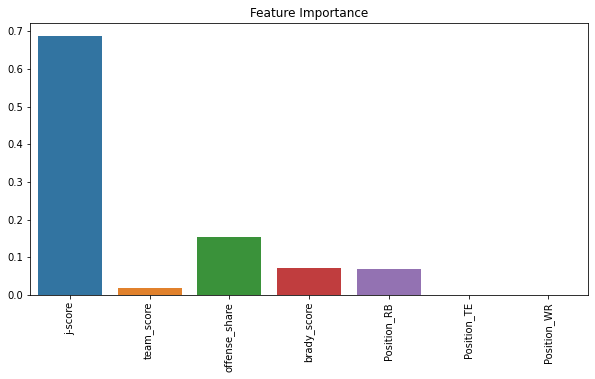

In [59]:
features = ['j-score', 'team_score', 'offense_share', 'brady_score',
       'Position_RB', 'Position_TE', 'Position_WR']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=reg_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [60]:
df_2022

,id,j-score,Team,Position,team_score,offense_share,brady_score
0,Tyreek Hill,0.954797,Miami Dolphins,WR,3.132552,0.304798,0.160556
1,Jonathan Taylor,0.938106,Indianapolis Colts,RB,2.053216,0.456896,0.231495
2,Tyler Lockett,0.936909,Seattle Seahawks,WR,3.318998,0.282287,0.081036
3,Davante Adams,0.936902,Las Vegas Raiders,WR,3.056865,0.306491,0.167599
4,Alvin Kamara,0.934412,New Orleans Saints,RB,2.005514,0.465921,0.016002
...,...,...,...,...,...,...,...
614,Kendall Blanton,0.001148,Los Angeles Rams,TE,1.483369,0.000774,0.102849
615,Miller Forristall,0.001148,Cleveland Browns,TE,1.970110,0.000583,0.866762
616,Eric Tomlinson,0.001148,Baltimore Ravens,TE,1.687319,0.000681,0.874803
617,Greg Dortch,0.001080,Arizona Cardinals,WR,2.596313,0.000416,0.841153


In [62]:
df_2022_X = df_2022.drop(columns=['id','Team'])
df_2022_X

,j-score,Position,team_score,offense_share,brady_score
0,0.954797,WR,3.132552,0.304798,0.160556
1,0.938106,RB,2.053216,0.456896,0.231495
2,0.936909,WR,3.318998,0.282287,0.081036
3,0.936902,WR,3.056865,0.306491,0.167599
4,0.934412,RB,2.005514,0.465921,0.016002
...,...,...,...,...,...
614,0.001148,TE,1.483369,0.000774,0.102849
615,0.001148,TE,1.970110,0.000583,0.866762
616,0.001148,TE,1.687319,0.000681,0.874803
617,0.001080,WR,2.596313,0.000416,0.841153


In [63]:
df_2022_X2 = pd.get_dummies(df_2022_X)
df_2022_X2

,j-score,team_score,offense_share,brady_score,Position_RB,Position_TE,Position_WR
0,0.954797,3.132552,0.304798,0.160556,0,0,1
1,0.938106,2.053216,0.456896,0.231495,1,0,0
2,0.936909,3.318998,0.282287,0.081036,0,0,1
3,0.936902,3.056865,0.306491,0.167599,0,0,1
4,0.934412,2.005514,0.465921,0.016002,1,0,0
...,...,...,...,...,...,...,...
614,0.001148,1.483369,0.000774,0.102849,0,1,0
615,0.001148,1.970110,0.000583,0.866762,0,1,0
616,0.001148,1.687319,0.000681,0.874803,0,1,0
617,0.001080,2.596313,0.000416,0.841153,0,0,1


In [66]:
ash_2022 = pd.DataFrame(reg_xgb2.predict(df_2022_X2)).set_index(df_2022['id']).sort_values(0, axis=0, ascending=False)
ash_2022.head(30)

,0
id,
Jonathan Taylor,264.707275
Nick Chubb,261.385681
Dalvin Cook,260.556000
Mark Andrews,260.109833
Joe Mixon,257.377838
Najee Harris,257.028809
Justin Jefferson,255.958572
Ja'Marr Chase,252.780426
Stefon Diggs,252.431396


### Backtest

#### 2021

In [67]:
df_2021

,Unnamed: 0,Full Name,j-score,y,Team,Position,team_score,offense_share,brady_score
0,0,Alvin Kamara,0.964549,234.6994,New Orleans Saints,RB,1.143686,0.843369,0.014095
1,1,Tyreek Hill,0.954797,296.5004,Kansas City Chiefs,WR,2.393712,0.398877,0.812182
2,2,Tyler Lockett,0.953681,241.4000,Seattle Seahawks,WR,2.391899,0.398713,0.369529
3,3,D.K. Metcalf,0.939311,244.3002,Seattle Seahawks,WR,2.391899,0.392705,0.369529
4,4,Dalvin Cook,0.928772,206.2996,Minnesota Vikings,RB,2.103923,0.441448,0.637825
...,...,...,...,...,...,...,...,...,...
245,343,Randall Cobb,0.007228,93.6000,Green Bay Packers,WR,2.246761,0.003217,0.678502
246,387,Justin Watson,0.005264,0.0000,Tampa Bay Buccaneers,WR,3.130573,0.001681,0.500734
247,399,Rob Gronkowski,0.004572,171.2004,Tampa Bay Buccaneers,TE,3.130573,0.001460,0.500734
248,438,Derek Carrier,0.003570,3.3000,Las Vegas Raiders,TE,1.975811,0.001807,0.038124


In [73]:
df_2021_X = df_2021.drop(columns=['Unnamed: 0','Full Name','Team','y'])
df_2021_X

df_2021_X2 = pd.get_dummies(df_2021_X)
df_2021_X2

ash_2021 = pd.DataFrame(reg_xgb2.predict(df_2021_X2)).set_index(df_2021['Full Name']).sort_values(0, axis=0, ascending=False)
ash_2021.head(30)

,0
Full Name,
Stefon Diggs,262.014526
Dalvin Cook,260.556000
Cooper Kupp,259.930634
Justin Jefferson,257.863251
Aaron Jones,257.028809
Tyler Lockett,255.958572
D.K. Metcalf,255.958572
Davante Adams,255.958572
Tyreek Hill,255.958572
